In [1]:
import numpy as np
import pandas as pd
import torch

from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem, DataStructs

RDLogger.DisableLog('rdApp.*')

from collections import Counter
from itertools import product

import selfies as sf

import matplotlib.pyplot as plt
from matplotlib.colors import to_hex

from mpl_toolkits.mplot3d import Axes3D

from tqdm import tqdm

/Users/jonghopark/miniconda3/envs/moses/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append("..")
import moses
from moses.vae import VAE
from moses.vae_property import VAEPROPERTY
from moses.utils import CharVocab, StringDataset, SELFIESVocab
from moses.vae.trainer import VAETrainer
from moses.vae_property.trainer import VAEPROPERTYTrainer

from moses.metrics import QED, SA, logP
from moses.utils import get_mol

# 1. Loading data

## 1.1 Loading model

In [3]:
folder_path = "../model_results/ZINC250K_vae_property_obj_ws"

config_path = "vae_property_config.pt"
model_path = "vae_property_model_080.pt"

config = torch.load(f"{folder_path}/{config_path}")

vocab_path = "vae_property_vocab.pt"
vocab = torch.load(f"{folder_path}/{vocab_path}")

model = VAEPROPERTY(vocab, config)
model.load_state_dict(torch.load(f"{folder_path}/{model_path}"))



<All keys matched successfully>

## 1.2 Loading train data

In [4]:
data_folder_path = "../moses/dataset/data/ZINC250K"

file_name = "train.csv"

data = pd.read_csv(f"{data_folder_path}/{file_name}")

In [5]:
data.head() #it has smiles, selfies, logP, qed, SAS, obj values

,SMILES,SELFIES,logP,qed,SAS,obj
0,COCCOc1ccc(CNC(=O)c2cnc3ccc(C)cn23)cc1,[C][O][C][C][O][C][=C][C][=C][Branch2][Ring1][...,2.59792,0.672152,2.174005,1.186756
1,Cc1cc(C(=O)NC(C)(C)c2cccc(F)c2)[nH]n1,[C][C][C][=C][Branch2][Ring1][Branch2][C][=Bra...,2.52232,0.891576,2.577987,1.879891
2,CCc1n[nH]c(SCc2nnnn2-c2cc(C)ccc2F)n1,[C][C][C][=N][NH1][C][Branch2][Ring1][=Branch1...,2.08262,0.724791,2.787800,0.836156
3,COc1ccc(CC(=O)Nc2cccc3ncccc23)cc1,[C][O][C][=C][C][=C][Branch2][Ring1][Branch1][...,3.42460,0.801260,1.647545,2.358755
4,CCOc1ccc(Cl)c(C(=O)Nc2cc(C)nn2CCC#N)n1,[C][C][O][C][=C][C][=C][Branch1][C][Cl][C][Bra...,2.80460,0.876945,2.582261,1.802464


### 1.2.1 generate whole_latent_data

In [6]:
np.random.seed(42)
samples = data.iloc[np.random.choice(data.shape[0], 1000, replace=False)]

In [7]:
def get_latent_info(mol_smiles, model):
    mu, log_var, z, _ = model.forward_encoder(model.string2tensor(mol_smiles).reshape(1,-1))

    return mu, log_var, z

In [8]:
def get_latent_whole_info(data, model):
    mu_list = []
    log_var_list = []
    z_list = []
    for i in range(len(data)):
        mu, log_var, z = get_latent_info(data["SMILES"].iloc[i], model)
        mu_list.append(mu)
        log_var_list.append(log_var)
        z_list.append(z)

    mu_df = pd.DataFrame([[point.detach().cpu().numpy()]for point in mu_list], columns=["mu"], index=data.index)
    logvar_df = pd.DataFrame([[point.detach().cpu().numpy()]for point in log_var_list], columns=["logvar"], index=data.index)
    z_df = pd.DataFrame([[point.detach().cpu().numpy()]for point in z_list], columns=["z"], index=data.index)

    return mu_df, logvar_df, z_df

In [9]:
mu_df, log_var_df, z_df = get_latent_whole_info(samples, model)

In [10]:
whole_latent_info = pd.concat([samples, mu_df, log_var_df, z_df], axis=1)

In [11]:
whole_latent_info

,SMILES,SELFIES,logP,qed,SAS,obj,mu,logvar,z
38683,CC(C)n1nnnc1SCc1cc(F)cc2c1OCOC2,[C][C][Branch1][C][C][N][N][=N][N][=C][Ring1][...,2.55190,0.808834,2.786591,1.257578,"[[0.0006688088, -0.04799132, 0.009349651, 0.00...","[[-0.0018990822, -0.0017098114, 0.0023532398, ...","[[0.5801574, 0.63327026, -1.5889657, -0.782782..."
64939,O=C(CCO)N1CCC2(CC(Nc3ncccn3)CO2)C1,[O][=C][Branch1][Ring2][C][C][O][N][C][C][C][B...,0.03090,0.813958,4.044754,0.025037,"[[-0.00095851347, 0.021082483, 0.007405185, 0....","[[4.9378723e-05, -0.0030402318, 0.0017250776, ...","[[1.5726094, 1.1244149, -1.6960049, 0.07692905..."
3954,COc1c(CN(CCC#N)Cc2ccccn2)c(C)nn1C,[C][O][C][=C][Branch2][Ring1][C][C][N][Branch1...,2.04800,0.782484,2.591605,1.320817,"[[0.009314321, 0.0017299056, 0.01059019, -0.00...","[[0.00043804199, -0.0008841902, -0.0006967876,...","[[-1.219452, -0.86812717, 1.9055818, 0.2491289..."
120374,CC(C)CCn1c(=O)c2sccc2n2c(=O)[nH]nc12,[C][C][Branch1][C][C][C][C][N][C][=Branch1][C]...,1.44510,0.787737,2.793158,1.145527,"[[0.0019169301, -0.035416692, 0.0028020684, 0....","[[0.0007841289, -0.0021196902, -0.0014276989, ...","[[2.2949352, -1.5663984, 2.0677588, 0.1754729,..."
172861,N#Cc1ccccc1N1CCN(C(=O)CCN2CCCCC2=O)CC1,[N][#C][C][=C][C][=C][C][=C][Ring1][=Branch1][...,1.60948,0.835036,2.200988,1.974191,"[[0.0012648702, 0.018271655, -0.010631787, 0.0...","[[-0.000246834, -0.0021136627, -0.0008503087, ...","[[-2.08093, -0.89319193, 0.27784938, 1.1111665..."
...,...,...,...,...,...,...,...,...,...
3963,CCOc1ccc(C2NC(=O)NC3=C2C(=O)N(CCC(C)C)C3)cc1,[C][C][O][C][=C][C][=C][Branch2][Ring1][=N][C]...,2.58160,0.833919,2.937811,1.231782,"[[0.0339616, 0.026932195, -0.010883499, 0.0052...","[[0.00015386939, -0.0031673014, -0.0016510524,...","[[-0.8391464, 0.4543811, 1.9760864, 0.23646387..."
79890,Cc1cc(C)c(NC(=O)CNc2nc3ccccc3nc2C)c(C)c1,[C][C][=C][C][Branch1][C][C][=C][Branch2][Ring...,3.91408,0.758875,2.142944,1.651432,"[[0.024229053, -0.001015991, 0.01246443, 0.001...","[[-0.00049760565, -0.00026541203, -0.000601597...","[[1.7071162, 0.84140193, 0.11092332, -0.850215..."
15295,Cc1cccc(N2CC(C(=O)N3CCOC(C)C3)CC2=O)c1C,[C][C][=C][C][=C][C][Branch2][Ring1][#Branch2]...,1.90364,0.837225,2.955786,1.230338,"[[0.0052305683, 0.016977385, -0.02318297, -0.0...","[[-0.0023915023, -0.0017191097, -0.0006081946,...","[[0.79862636, -0.020262789, -0.3740807, 0.2443..."
218373,CN(Cc1cccnc1)S(=O)(=O)N1CCNCC1,[C][N][Branch1][#Branch2][C][C][=C][C][=C][N][...,-0.33660,0.812984,2.360259,1.704662,"[[-0.008896768, 0.05477962, -0.019030368, 0.02...","[[0.0043442287, -0.005062647, -0.00561619, 0.0...","[[-0.47640768, -0.72757804, 0.7297628, -1.3782..."


## 1.2.2 for test mol, generate molecular diagram

In [12]:
props = ["logP", "qed", "SAS", "obj"]

for idx, prop in enumerate(props):
    print(idx,prop)

0 logP
1 qed
2 SAS
3 obj


In [24]:
def sample_latent_space(mu, model, ranges=(3,3), latent_dim=128, n_trials=1000, 
                        n_grid=6, temp=0.01, orthogonal_vec=(None,None), save_name=None, prop_save_name=None,
                        props=None): #note : props should be list of properties among "logP", "qed", "SA", "obj

    np.random.seed(42)

    if orthogonal_vec[0] is None or orthogonal_vec[1] is None: # orthogonal vectors are not given -> set two basis vectors
        orthogonal_vec = np.eye(latent_dim)[np.random.randint(0, latent_dim, 2)]

    x_range, y_range = ranges

    dx = np.linspace(-x_range, x_range, 2*n_grid+1)
    dy = np.linspace(-y_range, y_range, 2*n_grid+1)

    grid = pd.DataFrame(columns=range(2*n_grid+1), index=range(2*n_grid+1))

    prop_grid_list = []

    for _ in range(len(props)):
        prop_grid_list.append(pd.DataFrame(columns=range(2*n_grid+1), index=range(2*n_grid+1)))

    for i_x, i_y in tqdm(product(range(2*n_grid+1), range(2*n_grid+1)), total=(2*n_grid+1)**2,desc='whole_iters'): #each data points
        z_point = mu + dx[i_x]*orthogonal_vec[0] + dy[i_y]*orthogonal_vec[1] # move the point to the direction of the unit vector
        most_freq_mol, freq_df = decode_z(z_point, model, n_trials, temp)

        grid.iloc[i_x, i_y] = most_freq_mol

        for idx, prop in enumerate(props):
            prop_grid_list[idx].iloc[i_x, i_y] = calc_avg_prop(freq_df, props=prop)
                    
    if save_name is not None:
        grid.to_csv(save_name)
    
    if prop_save_name is not None:
        for idx, prop in enumerate(props):
            prop_grid_list[idx].to_csv(f"{prop_save_name}_{prop}.csv")
    
    return grid

def decode_z(z, model, n_trials, temp):
    # decode n_trials times from z using the model sample function, and pick most frequent one
    z_input = torch.tensor(z).repeat(n_trials).reshape(n_trials, -1)

    z_input = z_input.float()

    decoded_mols = model.sample(n_batch=z_input.shape[0], z=z_input, temp=temp)

    valid_decoded_mols = [Chem.MolFromSmiles(mol) for mol in decoded_mols if Chem.MolFromSmiles(mol) is not None]
    
    print(f"ratio of valid molecules : {len(valid_decoded_mols)}/{n_trials}")

    canon_dec_mols = [Chem.MolToSmiles(Chem.MolFromSmiles(mol), canonical=True) for mol in decoded_mols if Chem.MolFromSmiles(mol) is not None]

    mol_freq = Counter(canon_dec_mols)

    most_freq_mol, _ = find_argmax(mol_freq)

    freq_df = get_mol_freq(mol_freq)

    return most_freq_mol, freq_df

def find_argmax(counter):
    # Get the most common element and its count
    most_common_element = counter.most_common(1)
    if most_common_element:
        element, count = most_common_element[0]
        return element, count
    else:
        return None, None

def get_mol_freq(counter):
    # Get the most common element and its count
    mols = counter.keys()
    counts = counter.values()

    freq_df = pd.DataFrame({"mols":mols, "counts":counts})

    return freq_df

def calc_avg_prop(freq_df, props=None):
    if props is None:
        return None
    
    mols = freq_df["mols"] # smiles
    counts = freq_df["counts"]

    avg_prop = 0
    total_count = 0

    for mol, count in zip(mols, counts):
        prop = get_mol_prop(mol, props) # if mol is invalid, skip that molecule and exclude from the calculation of average property.

        if prop is not None:
            total_count += count
            avg_prop += prop*count

    avg_prop /= total_count

    return avg_prop

def get_mol_prop(mol, props): # get the property of the molecule
    chemmol = Chem.MolFromSmiles(mol)

    if chemmol is None:
        return None

    if props == "logP":
        return logP(chemmol)
    elif props == "qed":
        return QED(chemmol)
    elif props == "SA":
        return SA(chemmol)
    elif props == 'obj':
        return 5 * QED(chemmol) - SA(chemmol)
    else:
        return None
    
def plot_freq_mols_with_color(freq_mols_grid_df, save_name=None):
    # plot grid-wise latent space for each molecules
    # and return the color dictionary for each molecule
    
    n_rows, n_cols = freq_mols_grid_df.shape

    mol_positions = {}

    # 그리드의 각 칸에 대해 분자를 추적합니다.
    for i in range(n_rows):
        for j in range(n_cols):
            mol = freq_mols_grid_df.iloc[i, j]
            if mol:  # 빈 셀을 무시합니다.
                mol_smiles = str(mol)
                if mol_smiles not in mol_positions:
                    mol_positions[mol_smiles] = []
                mol_positions[mol_smiles].append((i, j))  # 분자가 존재하는 칸의 위치를 저장합니다.

    # 분자별로 고유한 색을 할당합니다, 단 색상은 중심에 위치한 분자로부터의 tanimoto similarity로 정의됩니다.
    central_mol = freq_mols_grid_df.iloc[n_rows // 2, n_cols // 2]

    unique_colors = {mol_smiles: tuple([calculate_tanomoto_similiarity(mol_smiles, central_mol)]*3) for mol_smiles in mol_positions.keys()}

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(10,10))
    for i in range(n_rows):
        for j in range(n_cols):
            color = unique_colors[freq_mols_grid_df.iloc[i,j]]
            mol = Chem.MolFromSmiles(freq_mols_grid_df.iloc[i,j])

            if mol is not None:
                ax[i,j].add_patch(plt.Rectangle((0,0), 1,1, color=color))
                ax[i,j].axis("off")
            else:
                ax[i,j].axis("off")
    
    if save_name is not None:
        plt.savefig(save_name, dpi=300)

    plt.show()
    plt.clf() 
    
    return unique_colors

def calculate_tanomoto_similiarity(mol1, mol2):
    fp1 = AllChem.GetMorganFingerprint(Chem.MolFromSmiles(mol1), 2)
    fp2 = AllChem.GetMorganFingerprint(Chem.MolFromSmiles(mol2), 2)
    return DataStructs.TanimotoSimilarity(fp1, fp2)


def plot_freq_mols(freq_mols_grid_info, save_name=None):
    if type(freq_mols_grid_info) is str:
        plot_freq_mols_from_path(freq_mols_grid_info, save_name)
    elif type(freq_mols_grid_info) is pd.DataFrame:
        plot_freq_mols_from_df(freq_mols_grid_info, save_name)
    else:
        raise ValueError("Invalid input type")

def plot_freq_mols_from_path(freq_grid_path, save_name=None):
    freq_mols_grid = pd.read_csv(freq_grid_path, index_col=0)

    plot_freq_mols_from_df(freq_mols_grid, save_name)

def plot_freq_mols_from_df(freq_mols_grid, save_name=None):
    n_rows, n_cols = freq_mols_grid.shape

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(10,10))

    for i in range(n_rows):
        for j in range(n_cols):
            mol = Chem.MolFromSmiles(freq_mols_grid.iloc[i,j])
            if mol is not None:
                img = Chem.Draw.MolToImage(mol, size=(300,300))
                ax[i,j].imshow(img)
                ax[i,j].axis("off")
            else:
                ax[i,j].axis("off")

    if save_name is not None:
        plt.savefig(save_name, dpi=300)
        plt.clf()

def plot_prop_mols(prop_grid_info, save_name=None, prop_name=None):
    if type(prop_grid_info) is str:
        plot_prop_mols_from_path(prop_grid_info, save_name, prop_name)
    elif type(prop_grid_info) is pd.DataFrame:
        plot_prop_mols_from_df(prop_grid_info, save_name, prop_name)
    else:
        raise ValueError("Invalid input type")
    
def plot_prop_mols_from_path(prop_grid_path, save_name=None, prop_name=None):
    prop_grid = pd.read_csv(prop_grid_path, index_col=0)

    plot_prop_mols_from_df(prop_grid, save_name, prop_name)

        
def plot_prop_mols_from_df(prop_df, save_name=None, prop_name=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    x = prop_df.index
    y = np.arange(len(prop_df.columns))

    X,Y = np.meshgrid(x,y)

    Z = prop_df.values

    print(prop_df)
    print(x)
    print(y)
    print(Z)

    surf = ax.plot_surface(X, Y, Z, cmap='viridis')

    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)


    ax.set_title("property surface in subspace of latent space")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel(prop_name)

    if save_name is not None:
        plt.savefig(save_name, dpi=300)
        plt.clf()

In [14]:
test_mol = whole_latent_info.iloc[0]

In [15]:
test_mol

SMILES                       CC(C)n1nnnc1SCc1cc(F)cc2c1OCOC2
SELFIES    [C][C][Branch1][C][C][N][N][=N][N][=C][Ring1][...
logP                                                  2.5519
qed                                                 0.808834
SAS                                                 2.786591
obj                                                 1.257578
mu         [[0.0006688088, -0.04799132, 0.009349651, 0.00...
logvar     [[-0.0018990822, -0.0017098114, 0.0023532398, ...
z          [[0.5801574, 0.63327026, -1.5889657, -0.782782...
Name: 38683, dtype: object

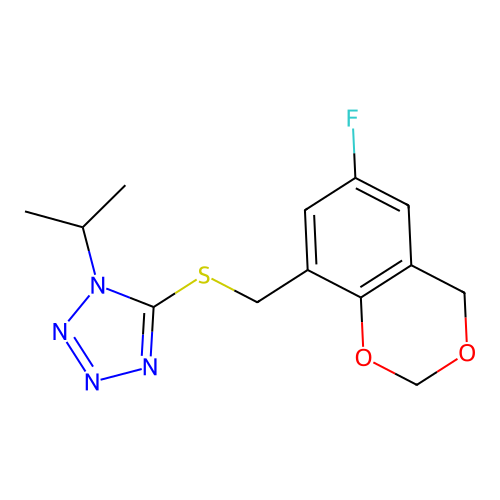

In [16]:
img = Chem.Draw.MolToImage(Chem.MolFromSmiles(test_mol['SMILES']), size=(500,500))


img

In [25]:
ranges_list = [(10,10), (20,20), (30,30)]

temp_list = [0.01, 0.1, 1]

experiments = list(product(ranges_list, temp_list))

v1 = np.ones(config.d_z)
v1 = v1/np.linalg.norm(v1) # 1/sqrt(128)*np.ones(128)

v2 = np.array([1 if i < config.d_z//2 else -1 for i in range(config.d_z)])
v2 = v2/np.linalg.norm(v2) # 1/sqrt(128)*[1,1,1,1,1...,-1(65th coord),-1,-1,-1,-1... -1]

save_folder_path = "figures/two_other_orthogonal_basis"
prop_fname = "test_mol_prop"
mol_fname = "test_mol"

for i, (ranges, temp) in enumerate(experiments):
    print(f"------------- Experiment {i} -------------")
    if i<=1:
        continue
    
    grid = sample_latent_space(test_mol["mu"][0], model, ranges=ranges, temp=temp, n_trials=1000, n_grid=10, orthogonal_vec=(v1,v2),
                               prop_save_name=f"{save_folder_path}/csv_folder/{prop_fname}_{i}.csv", props=["logP", "SA", "qed", "obj"],
                               save_name=f"{save_folder_path}/csv_folder/{mol_fname}_{i}.csv")
    
    plot_freq_mols(grid, save_name=f"{save_folder_path}/{mol_fname}_{i}.png")

    for prop in ["logP", "SA", "qed", "obj"]:
        plot_prop_mols(prop_grid_info=f"{save_folder_path}/csv_folder/{prop_fname}_{i}.csv_{prop}.csv", save_name=f"{save_folder_path}/{prop_fname}_{i}_{prop}.png")

------------- Experiment 0 -------------
------------- Experiment 1 -------------
------------- Experiment 2 -------------


whole_iters:   0%|          | 0/441 [00:00<?, ?it/s]

ratio of valid molecules : 861/1000


whole_iters:   0%|          | 1/441 [00:09<1:07:41,  9.23s/it]

ratio of valid molecules : 879/1000


whole_iters:   0%|          | 2/441 [00:18<1:07:17,  9.20s/it]

ratio of valid molecules : 859/1000


whole_iters:   1%|          | 3/441 [00:27<1:06:47,  9.15s/it]

ratio of valid molecules : 870/1000


whole_iters:   1%|          | 4/441 [00:36<1:07:17,  9.24s/it]

ratio of valid molecules : 874/1000


whole_iters:   1%|          | 5/441 [00:46<1:07:09,  9.24s/it]

ratio of valid molecules : 893/1000


whole_iters:   1%|▏         | 6/441 [00:55<1:07:17,  9.28s/it]

ratio of valid molecules : 875/1000


whole_iters:   2%|▏         | 7/441 [01:04<1:06:42,  9.22s/it]

ratio of valid molecules : 892/1000


whole_iters:   2%|▏         | 8/441 [01:12<1:03:53,  8.85s/it]

ratio of valid molecules : 869/1000


whole_iters:   2%|▏         | 9/441 [01:20<1:01:36,  8.56s/it]

ratio of valid molecules : 889/1000


whole_iters:   2%|▏         | 10/441 [01:28<1:00:08,  8.37s/it]

ratio of valid molecules : 880/1000


whole_iters:   2%|▏         | 11/441 [01:36<58:59,  8.23s/it]  

ratio of valid molecules : 867/1000


whole_iters:   3%|▎         | 12/441 [01:44<58:12,  8.14s/it]

ratio of valid molecules : 881/1000


whole_iters:   3%|▎         | 13/441 [01:52<57:40,  8.09s/it]

ratio of valid molecules : 881/1000


whole_iters:   3%|▎         | 14/441 [02:00<57:18,  8.05s/it]

ratio of valid molecules : 876/1000


whole_iters:   3%|▎         | 15/441 [02:08<56:55,  8.02s/it]

ratio of valid molecules : 879/1000


whole_iters:   4%|▎         | 16/441 [02:16<56:38,  8.00s/it]

ratio of valid molecules : 855/1000


whole_iters:   4%|▍         | 17/441 [02:23<55:59,  7.92s/it]

ratio of valid molecules : 889/1000


whole_iters:   4%|▍         | 18/441 [02:31<56:02,  7.95s/it]

ratio of valid molecules : 881/1000


whole_iters:   4%|▍         | 19/441 [02:39<55:57,  7.95s/it]

ratio of valid molecules : 883/1000


whole_iters:   5%|▍         | 20/441 [02:47<56:02,  7.99s/it]

ratio of valid molecules : 887/1000


whole_iters:   5%|▍         | 21/441 [02:56<56:13,  8.03s/it]

ratio of valid molecules : 869/1000


whole_iters:   5%|▍         | 22/441 [03:04<56:25,  8.08s/it]

ratio of valid molecules : 870/1000


whole_iters:   5%|▌         | 23/441 [03:12<56:12,  8.07s/it]

ratio of valid molecules : 851/1000


whole_iters:   5%|▌         | 24/441 [03:20<55:32,  7.99s/it]

ratio of valid molecules : 887/1000


whole_iters:   6%|▌         | 25/441 [03:28<55:33,  8.01s/it]

ratio of valid molecules : 867/1000


whole_iters:   6%|▌         | 26/441 [03:36<55:06,  7.97s/it]

ratio of valid molecules : 878/1000


whole_iters:   6%|▌         | 27/441 [03:44<55:10,  8.00s/it]

ratio of valid molecules : 866/1000


whole_iters:   6%|▋         | 28/441 [03:52<54:54,  7.98s/it]

ratio of valid molecules : 881/1000


whole_iters:   7%|▋         | 29/441 [04:00<54:50,  7.99s/it]

ratio of valid molecules : 861/1000


whole_iters:   7%|▋         | 30/441 [04:07<54:24,  7.94s/it]

ratio of valid molecules : 874/1000


whole_iters:   7%|▋         | 31/441 [04:15<54:19,  7.95s/it]

ratio of valid molecules : 875/1000


whole_iters:   7%|▋         | 32/441 [04:23<54:08,  7.94s/it]

ratio of valid molecules : 879/1000


whole_iters:   7%|▋         | 33/441 [04:31<54:15,  7.98s/it]

ratio of valid molecules : 872/1000


whole_iters:   8%|▊         | 34/441 [04:39<54:02,  7.97s/it]

ratio of valid molecules : 885/1000


whole_iters:   8%|▊         | 35/441 [04:47<53:49,  7.95s/it]

ratio of valid molecules : 863/1000


whole_iters:   8%|▊         | 36/441 [04:55<53:39,  7.95s/it]

ratio of valid molecules : 877/1000


whole_iters:   8%|▊         | 37/441 [05:03<53:21,  7.92s/it]

ratio of valid molecules : 854/1000


whole_iters:   9%|▊         | 38/441 [05:11<53:07,  7.91s/it]

ratio of valid molecules : 866/1000


whole_iters:   9%|▉         | 39/441 [05:19<53:08,  7.93s/it]

ratio of valid molecules : 872/1000


whole_iters:   9%|▉         | 40/441 [05:27<52:48,  7.90s/it]

ratio of valid molecules : 873/1000


whole_iters:   9%|▉         | 41/441 [05:35<52:54,  7.94s/it]

ratio of valid molecules : 874/1000


whole_iters:  10%|▉         | 42/441 [05:43<52:46,  7.94s/it]

ratio of valid molecules : 877/1000


whole_iters:  10%|▉         | 43/441 [05:51<52:56,  7.98s/it]

ratio of valid molecules : 890/1000


whole_iters:  10%|▉         | 44/441 [05:59<53:06,  8.03s/it]

ratio of valid molecules : 870/1000


whole_iters:  10%|█         | 45/441 [06:07<52:36,  7.97s/it]

ratio of valid molecules : 862/1000


whole_iters:  10%|█         | 46/441 [06:15<52:14,  7.94s/it]

ratio of valid molecules : 870/1000


whole_iters:  11%|█         | 47/441 [06:23<52:48,  8.04s/it]

ratio of valid molecules : 881/1000


whole_iters:  11%|█         | 48/441 [06:31<53:40,  8.19s/it]

ratio of valid molecules : 865/1000


whole_iters:  11%|█         | 49/441 [06:39<53:12,  8.14s/it]

ratio of valid molecules : 870/1000


whole_iters:  11%|█▏        | 50/441 [06:47<52:38,  8.08s/it]

ratio of valid molecules : 866/1000


whole_iters:  12%|█▏        | 51/441 [06:55<52:16,  8.04s/it]

ratio of valid molecules : 889/1000


whole_iters:  12%|█▏        | 52/441 [07:03<52:10,  8.05s/it]

ratio of valid molecules : 882/1000


whole_iters:  12%|█▏        | 53/441 [07:11<51:48,  8.01s/it]

ratio of valid molecules : 871/1000


whole_iters:  12%|█▏        | 54/441 [07:19<51:21,  7.96s/it]

ratio of valid molecules : 882/1000


whole_iters:  12%|█▏        | 55/441 [07:27<51:08,  7.95s/it]

ratio of valid molecules : 880/1000


whole_iters:  13%|█▎        | 56/441 [07:35<50:52,  7.93s/it]

ratio of valid molecules : 890/1000


whole_iters:  13%|█▎        | 57/441 [07:43<50:51,  7.95s/it]

ratio of valid molecules : 883/1000


whole_iters:  13%|█▎        | 58/441 [07:51<50:34,  7.92s/it]

ratio of valid molecules : 882/1000


whole_iters:  13%|█▎        | 59/441 [07:59<50:32,  7.94s/it]

ratio of valid molecules : 880/1000


whole_iters:  14%|█▎        | 60/441 [08:07<50:23,  7.93s/it]

ratio of valid molecules : 866/1000


whole_iters:  14%|█▍        | 61/441 [08:15<50:06,  7.91s/it]

ratio of valid molecules : 866/1000


whole_iters:  14%|█▍        | 62/441 [08:22<49:53,  7.90s/it]

ratio of valid molecules : 878/1000


whole_iters:  14%|█▍        | 63/441 [08:31<50:04,  7.95s/it]

ratio of valid molecules : 870/1000


whole_iters:  15%|█▍        | 64/441 [08:38<49:55,  7.95s/it]

ratio of valid molecules : 867/1000


whole_iters:  15%|█▍        | 65/441 [08:46<49:46,  7.94s/it]

ratio of valid molecules : 899/1000


whole_iters:  15%|█▍        | 66/441 [08:55<50:16,  8.04s/it]

ratio of valid molecules : 890/1000


whole_iters:  15%|█▌        | 67/441 [09:03<50:13,  8.06s/it]

ratio of valid molecules : 867/1000


whole_iters:  15%|█▌        | 68/441 [09:11<49:53,  8.03s/it]

ratio of valid molecules : 873/1000


whole_iters:  16%|█▌        | 69/441 [09:19<49:32,  7.99s/it]

ratio of valid molecules : 891/1000


whole_iters:  16%|█▌        | 70/441 [09:27<49:30,  8.01s/it]

ratio of valid molecules : 881/1000


whole_iters:  16%|█▌        | 71/441 [09:35<49:20,  8.00s/it]

ratio of valid molecules : 884/1000


whole_iters:  16%|█▋        | 72/441 [09:43<49:21,  8.03s/it]

ratio of valid molecules : 883/1000


whole_iters:  17%|█▋        | 73/441 [09:51<49:01,  7.99s/it]

ratio of valid molecules : 872/1000


whole_iters:  17%|█▋        | 74/441 [09:59<48:45,  7.97s/it]

ratio of valid molecules : 878/1000


whole_iters:  17%|█▋        | 75/441 [10:07<48:48,  8.00s/it]

ratio of valid molecules : 859/1000


whole_iters:  17%|█▋        | 76/441 [10:14<48:19,  7.94s/it]

ratio of valid molecules : 879/1000


whole_iters:  17%|█▋        | 77/441 [10:22<48:20,  7.97s/it]

ratio of valid molecules : 861/1000


whole_iters:  18%|█▊        | 78/441 [10:30<47:49,  7.90s/it]

ratio of valid molecules : 853/1000


whole_iters:  18%|█▊        | 79/441 [10:38<47:22,  7.85s/it]

ratio of valid molecules : 880/1000


whole_iters:  18%|█▊        | 80/441 [10:46<47:20,  7.87s/it]

ratio of valid molecules : 866/1000


whole_iters:  18%|█▊        | 81/441 [10:54<47:13,  7.87s/it]

ratio of valid molecules : 886/1000


whole_iters:  19%|█▊        | 82/441 [11:02<47:08,  7.88s/it]

ratio of valid molecules : 880/1000


whole_iters:  19%|█▉        | 83/441 [11:10<47:06,  7.90s/it]

ratio of valid molecules : 866/1000


whole_iters:  19%|█▉        | 84/441 [11:17<46:45,  7.86s/it]

ratio of valid molecules : 862/1000


whole_iters:  19%|█▉        | 85/441 [11:25<46:30,  7.84s/it]

ratio of valid molecules : 876/1000


whole_iters:  20%|█▉        | 86/441 [11:33<46:37,  7.88s/it]

ratio of valid molecules : 860/1000


whole_iters:  20%|█▉        | 87/441 [11:41<46:33,  7.89s/it]

ratio of valid molecules : 871/1000


whole_iters:  20%|█▉        | 88/441 [11:49<46:25,  7.89s/it]

ratio of valid molecules : 865/1000


whole_iters:  20%|██        | 89/441 [11:57<46:13,  7.88s/it]

ratio of valid molecules : 879/1000


whole_iters:  20%|██        | 90/441 [12:05<46:20,  7.92s/it]

ratio of valid molecules : 894/1000


whole_iters:  21%|██        | 91/441 [12:13<46:24,  7.96s/it]

ratio of valid molecules : 874/1000


whole_iters:  21%|██        | 92/441 [12:21<46:14,  7.95s/it]

ratio of valid molecules : 896/1000


whole_iters:  21%|██        | 93/441 [12:29<46:16,  7.98s/it]

ratio of valid molecules : 881/1000


whole_iters:  21%|██▏       | 94/441 [12:37<46:03,  7.97s/it]

ratio of valid molecules : 870/1000


whole_iters:  22%|██▏       | 95/441 [12:45<45:58,  7.97s/it]

ratio of valid molecules : 859/1000


whole_iters:  22%|██▏       | 96/441 [12:53<45:45,  7.96s/it]

ratio of valid molecules : 896/1000


whole_iters:  22%|██▏       | 97/441 [13:01<45:36,  7.95s/it]

ratio of valid molecules : 876/1000


whole_iters:  22%|██▏       | 98/441 [13:09<45:35,  7.98s/it]

ratio of valid molecules : 866/1000


whole_iters:  22%|██▏       | 99/441 [13:17<45:36,  8.00s/it]

ratio of valid molecules : 872/1000


whole_iters:  23%|██▎       | 100/441 [13:25<45:22,  7.98s/it]

ratio of valid molecules : 878/1000


whole_iters:  23%|██▎       | 101/441 [13:33<45:10,  7.97s/it]

ratio of valid molecules : 879/1000


whole_iters:  23%|██▎       | 102/441 [13:41<45:04,  7.98s/it]

ratio of valid molecules : 894/1000


whole_iters:  23%|██▎       | 103/441 [13:49<45:04,  8.00s/it]

ratio of valid molecules : 871/1000


whole_iters:  24%|██▎       | 104/441 [13:57<44:55,  8.00s/it]

ratio of valid molecules : 878/1000


whole_iters:  24%|██▍       | 105/441 [14:05<44:35,  7.96s/it]

ratio of valid molecules : 864/1000


whole_iters:  24%|██▍       | 106/441 [14:12<44:10,  7.91s/it]

ratio of valid molecules : 884/1000


whole_iters:  24%|██▍       | 107/441 [14:20<44:04,  7.92s/it]

ratio of valid molecules : 893/1000


whole_iters:  24%|██▍       | 108/441 [14:28<44:17,  7.98s/it]

ratio of valid molecules : 880/1000


whole_iters:  25%|██▍       | 109/441 [14:36<44:02,  7.96s/it]

ratio of valid molecules : 870/1000


whole_iters:  25%|██▍       | 110/441 [14:44<43:47,  7.94s/it]

ratio of valid molecules : 887/1000


whole_iters:  25%|██▌       | 111/441 [14:52<43:40,  7.94s/it]

ratio of valid molecules : 865/1000


whole_iters:  25%|██▌       | 112/441 [15:00<42:58,  7.84s/it]

ratio of valid molecules : 869/1000


whole_iters:  26%|██▌       | 113/441 [15:08<43:15,  7.91s/it]

ratio of valid molecules : 889/1000


whole_iters:  26%|██▌       | 114/441 [15:16<43:23,  7.96s/it]

ratio of valid molecules : 869/1000


whole_iters:  26%|██▌       | 115/441 [15:24<43:12,  7.95s/it]

ratio of valid molecules : 885/1000


whole_iters:  26%|██▋       | 116/441 [15:32<43:01,  7.94s/it]

ratio of valid molecules : 877/1000


whole_iters:  27%|██▋       | 117/441 [15:40<42:44,  7.92s/it]

ratio of valid molecules : 884/1000


whole_iters:  27%|██▋       | 118/441 [15:47<42:35,  7.91s/it]

ratio of valid molecules : 864/1000


whole_iters:  27%|██▋       | 119/441 [15:55<42:17,  7.88s/it]

ratio of valid molecules : 868/1000


whole_iters:  27%|██▋       | 120/441 [16:03<42:21,  7.92s/it]

ratio of valid molecules : 869/1000


whole_iters:  27%|██▋       | 121/441 [16:11<42:12,  7.91s/it]

ratio of valid molecules : 878/1000


whole_iters:  28%|██▊       | 122/441 [16:19<42:03,  7.91s/it]

ratio of valid molecules : 870/1000


whole_iters:  28%|██▊       | 123/441 [16:27<41:48,  7.89s/it]

ratio of valid molecules : 887/1000


whole_iters:  28%|██▊       | 124/441 [16:35<41:59,  7.95s/it]

ratio of valid molecules : 865/1000


whole_iters:  28%|██▊       | 125/441 [16:43<41:32,  7.89s/it]

ratio of valid molecules : 874/1000


whole_iters:  29%|██▊       | 126/441 [16:51<41:22,  7.88s/it]

ratio of valid molecules : 884/1000


whole_iters:  29%|██▉       | 127/441 [16:59<41:31,  7.93s/it]

ratio of valid molecules : 875/1000


whole_iters:  29%|██▉       | 128/441 [17:07<41:34,  7.97s/it]

ratio of valid molecules : 869/1000


whole_iters:  29%|██▉       | 129/441 [17:15<41:27,  7.97s/it]

ratio of valid molecules : 873/1000


whole_iters:  29%|██▉       | 130/441 [17:23<41:14,  7.96s/it]

ratio of valid molecules : 878/1000


whole_iters:  30%|██▉       | 131/441 [17:31<41:10,  7.97s/it]

ratio of valid molecules : 872/1000


whole_iters:  30%|██▉       | 132/441 [17:39<41:03,  7.97s/it]

ratio of valid molecules : 873/1000


whole_iters:  30%|███       | 133/441 [17:47<40:58,  7.98s/it]

ratio of valid molecules : 875/1000


whole_iters:  30%|███       | 134/441 [17:55<41:15,  8.06s/it]

ratio of valid molecules : 875/1000


whole_iters:  31%|███       | 135/441 [18:03<40:50,  8.01s/it]

ratio of valid molecules : 877/1000


whole_iters:  31%|███       | 136/441 [18:11<40:42,  8.01s/it]

ratio of valid molecules : 878/1000


whole_iters:  31%|███       | 137/441 [18:19<40:45,  8.04s/it]

ratio of valid molecules : 882/1000


whole_iters:  31%|███▏      | 138/441 [18:27<40:28,  8.01s/it]

ratio of valid molecules : 887/1000


whole_iters:  32%|███▏      | 139/441 [18:35<40:14,  7.99s/it]

ratio of valid molecules : 871/1000


whole_iters:  32%|███▏      | 140/441 [18:43<39:52,  7.95s/it]

ratio of valid molecules : 886/1000


whole_iters:  32%|███▏      | 141/441 [18:51<39:58,  8.00s/it]

ratio of valid molecules : 885/1000


whole_iters:  32%|███▏      | 142/441 [18:59<39:52,  8.00s/it]

ratio of valid molecules : 870/1000


whole_iters:  32%|███▏      | 143/441 [19:07<39:40,  7.99s/it]

ratio of valid molecules : 887/1000


whole_iters:  33%|███▎      | 144/441 [19:15<39:27,  7.97s/it]

ratio of valid molecules : 878/1000


whole_iters:  33%|███▎      | 145/441 [19:23<39:17,  7.97s/it]

ratio of valid molecules : 870/1000


whole_iters:  33%|███▎      | 146/441 [19:31<39:16,  7.99s/it]

ratio of valid molecules : 877/1000


whole_iters:  33%|███▎      | 147/441 [19:39<39:18,  8.02s/it]

ratio of valid molecules : 856/1000


whole_iters:  34%|███▎      | 148/441 [19:47<38:54,  7.97s/it]

ratio of valid molecules : 898/1000


whole_iters:  34%|███▍      | 149/441 [19:55<39:06,  8.04s/it]

ratio of valid molecules : 868/1000


whole_iters:  34%|███▍      | 150/441 [20:03<38:56,  8.03s/it]

ratio of valid molecules : 888/1000


whole_iters:  34%|███▍      | 151/441 [20:11<38:46,  8.02s/it]

ratio of valid molecules : 882/1000


whole_iters:  34%|███▍      | 152/441 [20:19<38:47,  8.05s/it]

ratio of valid molecules : 880/1000


whole_iters:  35%|███▍      | 153/441 [20:27<38:28,  8.01s/it]

ratio of valid molecules : 871/1000


whole_iters:  35%|███▍      | 154/441 [20:35<38:19,  8.01s/it]

ratio of valid molecules : 883/1000


whole_iters:  35%|███▌      | 155/441 [20:43<37:58,  7.97s/it]

ratio of valid molecules : 896/1000


whole_iters:  35%|███▌      | 156/441 [20:51<38:17,  8.06s/it]

ratio of valid molecules : 870/1000


whole_iters:  36%|███▌      | 157/441 [20:59<38:12,  8.07s/it]

ratio of valid molecules : 890/1000


whole_iters:  36%|███▌      | 158/441 [21:07<37:53,  8.03s/it]

ratio of valid molecules : 882/1000


whole_iters:  36%|███▌      | 159/441 [21:15<37:54,  8.07s/it]

ratio of valid molecules : 882/1000


whole_iters:  36%|███▋      | 160/441 [21:23<37:33,  8.02s/it]

ratio of valid molecules : 898/1000


whole_iters:  37%|███▋      | 161/441 [21:31<37:20,  8.00s/it]

ratio of valid molecules : 890/1000


whole_iters:  37%|███▋      | 162/441 [21:39<37:05,  7.98s/it]

ratio of valid molecules : 884/1000


whole_iters:  37%|███▋      | 163/441 [21:47<36:59,  7.98s/it]

ratio of valid molecules : 896/1000


whole_iters:  37%|███▋      | 164/441 [21:55<36:55,  8.00s/it]

ratio of valid molecules : 881/1000


whole_iters:  37%|███▋      | 165/441 [22:03<36:59,  8.04s/it]

ratio of valid molecules : 880/1000


whole_iters:  38%|███▊      | 166/441 [22:11<36:41,  8.00s/it]

ratio of valid molecules : 895/1000


whole_iters:  38%|███▊      | 167/441 [22:19<36:45,  8.05s/it]

ratio of valid molecules : 866/1000


whole_iters:  38%|███▊      | 168/441 [22:27<36:17,  7.98s/it]

ratio of valid molecules : 890/1000


whole_iters:  38%|███▊      | 169/441 [22:35<36:11,  7.98s/it]

ratio of valid molecules : 894/1000


whole_iters:  39%|███▊      | 170/441 [22:43<36:30,  8.08s/it]

ratio of valid molecules : 873/1000


whole_iters:  39%|███▉      | 171/441 [22:51<36:01,  8.01s/it]

ratio of valid molecules : 872/1000


whole_iters:  39%|███▉      | 172/441 [22:59<35:57,  8.02s/it]

ratio of valid molecules : 875/1000


whole_iters:  39%|███▉      | 173/441 [23:07<35:43,  8.00s/it]

ratio of valid molecules : 878/1000


whole_iters:  39%|███▉      | 174/441 [23:15<35:29,  7.98s/it]

ratio of valid molecules : 873/1000


whole_iters:  40%|███▉      | 175/441 [23:23<35:13,  7.94s/it]

ratio of valid molecules : 888/1000


whole_iters:  40%|███▉      | 176/441 [23:31<35:14,  7.98s/it]

ratio of valid molecules : 876/1000


whole_iters:  40%|████      | 177/441 [23:39<35:03,  7.97s/it]

ratio of valid molecules : 880/1000


whole_iters:  40%|████      | 178/441 [23:47<34:45,  7.93s/it]

ratio of valid molecules : 875/1000


whole_iters:  41%|████      | 179/441 [23:55<34:46,  7.97s/it]

ratio of valid molecules : 890/1000


whole_iters:  41%|████      | 180/441 [24:03<34:41,  7.98s/it]

ratio of valid molecules : 880/1000


whole_iters:  41%|████      | 181/441 [24:11<34:27,  7.95s/it]

ratio of valid molecules : 878/1000


whole_iters:  41%|████▏     | 182/441 [24:19<34:24,  7.97s/it]

ratio of valid molecules : 898/1000


whole_iters:  41%|████▏     | 183/441 [24:27<34:35,  8.04s/it]

ratio of valid molecules : 871/1000


whole_iters:  42%|████▏     | 184/441 [24:35<34:17,  8.01s/it]

ratio of valid molecules : 882/1000


whole_iters:  42%|████▏     | 185/441 [24:43<34:17,  8.04s/it]

ratio of valid molecules : 879/1000


whole_iters:  42%|████▏     | 186/441 [24:51<34:01,  8.01s/it]

ratio of valid molecules : 875/1000


whole_iters:  42%|████▏     | 187/441 [24:59<33:34,  7.93s/it]

ratio of valid molecules : 890/1000


whole_iters:  43%|████▎     | 188/441 [25:07<33:47,  8.01s/it]

ratio of valid molecules : 892/1000


whole_iters:  43%|████▎     | 189/441 [25:15<33:40,  8.02s/it]

ratio of valid molecules : 874/1000


whole_iters:  43%|████▎     | 190/441 [25:23<33:42,  8.06s/it]

ratio of valid molecules : 889/1000


whole_iters:  43%|████▎     | 191/441 [25:31<33:34,  8.06s/it]

ratio of valid molecules : 878/1000


whole_iters:  44%|████▎     | 192/441 [25:39<33:19,  8.03s/it]

ratio of valid molecules : 882/1000


whole_iters:  44%|████▍     | 193/441 [25:47<33:07,  8.01s/it]

ratio of valid molecules : 870/1000


whole_iters:  44%|████▍     | 194/441 [25:55<32:48,  7.97s/it]

ratio of valid molecules : 894/1000


whole_iters:  44%|████▍     | 195/441 [26:03<32:47,  8.00s/it]

ratio of valid molecules : 884/1000


whole_iters:  44%|████▍     | 196/441 [26:11<32:31,  7.96s/it]

ratio of valid molecules : 883/1000


whole_iters:  45%|████▍     | 197/441 [26:19<32:11,  7.92s/it]

ratio of valid molecules : 865/1000


whole_iters:  45%|████▍     | 198/441 [26:27<31:56,  7.89s/it]

ratio of valid molecules : 882/1000


whole_iters:  45%|████▌     | 199/441 [26:34<31:49,  7.89s/it]

ratio of valid molecules : 861/1000


whole_iters:  45%|████▌     | 200/441 [26:42<31:41,  7.89s/it]

ratio of valid molecules : 886/1000


whole_iters:  46%|████▌     | 201/441 [26:50<31:45,  7.94s/it]

ratio of valid molecules : 877/1000


whole_iters:  46%|████▌     | 202/441 [26:58<31:36,  7.94s/it]

ratio of valid molecules : 859/1000


whole_iters:  46%|████▌     | 203/441 [27:06<31:25,  7.92s/it]

ratio of valid molecules : 887/1000


whole_iters:  46%|████▋     | 204/441 [27:14<31:12,  7.90s/it]

ratio of valid molecules : 887/1000


whole_iters:  46%|████▋     | 205/441 [27:22<31:02,  7.89s/it]

ratio of valid molecules : 887/1000


whole_iters:  47%|████▋     | 206/441 [27:30<31:01,  7.92s/it]

ratio of valid molecules : 889/1000


whole_iters:  47%|████▋     | 207/441 [27:38<30:55,  7.93s/it]

ratio of valid molecules : 879/1000


whole_iters:  47%|████▋     | 208/441 [27:46<30:41,  7.90s/it]

ratio of valid molecules : 885/1000


whole_iters:  47%|████▋     | 209/441 [27:54<30:35,  7.91s/it]

ratio of valid molecules : 891/1000


whole_iters:  48%|████▊     | 210/441 [28:01<30:25,  7.90s/it]

ratio of valid molecules : 880/1000


whole_iters:  48%|████▊     | 211/441 [28:09<30:23,  7.93s/it]

ratio of valid molecules : 871/1000


whole_iters:  48%|████▊     | 212/441 [28:17<30:09,  7.90s/it]

ratio of valid molecules : 873/1000


whole_iters:  48%|████▊     | 213/441 [28:25<29:54,  7.87s/it]

ratio of valid molecules : 879/1000


whole_iters:  49%|████▊     | 214/441 [28:33<29:50,  7.89s/it]

ratio of valid molecules : 893/1000


whole_iters:  49%|████▉     | 215/441 [28:41<29:54,  7.94s/it]

ratio of valid molecules : 884/1000


whole_iters:  49%|████▉     | 216/441 [28:49<29:51,  7.96s/it]

ratio of valid molecules : 872/1000


whole_iters:  49%|████▉     | 217/441 [28:57<29:35,  7.93s/it]

ratio of valid molecules : 879/1000


whole_iters:  49%|████▉     | 218/441 [29:05<29:29,  7.93s/it]

ratio of valid molecules : 886/1000


whole_iters:  50%|████▉     | 219/441 [29:13<29:24,  7.95s/it]

ratio of valid molecules : 870/1000


whole_iters:  50%|████▉     | 220/441 [29:21<29:05,  7.90s/it]

ratio of valid molecules : 883/1000


whole_iters:  50%|█████     | 221/441 [29:29<29:00,  7.91s/it]

ratio of valid molecules : 883/1000


whole_iters:  50%|█████     | 222/441 [29:37<28:53,  7.92s/it]

ratio of valid molecules : 882/1000


whole_iters:  51%|█████     | 223/441 [29:44<28:45,  7.91s/it]

ratio of valid molecules : 889/1000


whole_iters:  51%|█████     | 224/441 [29:52<28:36,  7.91s/it]

ratio of valid molecules : 870/1000


whole_iters:  51%|█████     | 225/441 [30:00<28:25,  7.90s/it]

ratio of valid molecules : 879/1000


whole_iters:  51%|█████     | 226/441 [30:08<28:18,  7.90s/it]

ratio of valid molecules : 858/1000


whole_iters:  51%|█████▏    | 227/441 [30:16<28:04,  7.87s/it]

ratio of valid molecules : 886/1000


whole_iters:  52%|█████▏    | 228/441 [30:24<28:03,  7.91s/it]

ratio of valid molecules : 877/1000


whole_iters:  52%|█████▏    | 229/441 [30:32<27:57,  7.91s/it]

ratio of valid molecules : 873/1000


whole_iters:  52%|█████▏    | 230/441 [30:40<27:51,  7.92s/it]

ratio of valid molecules : 874/1000


whole_iters:  52%|█████▏    | 231/441 [30:48<27:41,  7.91s/it]

ratio of valid molecules : 876/1000


whole_iters:  53%|█████▎    | 232/441 [30:56<27:39,  7.94s/it]

ratio of valid molecules : 879/1000


whole_iters:  53%|█████▎    | 233/441 [31:04<27:30,  7.94s/it]

ratio of valid molecules : 877/1000


whole_iters:  53%|█████▎    | 234/441 [31:12<27:29,  7.97s/it]

ratio of valid molecules : 887/1000


whole_iters:  53%|█████▎    | 235/441 [31:20<27:22,  7.97s/it]

ratio of valid molecules : 898/1000


whole_iters:  54%|█████▎    | 236/441 [31:28<27:20,  8.00s/it]

ratio of valid molecules : 874/1000


whole_iters:  54%|█████▎    | 237/441 [31:36<27:05,  7.97s/it]

ratio of valid molecules : 871/1000


whole_iters:  54%|█████▍    | 238/441 [31:44<26:54,  7.95s/it]

ratio of valid molecules : 866/1000


whole_iters:  54%|█████▍    | 239/441 [31:51<26:42,  7.93s/it]

ratio of valid molecules : 891/1000


whole_iters:  54%|█████▍    | 240/441 [31:59<26:36,  7.94s/it]

ratio of valid molecules : 883/1000


whole_iters:  55%|█████▍    | 241/441 [32:07<26:33,  7.97s/it]

ratio of valid molecules : 885/1000


whole_iters:  55%|█████▍    | 242/441 [32:15<26:21,  7.95s/it]

ratio of valid molecules : 886/1000


whole_iters:  55%|█████▌    | 243/441 [32:23<26:21,  7.99s/it]

ratio of valid molecules : 868/1000


whole_iters:  55%|█████▌    | 244/441 [32:31<25:59,  7.92s/it]

ratio of valid molecules : 862/1000


whole_iters:  56%|█████▌    | 245/441 [32:39<25:36,  7.84s/it]

ratio of valid molecules : 867/1000


whole_iters:  56%|█████▌    | 246/441 [32:47<25:26,  7.83s/it]

ratio of valid molecules : 877/1000


whole_iters:  56%|█████▌    | 247/441 [32:54<25:19,  7.83s/it]

ratio of valid molecules : 880/1000


whole_iters:  56%|█████▌    | 248/441 [33:02<25:15,  7.85s/it]

ratio of valid molecules : 884/1000


whole_iters:  56%|█████▋    | 249/441 [33:10<25:16,  7.90s/it]

ratio of valid molecules : 856/1000


whole_iters:  57%|█████▋    | 250/441 [33:18<24:55,  7.83s/it]

ratio of valid molecules : 888/1000


whole_iters:  57%|█████▋    | 251/441 [33:26<24:51,  7.85s/it]

ratio of valid molecules : 881/1000


whole_iters:  57%|█████▋    | 252/441 [33:34<24:40,  7.83s/it]

ratio of valid molecules : 879/1000


whole_iters:  57%|█████▋    | 253/441 [33:42<24:36,  7.85s/it]

ratio of valid molecules : 902/1000


whole_iters:  58%|█████▊    | 254/441 [33:50<24:39,  7.91s/it]

ratio of valid molecules : 882/1000


whole_iters:  58%|█████▊    | 255/441 [33:58<24:31,  7.91s/it]

ratio of valid molecules : 866/1000


whole_iters:  58%|█████▊    | 256/441 [34:05<24:15,  7.87s/it]

ratio of valid molecules : 873/1000


whole_iters:  58%|█████▊    | 257/441 [34:13<23:56,  7.81s/it]

ratio of valid molecules : 886/1000


whole_iters:  59%|█████▊    | 258/441 [34:21<23:54,  7.84s/it]

ratio of valid molecules : 880/1000


whole_iters:  59%|█████▊    | 259/441 [34:29<23:47,  7.85s/it]

ratio of valid molecules : 877/1000


whole_iters:  59%|█████▉    | 260/441 [34:37<23:37,  7.83s/it]

ratio of valid molecules : 881/1000


whole_iters:  59%|█████▉    | 261/441 [34:44<23:34,  7.86s/it]

ratio of valid molecules : 877/1000


whole_iters:  59%|█████▉    | 262/441 [34:52<23:25,  7.85s/it]

ratio of valid molecules : 877/1000


whole_iters:  60%|█████▉    | 263/441 [35:00<23:22,  7.88s/it]

ratio of valid molecules : 880/1000


whole_iters:  60%|█████▉    | 264/441 [35:08<23:11,  7.86s/it]

ratio of valid molecules : 880/1000


whole_iters:  60%|██████    | 265/441 [35:16<23:08,  7.89s/it]

ratio of valid molecules : 857/1000


whole_iters:  60%|██████    | 266/441 [35:24<22:50,  7.83s/it]

ratio of valid molecules : 871/1000


whole_iters:  61%|██████    | 267/441 [35:32<22:43,  7.83s/it]

ratio of valid molecules : 870/1000


whole_iters:  61%|██████    | 268/441 [35:39<22:30,  7.81s/it]

ratio of valid molecules : 874/1000


whole_iters:  61%|██████    | 269/441 [35:47<22:22,  7.80s/it]

ratio of valid molecules : 871/1000


whole_iters:  61%|██████    | 270/441 [35:55<22:09,  7.77s/it]

ratio of valid molecules : 878/1000


whole_iters:  61%|██████▏   | 271/441 [36:03<21:59,  7.76s/it]

ratio of valid molecules : 880/1000


whole_iters:  62%|██████▏   | 272/441 [36:10<21:51,  7.76s/it]

ratio of valid molecules : 897/1000


whole_iters:  62%|██████▏   | 273/441 [36:18<21:52,  7.81s/it]

ratio of valid molecules : 868/1000


whole_iters:  62%|██████▏   | 274/441 [36:26<21:46,  7.82s/it]

ratio of valid molecules : 887/1000


whole_iters:  62%|██████▏   | 275/441 [36:34<21:44,  7.86s/it]

ratio of valid molecules : 885/1000


whole_iters:  63%|██████▎   | 276/441 [36:42<21:45,  7.91s/it]

ratio of valid molecules : 885/1000


whole_iters:  63%|██████▎   | 277/441 [36:50<21:39,  7.93s/it]

ratio of valid molecules : 884/1000


whole_iters:  63%|██████▎   | 278/441 [36:58<21:31,  7.92s/it]

ratio of valid molecules : 881/1000


whole_iters:  63%|██████▎   | 279/441 [37:06<21:19,  7.90s/it]

ratio of valid molecules : 883/1000


whole_iters:  63%|██████▎   | 280/441 [37:14<21:14,  7.91s/it]

ratio of valid molecules : 894/1000


whole_iters:  64%|██████▎   | 281/441 [37:22<21:07,  7.92s/it]

ratio of valid molecules : 867/1000


whole_iters:  64%|██████▍   | 282/441 [37:29<20:52,  7.87s/it]

ratio of valid molecules : 888/1000


whole_iters:  64%|██████▍   | 283/441 [37:37<20:46,  7.89s/it]

ratio of valid molecules : 875/1000


whole_iters:  64%|██████▍   | 284/441 [37:45<20:36,  7.87s/it]

ratio of valid molecules : 873/1000


whole_iters:  65%|██████▍   | 285/441 [37:53<20:25,  7.86s/it]

ratio of valid molecules : 891/1000


whole_iters:  65%|██████▍   | 286/441 [38:01<20:16,  7.85s/it]

ratio of valid molecules : 894/1000


whole_iters:  65%|██████▌   | 287/441 [38:09<20:12,  7.87s/it]

ratio of valid molecules : 883/1000


whole_iters:  65%|██████▌   | 288/441 [38:17<20:08,  7.90s/it]

ratio of valid molecules : 863/1000


whole_iters:  66%|██████▌   | 289/441 [38:24<19:54,  7.86s/it]

ratio of valid molecules : 886/1000


whole_iters:  66%|██████▌   | 290/441 [38:32<19:49,  7.87s/it]

ratio of valid molecules : 886/1000


whole_iters:  66%|██████▌   | 291/441 [38:40<19:39,  7.87s/it]

ratio of valid molecules : 883/1000


whole_iters:  66%|██████▌   | 292/441 [38:48<19:30,  7.86s/it]

ratio of valid molecules : 881/1000


whole_iters:  66%|██████▋   | 293/441 [38:56<19:21,  7.85s/it]

ratio of valid molecules : 874/1000


whole_iters:  67%|██████▋   | 294/441 [39:04<19:13,  7.85s/it]

ratio of valid molecules : 893/1000


whole_iters:  67%|██████▋   | 295/441 [39:12<19:14,  7.91s/it]

ratio of valid molecules : 868/1000


whole_iters:  67%|██████▋   | 296/441 [39:20<19:03,  7.89s/it]

ratio of valid molecules : 873/1000


whole_iters:  67%|██████▋   | 297/441 [39:28<18:54,  7.88s/it]

ratio of valid molecules : 876/1000


whole_iters:  68%|██████▊   | 298/441 [39:35<18:44,  7.86s/it]

ratio of valid molecules : 870/1000


whole_iters:  68%|██████▊   | 299/441 [39:43<18:38,  7.88s/it]

ratio of valid molecules : 875/1000


whole_iters:  68%|██████▊   | 300/441 [39:51<18:27,  7.86s/it]

ratio of valid molecules : 872/1000


whole_iters:  68%|██████▊   | 301/441 [39:59<18:17,  7.84s/it]

ratio of valid molecules : 896/1000


whole_iters:  68%|██████▊   | 302/441 [40:07<18:16,  7.89s/it]

ratio of valid molecules : 896/1000


whole_iters:  69%|██████▊   | 303/441 [40:15<18:15,  7.94s/it]

ratio of valid molecules : 908/1000


whole_iters:  69%|██████▉   | 304/441 [40:23<18:10,  7.96s/it]

ratio of valid molecules : 893/1000


whole_iters:  69%|██████▉   | 305/441 [40:31<17:56,  7.91s/it]

ratio of valid molecules : 883/1000


whole_iters:  69%|██████▉   | 306/441 [40:39<17:46,  7.90s/it]

ratio of valid molecules : 899/1000


whole_iters:  70%|██████▉   | 307/441 [40:46<17:37,  7.89s/it]

ratio of valid molecules : 865/1000


whole_iters:  70%|██████▉   | 308/441 [40:54<17:23,  7.85s/it]

ratio of valid molecules : 879/1000


whole_iters:  70%|███████   | 309/441 [41:02<17:15,  7.84s/it]

ratio of valid molecules : 879/1000


whole_iters:  70%|███████   | 310/441 [41:10<17:07,  7.84s/it]

ratio of valid molecules : 858/1000


whole_iters:  71%|███████   | 311/441 [41:18<16:52,  7.79s/it]

ratio of valid molecules : 889/1000


whole_iters:  71%|███████   | 312/441 [41:25<16:45,  7.79s/it]

ratio of valid molecules : 869/1000


whole_iters:  71%|███████   | 313/441 [41:33<16:35,  7.78s/it]

ratio of valid molecules : 874/1000


whole_iters:  71%|███████   | 314/441 [41:41<16:23,  7.74s/it]

ratio of valid molecules : 858/1000


whole_iters:  71%|███████▏  | 315/441 [41:49<16:15,  7.74s/it]

ratio of valid molecules : 879/1000


whole_iters:  72%|███████▏  | 316/441 [41:56<16:13,  7.79s/it]

ratio of valid molecules : 868/1000


whole_iters:  72%|███████▏  | 317/441 [42:04<16:09,  7.82s/it]

ratio of valid molecules : 884/1000


whole_iters:  72%|███████▏  | 318/441 [42:12<16:09,  7.89s/it]

ratio of valid molecules : 878/1000


whole_iters:  72%|███████▏  | 319/441 [42:20<16:02,  7.89s/it]

ratio of valid molecules : 859/1000


whole_iters:  73%|███████▎  | 320/441 [42:28<15:52,  7.87s/it]

ratio of valid molecules : 869/1000


whole_iters:  73%|███████▎  | 321/441 [42:36<15:40,  7.84s/it]

ratio of valid molecules : 879/1000


whole_iters:  73%|███████▎  | 322/441 [42:44<15:33,  7.85s/it]

ratio of valid molecules : 870/1000


whole_iters:  73%|███████▎  | 323/441 [42:51<15:24,  7.83s/it]

ratio of valid molecules : 873/1000


whole_iters:  73%|███████▎  | 324/441 [42:59<15:14,  7.82s/it]

ratio of valid molecules : 881/1000


whole_iters:  74%|███████▎  | 325/441 [43:07<15:05,  7.80s/it]

ratio of valid molecules : 890/1000


whole_iters:  74%|███████▍  | 326/441 [43:15<15:00,  7.83s/it]

ratio of valid molecules : 881/1000


whole_iters:  74%|███████▍  | 327/441 [43:23<14:52,  7.83s/it]

ratio of valid molecules : 883/1000


whole_iters:  74%|███████▍  | 328/441 [43:31<14:46,  7.85s/it]

ratio of valid molecules : 874/1000


whole_iters:  75%|███████▍  | 329/441 [43:38<14:34,  7.81s/it]

ratio of valid molecules : 883/1000


whole_iters:  75%|███████▍  | 330/441 [43:46<14:28,  7.82s/it]

ratio of valid molecules : 886/1000


whole_iters:  75%|███████▌  | 331/441 [43:54<14:23,  7.85s/it]

ratio of valid molecules : 877/1000


whole_iters:  75%|███████▌  | 332/441 [44:02<14:15,  7.85s/it]

ratio of valid molecules : 881/1000


whole_iters:  76%|███████▌  | 333/441 [44:10<14:13,  7.90s/it]

ratio of valid molecules : 887/1000


whole_iters:  76%|███████▌  | 334/441 [44:18<14:04,  7.89s/it]

ratio of valid molecules : 897/1000


whole_iters:  76%|███████▌  | 335/441 [44:26<13:55,  7.89s/it]

ratio of valid molecules : 890/1000


whole_iters:  76%|███████▌  | 336/441 [44:34<13:44,  7.85s/it]

ratio of valid molecules : 875/1000


whole_iters:  76%|███████▋  | 337/441 [44:41<13:36,  7.86s/it]

ratio of valid molecules : 888/1000


whole_iters:  77%|███████▋  | 338/441 [44:49<13:35,  7.92s/it]

ratio of valid molecules : 872/1000


whole_iters:  77%|███████▋  | 339/441 [44:57<13:26,  7.91s/it]

ratio of valid molecules : 866/1000


whole_iters:  77%|███████▋  | 340/441 [45:05<13:18,  7.91s/it]

ratio of valid molecules : 877/1000


whole_iters:  77%|███████▋  | 341/441 [45:13<13:10,  7.90s/it]

ratio of valid molecules : 879/1000


whole_iters:  78%|███████▊  | 342/441 [45:21<13:01,  7.90s/it]

ratio of valid molecules : 892/1000


whole_iters:  78%|███████▊  | 343/441 [45:29<12:53,  7.89s/it]

ratio of valid molecules : 909/1000


whole_iters:  78%|███████▊  | 344/441 [45:37<12:52,  7.96s/it]

ratio of valid molecules : 874/1000


whole_iters:  78%|███████▊  | 345/441 [45:45<12:41,  7.94s/it]

ratio of valid molecules : 888/1000


whole_iters:  78%|███████▊  | 346/441 [45:53<12:34,  7.94s/it]

ratio of valid molecules : 876/1000


whole_iters:  79%|███████▊  | 347/441 [46:01<12:22,  7.90s/it]

ratio of valid molecules : 898/1000


whole_iters:  79%|███████▉  | 348/441 [46:09<12:18,  7.94s/it]

ratio of valid molecules : 874/1000


whole_iters:  79%|███████▉  | 349/441 [46:16<12:05,  7.89s/it]

ratio of valid molecules : 899/1000


whole_iters:  79%|███████▉  | 350/441 [46:24<12:00,  7.92s/it]

ratio of valid molecules : 902/1000


whole_iters:  80%|███████▉  | 351/441 [46:32<11:51,  7.90s/it]

ratio of valid molecules : 878/1000


whole_iters:  80%|███████▉  | 352/441 [46:40<11:42,  7.90s/it]

ratio of valid molecules : 894/1000


whole_iters:  80%|████████  | 353/441 [46:48<11:37,  7.93s/it]

ratio of valid molecules : 883/1000


whole_iters:  80%|████████  | 354/441 [46:56<11:30,  7.93s/it]

ratio of valid molecules : 881/1000


whole_iters:  80%|████████  | 355/441 [47:04<11:19,  7.90s/it]

ratio of valid molecules : 869/1000


whole_iters:  81%|████████  | 356/441 [47:12<11:06,  7.84s/it]

ratio of valid molecules : 859/1000


whole_iters:  81%|████████  | 357/441 [47:19<10:52,  7.77s/it]

ratio of valid molecules : 876/1000


whole_iters:  81%|████████  | 358/441 [47:27<10:48,  7.81s/it]

ratio of valid molecules : 877/1000


whole_iters:  81%|████████▏ | 359/441 [47:35<10:42,  7.83s/it]

ratio of valid molecules : 896/1000


whole_iters:  82%|████████▏ | 360/441 [47:43<10:41,  7.91s/it]

ratio of valid molecules : 860/1000


whole_iters:  82%|████████▏ | 361/441 [47:51<10:27,  7.85s/it]

ratio of valid molecules : 872/1000


whole_iters:  82%|████████▏ | 362/441 [47:59<10:21,  7.86s/it]

ratio of valid molecules : 882/1000


whole_iters:  82%|████████▏ | 363/441 [48:07<10:16,  7.90s/it]

ratio of valid molecules : 874/1000


whole_iters:  83%|████████▎ | 364/441 [48:15<10:07,  7.89s/it]

ratio of valid molecules : 881/1000


whole_iters:  83%|████████▎ | 365/441 [48:22<09:59,  7.88s/it]

ratio of valid molecules : 880/1000


whole_iters:  83%|████████▎ | 366/441 [48:30<09:51,  7.88s/it]

ratio of valid molecules : 881/1000


whole_iters:  83%|████████▎ | 367/441 [48:38<09:44,  7.89s/it]

ratio of valid molecules : 901/1000


whole_iters:  83%|████████▎ | 368/441 [48:46<09:39,  7.93s/it]

ratio of valid molecules : 878/1000


whole_iters:  84%|████████▎ | 369/441 [48:54<09:27,  7.89s/it]

ratio of valid molecules : 897/1000


whole_iters:  84%|████████▍ | 370/441 [49:02<09:21,  7.90s/it]

ratio of valid molecules : 890/1000


whole_iters:  84%|████████▍ | 371/441 [49:10<09:13,  7.91s/it]

ratio of valid molecules : 887/1000


whole_iters:  84%|████████▍ | 372/441 [49:18<09:03,  7.87s/it]

ratio of valid molecules : 855/1000


whole_iters:  85%|████████▍ | 373/441 [49:25<08:52,  7.83s/it]

ratio of valid molecules : 884/1000


whole_iters:  85%|████████▍ | 374/441 [49:33<08:45,  7.84s/it]

ratio of valid molecules : 871/1000


whole_iters:  85%|████████▌ | 375/441 [49:41<08:37,  7.85s/it]

ratio of valid molecules : 874/1000


whole_iters:  85%|████████▌ | 376/441 [49:49<08:29,  7.83s/it]

ratio of valid molecules : 872/1000


whole_iters:  85%|████████▌ | 377/441 [49:57<08:19,  7.81s/it]

ratio of valid molecules : 873/1000


whole_iters:  86%|████████▌ | 378/441 [50:04<08:11,  7.80s/it]

ratio of valid molecules : 879/1000


whole_iters:  86%|████████▌ | 379/441 [50:12<08:05,  7.83s/it]

ratio of valid molecules : 870/1000


whole_iters:  86%|████████▌ | 380/441 [50:20<07:59,  7.85s/it]

ratio of valid molecules : 899/1000


whole_iters:  86%|████████▋ | 381/441 [50:28<07:53,  7.89s/it]

ratio of valid molecules : 900/1000


whole_iters:  87%|████████▋ | 382/441 [50:36<07:48,  7.94s/it]

ratio of valid molecules : 863/1000


whole_iters:  87%|████████▋ | 383/441 [50:44<07:36,  7.87s/it]

ratio of valid molecules : 898/1000


whole_iters:  87%|████████▋ | 384/441 [50:52<07:32,  7.93s/it]

ratio of valid molecules : 888/1000


whole_iters:  87%|████████▋ | 385/441 [51:00<07:25,  7.95s/it]

ratio of valid molecules : 901/1000


whole_iters:  88%|████████▊ | 386/441 [51:08<07:18,  7.98s/it]

ratio of valid molecules : 878/1000


whole_iters:  88%|████████▊ | 387/441 [51:16<07:08,  7.93s/it]

ratio of valid molecules : 897/1000


whole_iters:  88%|████████▊ | 388/441 [51:24<07:00,  7.93s/it]

ratio of valid molecules : 878/1000


whole_iters:  88%|████████▊ | 389/441 [51:32<06:53,  7.95s/it]

ratio of valid molecules : 878/1000


whole_iters:  88%|████████▊ | 390/441 [51:40<06:43,  7.91s/it]

ratio of valid molecules : 877/1000


whole_iters:  89%|████████▊ | 391/441 [51:48<06:35,  7.91s/it]

ratio of valid molecules : 885/1000


whole_iters:  89%|████████▉ | 392/441 [51:56<06:29,  7.94s/it]

ratio of valid molecules : 887/1000


whole_iters:  89%|████████▉ | 393/441 [52:03<06:20,  7.92s/it]

ratio of valid molecules : 873/1000


whole_iters:  89%|████████▉ | 394/441 [52:11<06:09,  7.86s/it]

ratio of valid molecules : 872/1000


whole_iters:  90%|████████▉ | 395/441 [52:19<06:00,  7.84s/it]

ratio of valid molecules : 889/1000


whole_iters:  90%|████████▉ | 396/441 [52:27<05:53,  7.86s/it]

ratio of valid molecules : 874/1000


whole_iters:  90%|█████████ | 397/441 [52:35<05:45,  7.85s/it]

ratio of valid molecules : 884/1000


whole_iters:  90%|█████████ | 398/441 [52:43<05:36,  7.84s/it]

ratio of valid molecules : 887/1000


whole_iters:  90%|█████████ | 399/441 [52:50<05:30,  7.86s/it]

ratio of valid molecules : 893/1000


whole_iters:  91%|█████████ | 400/441 [52:58<05:23,  7.89s/it]

ratio of valid molecules : 868/1000


whole_iters:  91%|█████████ | 401/441 [53:06<05:15,  7.89s/it]

ratio of valid molecules : 871/1000


whole_iters:  91%|█████████ | 402/441 [53:14<05:08,  7.90s/it]

ratio of valid molecules : 876/1000


whole_iters:  91%|█████████▏| 403/441 [53:22<04:59,  7.89s/it]

ratio of valid molecules : 882/1000


whole_iters:  92%|█████████▏| 404/441 [53:30<04:52,  7.91s/it]

ratio of valid molecules : 877/1000


whole_iters:  92%|█████████▏| 405/441 [53:38<04:44,  7.91s/it]

ratio of valid molecules : 870/1000


whole_iters:  92%|█████████▏| 406/441 [53:46<04:36,  7.91s/it]

ratio of valid molecules : 873/1000


whole_iters:  92%|█████████▏| 407/441 [53:54<04:28,  7.91s/it]

ratio of valid molecules : 893/1000


whole_iters:  93%|█████████▎| 408/441 [54:02<04:21,  7.91s/it]

ratio of valid molecules : 907/1000


whole_iters:  93%|█████████▎| 409/441 [54:10<04:14,  7.96s/it]

ratio of valid molecules : 886/1000


whole_iters:  93%|█████████▎| 410/441 [54:18<04:06,  7.96s/it]

ratio of valid molecules : 876/1000


whole_iters:  93%|█████████▎| 411/441 [54:26<03:57,  7.91s/it]

ratio of valid molecules : 867/1000


whole_iters:  93%|█████████▎| 412/441 [54:33<03:47,  7.86s/it]

ratio of valid molecules : 888/1000


whole_iters:  94%|█████████▎| 413/441 [54:41<03:40,  7.86s/it]

ratio of valid molecules : 902/1000


whole_iters:  94%|█████████▍| 414/441 [54:49<03:33,  7.91s/it]

ratio of valid molecules : 878/1000


whole_iters:  94%|█████████▍| 415/441 [54:57<03:24,  7.88s/it]

ratio of valid molecules : 879/1000


whole_iters:  94%|█████████▍| 416/441 [55:05<03:16,  7.85s/it]

ratio of valid molecules : 882/1000


whole_iters:  95%|█████████▍| 417/441 [55:13<03:08,  7.85s/it]

ratio of valid molecules : 889/1000


whole_iters:  95%|█████████▍| 418/441 [55:20<03:00,  7.85s/it]

ratio of valid molecules : 879/1000


whole_iters:  95%|█████████▌| 419/441 [55:28<02:52,  7.84s/it]

ratio of valid molecules : 900/1000


whole_iters:  95%|█████████▌| 420/441 [55:36<02:44,  7.85s/it]

ratio of valid molecules : 893/1000


whole_iters:  95%|█████████▌| 421/441 [55:44<02:38,  7.91s/it]

ratio of valid molecules : 880/1000


whole_iters:  96%|█████████▌| 422/441 [55:52<02:30,  7.91s/it]

ratio of valid molecules : 882/1000


whole_iters:  96%|█████████▌| 423/441 [56:00<02:22,  7.93s/it]

ratio of valid molecules : 891/1000


whole_iters:  96%|█████████▌| 424/441 [56:08<02:15,  7.97s/it]

ratio of valid molecules : 880/1000


whole_iters:  96%|█████████▋| 425/441 [56:16<02:07,  7.96s/it]

ratio of valid molecules : 871/1000


whole_iters:  97%|█████████▋| 426/441 [56:24<01:58,  7.92s/it]

ratio of valid molecules : 882/1000


whole_iters:  97%|█████████▋| 427/441 [56:32<01:50,  7.91s/it]

ratio of valid molecules : 877/1000


whole_iters:  97%|█████████▋| 428/441 [56:40<01:42,  7.89s/it]

ratio of valid molecules : 887/1000


whole_iters:  97%|█████████▋| 429/441 [56:47<01:34,  7.88s/it]

ratio of valid molecules : 889/1000


whole_iters:  98%|█████████▊| 430/441 [56:56<01:27,  7.93s/it]

ratio of valid molecules : 881/1000


whole_iters:  98%|█████████▊| 431/441 [57:03<01:19,  7.91s/it]

ratio of valid molecules : 870/1000


whole_iters:  98%|█████████▊| 432/441 [57:11<01:10,  7.84s/it]

ratio of valid molecules : 886/1000


whole_iters:  98%|█████████▊| 433/441 [57:19<01:02,  7.87s/it]

ratio of valid molecules : 895/1000


whole_iters:  98%|█████████▊| 434/441 [57:27<00:55,  7.88s/it]

ratio of valid molecules : 894/1000


whole_iters:  99%|█████████▊| 435/441 [57:35<00:47,  7.88s/it]

ratio of valid molecules : 886/1000


whole_iters:  99%|█████████▉| 436/441 [57:43<00:39,  7.92s/it]

ratio of valid molecules : 897/1000


whole_iters:  99%|█████████▉| 437/441 [57:51<00:31,  7.91s/it]

ratio of valid molecules : 895/1000


whole_iters:  99%|█████████▉| 438/441 [57:59<00:23,  7.92s/it]

ratio of valid molecules : 880/1000


whole_iters: 100%|█████████▉| 439/441 [58:06<00:15,  7.88s/it]

ratio of valid molecules : 867/1000


whole_iters: 100%|█████████▉| 440/441 [58:14<00:07,  7.84s/it]

ratio of valid molecules : 888/1000


whole_iters: 100%|██████████| 441/441 [58:22<00:00,  7.94s/it]


           0         1         2         3         4         5         6  \
0   2.513772  2.430611  2.424116  2.427406  2.446069  2.548296  2.468522   
1   2.485405  2.428884  2.415959  2.471558  2.461331  2.400427  2.456375   
2   2.445598  2.504308  2.424476  2.560380  2.564269  2.390027  2.408450   
3   2.473394  2.562709  2.369630  2.492942  2.472018  2.455246  2.483246   
4   2.315333  2.397069  2.475396  2.413722  2.451043  2.426348  2.536621   
5   2.362003  2.488557  2.436913  2.540172  2.419301  2.399726  2.385542   
6   2.449986  2.443735  2.431855  2.399657  2.457200  2.418655  2.478733   
7   2.315639  2.515312  2.385400  2.353147  2.497813  2.430745  2.434513   
8   2.390166  2.361862  2.423612  2.433092  2.347827  2.304347  2.364572   
9   2.319003  2.387309  2.329227  2.329851  2.409857  2.420342  2.468279   
10  2.402342  2.397560  2.358434  2.358553  2.400117  2.370737  2.407997   
11  2.441778  2.296828  2.427912  2.414637  2.385497  2.414456  2.345395   
12  2.353793

whole_iters:   0%|          | 1/441 [00:01<13:45,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:   0%|          | 2/441 [00:03<13:45,  1.88s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:   1%|          | 3/441 [00:05<13:49,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|          | 4/441 [00:07<13:53,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|          | 5/441 [00:09<13:53,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|▏         | 6/441 [00:11<14:02,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 7/441 [00:13<13:59,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 8/441 [00:15<13:56,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 9/441 [00:17<13:57,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 10/441 [00:19<13:55,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 11/441 [00:21<13:55,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 12/441 [00:23<13:58,  1.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 13/441 [00:25<13:52,  1.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 15/441 [00:28<13:31,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▎         | 16/441 [00:30<13:16,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▍         | 17/441 [00:32<13:01,  1.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▍         | 18/441 [00:34<13:03,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▍         | 19/441 [00:36<12:53,  1.83s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:   5%|▍         | 21/441 [00:39<12:55,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▍         | 22/441 [00:41<12:56,  1.85s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:   5%|▌         | 23/441 [00:43<13:02,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▌         | 24/441 [00:45<13:16,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▌         | 25/441 [00:47<13:17,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▌         | 26/441 [00:49<13:14,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▌         | 27/441 [00:51<13:13,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▋         | 28/441 [00:53<13:09,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 29/441 [00:55<13:04,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 30/441 [00:57<13:07,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 31/441 [00:59<13:08,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 32/441 [01:01<13:11,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 33/441 [01:02<13:11,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 34/441 [01:04<13:08,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 35/441 [01:06<13:07,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 37/441 [01:10<12:55,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:   9%|▊         | 38/441 [01:12<12:38,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:   9%|▉         | 39/441 [01:14<12:23,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:   9%|▉         | 40/441 [01:15<12:11,  1.82s/it]

ratio of valid molecules : 1000/1000


whole_iters:   9%|▉         | 41/441 [01:17<12:04,  1.81s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|▉         | 42/441 [01:19<12:12,  1.83s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  10%|▉         | 43/441 [01:21<12:19,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|▉         | 44/441 [01:23<12:30,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|█         | 45/441 [01:25<12:34,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|█         | 46/441 [01:27<12:36,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█         | 47/441 [01:29<12:35,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█         | 48/441 [01:31<12:29,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█         | 49/441 [01:33<12:30,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█▏        | 50/441 [01:35<12:28,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 51/441 [01:37<12:31,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 52/441 [01:38<12:28,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 53/441 [01:40<12:27,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 54/441 [01:42<12:33,  1.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 55/441 [01:44<12:35,  1.96s/it]

ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 56/441 [01:46<12:35,  1.96s/it]

ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 57/441 [01:48<12:32,  1.96s/it]

ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 59/441 [01:52<12:17,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▎        | 60/441 [01:54<12:08,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▍        | 61/441 [01:56<11:52,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▍        | 62/441 [01:58<11:43,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▍        | 63/441 [01:59<11:46,  1.87s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  15%|█▍        | 64/441 [02:01<11:48,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▍        | 65/441 [02:03<11:56,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▍        | 66/441 [02:05<12:05,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▌        | 67/441 [02:07<12:08,  1.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▌        | 68/441 [02:09<12:07,  1.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▌        | 69/441 [02:11<12:04,  1.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▌        | 70/441 [02:13<12:00,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▌        | 71/441 [02:15<11:57,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▋        | 72/441 [02:17<11:57,  1.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 73/441 [02:19<11:54,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 74/441 [02:21<11:52,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 75/441 [02:23<11:50,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 76/441 [02:25<11:53,  1.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 77/441 [02:27<11:54,  1.96s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 78/441 [02:29<11:52,  1.96s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 79/441 [02:31<11:48,  1.96s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 81/441 [02:34<11:29,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  19%|█▊        | 82/441 [02:36<11:13,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  19%|█▉        | 83/441 [02:38<11:01,  1.85s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  19%|█▉        | 84/441 [02:40<11:11,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  19%|█▉        | 85/441 [02:42<11:13,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|█▉        | 86/441 [02:44<11:20,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|█▉        | 87/441 [02:46<11:22,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|█▉        | 88/441 [02:48<11:24,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|██        | 89/441 [02:50<11:21,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|██        | 90/441 [02:52<11:23,  1.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██        | 91/441 [02:54<11:20,  1.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██        | 92/441 [02:56<11:18,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██        | 93/441 [02:58<11:17,  1.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██▏       | 94/441 [02:59<11:13,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 95/441 [03:01<11:13,  1.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 96/441 [03:03<11:15,  1.96s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 97/441 [03:05<11:11,  1.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 98/441 [03:07<11:09,  1.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 99/441 [03:09<11:07,  1.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 100/441 [03:11<11:01,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 102/441 [03:15<10:51,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 103/441 [03:17<10:40,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▎       | 104/441 [03:19<10:30,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 105/441 [03:21<10:31,  1.88s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 106/441 [03:22<10:35,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 107/441 [03:24<10:42,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 108/441 [03:26<10:42,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▍       | 109/441 [03:28<10:28,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▍       | 110/441 [03:30<10:29,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▌       | 111/441 [03:32<10:29,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▌       | 112/441 [03:34<10:30,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▌       | 113/441 [03:36<10:29,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▌       | 114/441 [03:38<10:26,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▌       | 115/441 [03:40<10:26,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▋       | 116/441 [03:42<10:26,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 117/441 [03:44<10:25,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 118/441 [03:46<10:23,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 119/441 [03:47<10:18,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 120/441 [03:49<10:16,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 121/441 [03:51<10:11,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 123/441 [03:55<10:03,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 124/441 [03:57<09:56,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 125/441 [03:59<09:47,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▊       | 126/441 [04:01<09:45,  1.86s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 127/441 [04:02<09:49,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 129/441 [04:06<09:46,  1.88s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 130/441 [04:08<09:44,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|██▉       | 131/441 [04:10<09:41,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|██▉       | 132/441 [04:12<09:40,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|███       | 133/441 [04:14<09:38,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|███       | 134/441 [04:16<09:42,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███       | 135/441 [04:18<09:40,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███       | 136/441 [04:19<09:37,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███       | 137/441 [04:21<09:35,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███▏      | 138/441 [04:23<09:34,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 139/441 [04:25<09:32,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 140/441 [04:27<09:33,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 141/441 [04:29<09:29,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 142/441 [04:31<09:29,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 144/441 [04:35<09:20,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 145/441 [04:37<09:21,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 146/441 [04:38<09:12,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 147/441 [04:40<09:06,  1.86s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 149/441 [04:44<09:02,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 150/441 [04:46<09:00,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 151/441 [04:48<09:00,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 152/441 [04:50<08:58,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▍      | 153/441 [04:51<08:57,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▍      | 154/441 [04:53<08:54,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▌      | 155/441 [04:55<08:47,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▌      | 156/441 [04:57<08:44,  1.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▌      | 157/441 [04:59<08:47,  1.86s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  36%|███▌      | 158/441 [05:01<08:46,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▌      | 159/441 [05:03<08:50,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▋      | 160/441 [05:05<08:54,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 161/441 [05:06<08:55,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 162/441 [05:08<08:54,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 163/441 [05:10<08:57,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 164/441 [05:12<08:51,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 166/441 [05:16<08:40,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 167/441 [05:18<08:34,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 168/441 [05:20<08:29,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 169/441 [05:22<08:28,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▊      | 170/441 [05:23<08:24,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 171/441 [05:25<08:21,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 172/441 [05:27<08:18,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 173/441 [05:29<08:10,  1.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 174/441 [05:31<08:13,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|███▉      | 175/441 [05:33<08:11,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|███▉      | 176/441 [05:34<08:09,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|████      | 177/441 [05:36<08:06,  1.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|████      | 178/441 [05:38<08:04,  1.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████      | 179/441 [05:40<08:06,  1.86s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  41%|████      | 180/441 [05:42<08:07,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████      | 181/441 [05:44<08:13,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████▏     | 182/441 [05:46<08:14,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████▏     | 183/441 [05:48<08:14,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 184/441 [05:50<08:13,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 185/441 [05:52<08:16,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 186/441 [05:54<08:12,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 187/441 [05:55<08:08,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 189/441 [05:59<07:59,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 190/441 [06:01<07:56,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 191/441 [06:03<07:50,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▎     | 192/441 [06:05<07:45,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 193/441 [06:07<07:43,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 194/441 [06:08<07:38,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 195/441 [06:10<07:36,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 196/441 [06:12<07:33,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▍     | 197/441 [06:14<07:31,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▍     | 198/441 [06:16<07:29,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▌     | 199/441 [06:18<07:28,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▌     | 200/441 [06:20<07:29,  1.87s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  46%|████▌     | 201/441 [06:22<07:29,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▌     | 202/441 [06:23<07:30,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▌     | 203/441 [06:25<07:31,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▋     | 204/441 [06:27<07:31,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▋     | 205/441 [06:29<07:32,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 206/441 [06:31<07:35,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 207/441 [06:33<07:33,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 208/441 [06:35<07:30,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 209/441 [06:37<07:27,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 211/441 [06:41<07:18,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 212/441 [06:43<07:12,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 213/441 [06:45<07:11,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▊     | 214/441 [06:46<07:03,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 215/441 [06:48<06:54,  1.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 216/441 [06:50<06:56,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 217/441 [06:52<06:54,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 218/441 [06:54<06:50,  1.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|████▉     | 219/441 [06:55<06:48,  1.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|████▉     | 220/441 [06:57<06:49,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|█████     | 221/441 [06:59<06:47,  1.85s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  50%|█████     | 222/441 [07:01<06:49,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 223/441 [07:03<06:50,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 224/441 [07:05<06:52,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 225/441 [07:07<06:54,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 226/441 [07:09<06:52,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████▏    | 227/441 [07:11<06:50,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 228/441 [07:13<06:48,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 229/441 [07:15<06:45,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 230/441 [07:17<06:44,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 232/441 [07:20<06:35,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 233/441 [07:22<06:30,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 234/441 [07:24<06:26,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 235/441 [07:26<06:25,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▎    | 236/441 [07:28<06:20,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▎    | 237/441 [07:30<06:16,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▍    | 238/441 [07:31<06:14,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▍    | 239/441 [07:33<06:13,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▍    | 240/441 [07:35<06:13,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▍    | 241/441 [07:37<06:10,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▍    | 242/441 [07:39<06:07,  1.85s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▌    | 243/441 [07:41<06:07,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▌    | 244/441 [07:42<06:04,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 245/441 [07:44<06:09,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 246/441 [07:46<06:10,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 247/441 [07:48<06:10,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 248/441 [07:50<06:09,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▋    | 249/441 [07:52<06:08,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 250/441 [07:54<06:04,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 251/441 [07:56<06:01,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 253/441 [08:00<05:51,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 254/441 [08:01<05:46,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 255/441 [08:03<05:45,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 256/441 [08:05<05:41,  1.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 257/441 [08:07<05:37,  1.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▊    | 258/441 [08:09<05:34,  1.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▊    | 259/441 [08:11<05:33,  1.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▉    | 260/441 [08:12<05:30,  1.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▉    | 261/441 [08:14<05:29,  1.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▉    | 262/441 [08:16<05:26,  1.82s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|█████▉    | 263/441 [08:18<05:24,  1.82s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  60%|█████▉    | 264/441 [08:20<05:24,  1.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|██████    | 265/441 [08:22<05:25,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|██████    | 266/441 [08:23<05:25,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 267/441 [08:25<05:26,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 268/441 [08:27<05:26,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 269/441 [08:29<05:26,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 270/441 [08:31<05:26,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████▏   | 271/441 [08:33<05:24,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 272/441 [08:35<05:21,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 274/441 [08:39<05:14,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 275/441 [08:41<05:09,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 276/441 [08:42<05:03,  1.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 277/441 [08:44<05:01,  1.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 278/441 [08:46<05:00,  1.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 279/441 [08:48<04:57,  1.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 280/441 [08:50<04:56,  1.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▎   | 281/441 [08:52<04:53,  1.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▍   | 282/441 [08:53<04:51,  1.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▍   | 283/441 [08:55<04:49,  1.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▍   | 284/441 [08:57<04:47,  1.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▍   | 285/441 [08:59<04:49,  1.85s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▍   | 286/441 [09:01<04:48,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▌   | 287/441 [09:03<04:48,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▌   | 288/441 [09:05<04:49,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 289/441 [09:07<04:47,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 290/441 [09:08<04:47,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 291/441 [09:10<04:45,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 292/441 [09:12<04:44,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▋   | 293/441 [09:14<04:43,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 295/441 [09:18<04:36,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 296/441 [09:20<04:31,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 297/441 [09:22<04:27,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 298/441 [09:23<04:23,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 299/441 [09:25<04:21,  1.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 300/441 [09:27<04:17,  1.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 301/441 [09:29<04:16,  1.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 302/441 [09:31<04:14,  1.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▊   | 303/441 [09:33<04:12,  1.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▉   | 304/441 [09:34<04:11,  1.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▉   | 305/441 [09:36<04:11,  1.85s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▉   | 306/441 [09:38<04:10,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|██████▉   | 307/441 [09:40<04:09,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|██████▉   | 308/441 [09:42<04:10,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|███████   | 309/441 [09:44<04:10,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|███████   | 310/441 [09:46<04:10,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 311/441 [09:48<04:07,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 312/441 [09:50<04:05,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 313/441 [09:52<04:04,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 314/441 [09:53<04:04,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 316/441 [09:57<03:59,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 317/441 [09:59<03:54,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 318/441 [10:01<03:50,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 319/441 [10:03<03:44,  1.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 320/441 [10:05<03:43,  1.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 321/441 [10:06<03:40,  1.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 322/441 [10:08<03:40,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 323/441 [10:10<03:38,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 324/441 [10:12<03:36,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▎  | 325/441 [10:14<03:36,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▍  | 326/441 [10:16<03:34,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▍  | 327/441 [10:18<03:33,  1.87s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▍  | 328/441 [10:20<03:32,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▍  | 329/441 [10:21<03:32,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▍  | 330/441 [10:23<03:33,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▌  | 331/441 [10:25<03:31,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▌  | 332/441 [10:27<03:30,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 333/441 [10:29<03:28,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 334/441 [10:31<03:28,  1.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 335/441 [10:33<03:26,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▋  | 337/441 [10:37<03:19,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 338/441 [10:39<03:15,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 339/441 [10:41<03:13,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 340/441 [10:43<03:10,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 341/441 [10:44<03:07,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 342/441 [10:46<03:05,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 343/441 [10:48<03:04,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 344/441 [10:50<03:02,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 345/441 [10:52<02:59,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 346/441 [10:54<02:57,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▊  | 347/441 [10:56<02:56,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▉  | 348/441 [10:58<02:54,  1.88s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▉  | 349/441 [10:59<02:53,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▉  | 350/441 [11:01<02:51,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|███████▉  | 351/441 [11:03<02:52,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|███████▉  | 352/441 [11:05<02:52,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|████████  | 353/441 [11:07<02:50,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|████████  | 354/441 [11:09<02:48,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|████████  | 355/441 [11:11<02:45,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████  | 356/441 [11:13<02:45,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████  | 358/441 [11:17<02:38,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████▏ | 359/441 [11:19<02:36,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 360/441 [11:21<02:32,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 361/441 [11:23<02:30,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 362/441 [11:24<02:27,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 363/441 [11:26<02:25,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 364/441 [11:28<02:22,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 365/441 [11:30<02:21,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 366/441 [11:32<02:19,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 367/441 [11:34<02:17,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 368/441 [11:35<02:15,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▎ | 369/441 [11:37<02:14,  1.86s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▍ | 370/441 [11:39<02:12,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▍ | 371/441 [11:41<02:12,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▍ | 372/441 [11:43<02:11,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▍ | 373/441 [11:45<02:09,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▍ | 374/441 [11:47<02:08,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▌ | 375/441 [11:49<02:04,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▌ | 376/441 [11:51<02:03,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▌ | 377/441 [11:53<02:01,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▌ | 378/441 [11:54<01:59,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▌ | 380/441 [11:58<01:54,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▋ | 381/441 [12:00<01:51,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 382/441 [12:02<01:49,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 383/441 [12:04<01:47,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 384/441 [12:06<01:45,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 385/441 [12:07<01:43,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 386/441 [12:09<01:41,  1.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 387/441 [12:11<01:39,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 388/441 [12:13<01:37,  1.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 389/441 [12:15<01:35,  1.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 390/441 [12:17<01:34,  1.85s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▊ | 391/441 [12:19<01:33,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▉ | 392/441 [12:21<01:32,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▉ | 393/441 [12:22<01:31,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▉ | 394/441 [12:24<01:29,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|████████▉ | 395/441 [12:26<01:27,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|████████▉ | 396/441 [12:28<01:25,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|█████████ | 397/441 [12:30<01:23,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|█████████ | 398/441 [12:32<01:21,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|█████████ | 399/441 [12:34<01:19,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████ | 400/441 [12:36<01:17,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████ | 402/441 [12:39<01:13,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████▏| 403/441 [12:41<01:10,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 404/441 [12:43<01:08,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 405/441 [12:45<01:06,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 406/441 [12:47<01:04,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 407/441 [12:49<01:02,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 408/441 [12:51<01:00,  1.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 409/441 [12:52<00:58,  1.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 410/441 [12:54<00:57,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 411/441 [12:56<00:55,  1.85s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 412/441 [12:58<00:54,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▎| 413/441 [13:00<00:52,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▍| 414/441 [13:02<00:51,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▍| 415/441 [13:04<00:49,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▍| 416/441 [13:06<00:47,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▍| 418/441 [13:09<00:43,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▌| 419/441 [13:11<00:40,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▌| 420/441 [13:13<00:39,  1.87s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▌| 421/441 [13:15<00:37,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▌| 422/441 [13:17<00:36,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▌| 424/441 [13:21<00:32,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▋| 425/441 [13:23<00:29,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 426/441 [13:24<00:27,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 427/441 [13:26<00:25,  1.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 428/441 [13:28<00:23,  1.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 429/441 [13:30<00:21,  1.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 430/441 [13:32<00:20,  1.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 431/441 [13:34<00:18,  1.85s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 432/441 [13:35<00:16,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 434/441 [13:39<00:13,  1.86s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▊| 435/441 [13:41<00:11,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▉| 436/441 [13:43<00:09,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▉| 437/441 [13:45<00:07,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters: 100%|█████████▉| 439/441 [13:49<00:03,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters: 100%|█████████▉| 440/441 [13:50<00:01,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters: 100%|██████████| 441/441 [13:52<00:00,  1.89s/it]

ratio of valid molecules : 1000/1000


           0         1         2         3         4         5         6  \
0   1.430469  2.050441  2.852697  3.196023  3.314158  3.340644  3.347223   
1   2.598132  3.237859  3.061907  3.218344  3.322819  3.324860  3.342858   
2   3.251164  3.906363  3.734814  3.485138  3.338051  3.340583  3.339460   
3   3.530261  4.128145  3.925531  3.586478  3.441133  3.366891  3.337228   
4   3.535801  4.244936  4.082615  3.717632  3.353409  3.327826  3.310493   
5   3.875407  4.036020  3.668076  3.385757  3.354253  3.299160  3.250805   
6   3.629146  3.410199  3.418023  3.456323  3.457701  3.433529  3.349781   
7   3.362882  3.403770  3.447901  3.518261  3.528059  3.470346  3.485434   
8   3.413426  3.473790  3.535945  3.525570  3.488147  3.458429  3.490589   
9   3.537977  3.535426  3.552644  3.507600  3.436107  3.478035  3.455759   
10  3.569153  3.586667  3.572818  3.487057  3.466824  3.481964  3.410530   
11  3.618867  3.615358  3.599044  3.498270  3.513993  3.461583  3.393450   
12  3.630584

whole_iters:   0%|          | 0/441 [00:00<?, ?it/s]

ratio of valid molecules : 1000/1000


whole_iters:   0%|          | 1/441 [00:02<21:04,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:   0%|          | 2/441 [00:05<20:44,  2.83s/it]

ratio of valid molecules : 999/1000


whole_iters:   1%|          | 3/441 [00:08<20:24,  2.80s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|          | 4/441 [00:11<20:13,  2.78s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|          | 5/441 [00:13<20:06,  2.77s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|▏         | 6/441 [00:16<20:11,  2.79s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 7/441 [00:19<20:26,  2.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 8/441 [00:22<20:20,  2.82s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 9/441 [00:25<20:28,  2.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 10/441 [00:28<20:31,  2.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 11/441 [00:31<20:29,  2.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 12/441 [00:34<20:38,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 13/441 [00:36<20:38,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 14/441 [00:39<20:32,  2.89s/it]

ratio of valid molecules : 999/1000


whole_iters:   3%|▎         | 15/441 [00:42<20:39,  2.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▎         | 16/441 [00:45<20:51,  2.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▍         | 17/441 [00:48<21:13,  3.00s/it]

ratio of valid molecules : 999/1000


whole_iters:   4%|▍         | 18/441 [00:52<21:39,  3.07s/it]

ratio of valid molecules : 998/1000


whole_iters:   4%|▍         | 19/441 [00:55<21:59,  3.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▍         | 20/441 [00:58<22:40,  3.23s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▍         | 21/441 [01:02<23:01,  3.29s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▍         | 22/441 [01:05<21:53,  3.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▌         | 23/441 [01:07<20:49,  2.99s/it]

ratio of valid molecules : 999/1000


whole_iters:   5%|▌         | 24/441 [01:10<20:21,  2.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▌         | 25/441 [01:13<20:02,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▌         | 26/441 [01:16<19:53,  2.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▌         | 27/441 [01:19<19:53,  2.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▋         | 28/441 [01:21<19:46,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 29/441 [01:24<19:55,  2.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 30/441 [01:27<20:02,  2.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 31/441 [01:30<20:04,  2.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 32/441 [01:33<20:04,  2.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 33/441 [01:36<20:03,  2.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 34/441 [01:39<19:51,  2.93s/it]

ratio of valid molecules : 998/1000


whole_iters:   8%|▊         | 35/441 [01:42<19:52,  2.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 36/441 [01:45<20:00,  2.96s/it]

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 37/441 [01:48<20:15,  3.01s/it]

ratio of valid molecules : 999/1000


whole_iters:   9%|▊         | 38/441 [01:51<20:14,  3.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:   9%|▉         | 39/441 [01:54<20:28,  3.06s/it]

ratio of valid molecules : 998/1000


whole_iters:   9%|▉         | 40/441 [01:58<20:50,  3.12s/it]

ratio of valid molecules : 999/1000


whole_iters:   9%|▉         | 41/441 [02:01<21:11,  3.18s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|▉         | 42/441 [02:04<21:39,  3.26s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|▉         | 43/441 [02:07<20:42,  3.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|▉         | 44/441 [02:10<20:03,  3.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|█         | 45/441 [02:13<19:46,  3.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|█         | 46/441 [02:16<19:18,  2.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█         | 47/441 [02:19<19:04,  2.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█         | 48/441 [02:21<18:54,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█         | 49/441 [02:24<18:39,  2.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█▏        | 50/441 [02:27<18:46,  2.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 51/441 [02:30<18:45,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 52/441 [02:33<18:52,  2.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 53/441 [02:36<18:58,  2.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 54/441 [02:39<18:51,  2.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 55/441 [02:42<18:45,  2.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 56/441 [02:45<18:59,  2.96s/it]

ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 57/441 [02:48<18:59,  2.97s/it]

ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 58/441 [02:51<19:06,  2.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 59/441 [02:54<18:51,  2.96s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▎        | 60/441 [02:57<18:43,  2.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▍        | 61/441 [03:00<19:04,  3.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▍        | 62/441 [03:03<19:14,  3.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▍        | 63/441 [03:06<19:43,  3.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▍        | 64/441 [03:09<19:06,  3.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▍        | 65/441 [03:12<18:39,  2.98s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▍        | 66/441 [03:15<18:10,  2.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▌        | 67/441 [03:18<17:55,  2.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▌        | 68/441 [03:21<17:56,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▌        | 69/441 [03:23<17:49,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▌        | 70/441 [03:26<17:44,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▌        | 71/441 [03:29<17:29,  2.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▋        | 72/441 [03:32<17:41,  2.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 73/441 [03:35<17:54,  2.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 74/441 [03:38<18:01,  2.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 75/441 [03:41<17:52,  2.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 76/441 [03:44<17:54,  2.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 77/441 [03:47<18:05,  2.98s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 78/441 [03:50<17:58,  2.97s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 79/441 [03:53<18:03,  2.99s/it]

ratio of valid molecules : 999/1000


whole_iters:  18%|█▊        | 80/441 [03:56<18:09,  3.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 81/441 [03:59<18:06,  3.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  19%|█▊        | 82/441 [04:02<18:11,  3.04s/it]

ratio of valid molecules : 999/1000


whole_iters:  19%|█▉        | 83/441 [04:05<18:10,  3.05s/it]

ratio of valid molecules : 998/1000


whole_iters:  19%|█▉        | 84/441 [04:08<18:21,  3.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  19%|█▉        | 85/441 [04:11<18:01,  3.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|█▉        | 86/441 [04:14<17:44,  3.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|█▉        | 87/441 [04:17<17:30,  2.97s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|█▉        | 88/441 [04:20<17:13,  2.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|██        | 89/441 [04:23<17:09,  2.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|██        | 90/441 [04:26<17:07,  2.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██        | 91/441 [04:29<16:59,  2.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██        | 92/441 [04:32<16:58,  2.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██        | 93/441 [04:35<17:02,  2.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██▏       | 94/441 [04:37<17:01,  2.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 95/441 [04:40<17:02,  2.96s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 96/441 [04:43<16:49,  2.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 97/441 [04:46<16:54,  2.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 98/441 [04:49<17:01,  2.98s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 99/441 [04:52<17:01,  2.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 100/441 [04:55<17:03,  3.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 101/441 [04:58<17:01,  3.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 102/441 [05:02<17:09,  3.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 103/441 [05:05<17:09,  3.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▎       | 104/441 [05:08<17:21,  3.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 105/441 [05:11<17:18,  3.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 106/441 [05:14<16:56,  3.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 107/441 [05:17<16:33,  2.97s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 108/441 [05:20<16:19,  2.94s/it]

ratio of valid molecules : 999/1000


whole_iters:  25%|██▍       | 109/441 [05:22<16:09,  2.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▍       | 110/441 [05:25<15:53,  2.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▌       | 111/441 [05:28<15:50,  2.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▌       | 112/441 [05:31<15:42,  2.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▌       | 113/441 [05:34<15:44,  2.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▌       | 114/441 [05:37<15:36,  2.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▌       | 115/441 [05:39<15:31,  2.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▋       | 116/441 [05:42<15:28,  2.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 117/441 [05:45<15:27,  2.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 118/441 [05:48<15:23,  2.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 119/441 [05:51<15:23,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 120/441 [05:54<15:28,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 121/441 [05:57<15:37,  2.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 122/441 [06:00<15:38,  2.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 123/441 [06:03<15:47,  2.98s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 124/441 [06:06<15:56,  3.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 125/441 [06:09<15:55,  3.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▊       | 126/441 [06:12<16:04,  3.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 127/441 [06:15<15:38,  2.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 128/441 [06:18<15:23,  2.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 129/441 [06:21<15:15,  2.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 130/441 [06:24<15:02,  2.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|██▉       | 131/441 [06:26<14:56,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|██▉       | 132/441 [06:29<14:54,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|███       | 133/441 [06:32<14:50,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|███       | 134/441 [06:35<14:42,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███       | 135/441 [06:38<14:43,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███       | 136/441 [06:41<14:34,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███       | 137/441 [06:44<14:39,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███▏      | 138/441 [06:47<14:35,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 139/441 [06:50<14:39,  2.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 140/441 [06:53<14:43,  2.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 141/441 [06:56<14:41,  2.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 142/441 [06:59<14:44,  2.96s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 143/441 [07:02<14:41,  2.96s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 144/441 [07:05<14:48,  2.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 145/441 [07:08<14:48,  3.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 146/441 [07:11<14:51,  3.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 147/441 [07:14<14:56,  3.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▎      | 148/441 [07:17<14:40,  3.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 149/441 [07:20<14:23,  2.96s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 150/441 [07:22<14:09,  2.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 151/441 [07:25<13:59,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 152/441 [07:28<13:49,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▍      | 153/441 [07:31<13:46,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▍      | 154/441 [07:34<13:42,  2.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▌      | 155/441 [07:37<13:36,  2.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▌      | 156/441 [07:39<13:36,  2.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▌      | 157/441 [07:42<13:34,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▌      | 158/441 [07:45<13:34,  2.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▌      | 159/441 [07:48<13:34,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▋      | 160/441 [07:51<13:28,  2.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 161/441 [07:54<13:24,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 162/441 [07:57<13:23,  2.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 163/441 [08:00<13:23,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 164/441 [08:03<13:21,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 165/441 [08:06<13:18,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 166/441 [08:08<13:20,  2.91s/it]

ratio of valid molecules : 999/1000


whole_iters:  38%|███▊      | 167/441 [08:11<13:14,  2.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 168/441 [08:14<13:24,  2.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 169/441 [08:17<13:10,  2.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▊      | 170/441 [08:20<13:09,  2.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 171/441 [08:23<12:56,  2.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 172/441 [08:26<12:57,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 173/441 [08:29<12:49,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 174/441 [08:32<12:45,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|███▉      | 175/441 [08:34<12:42,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|███▉      | 176/441 [08:37<12:31,  2.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|████      | 177/441 [08:40<12:27,  2.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|████      | 178/441 [08:43<12:27,  2.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████      | 179/441 [08:46<12:31,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████      | 180/441 [08:49<12:27,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████      | 181/441 [08:52<12:36,  2.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████▏     | 182/441 [08:55<12:32,  2.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████▏     | 183/441 [08:57<12:26,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 184/441 [09:00<12:33,  2.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 185/441 [09:03<12:29,  2.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 186/441 [09:06<12:30,  2.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 187/441 [09:09<12:29,  2.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 188/441 [09:12<12:25,  2.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 189/441 [09:15<12:25,  2.96s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 190/441 [09:18<12:19,  2.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 191/441 [09:21<12:10,  2.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▎     | 192/441 [09:24<11:58,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 193/441 [09:27<11:52,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 194/441 [09:29<11:45,  2.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 195/441 [09:32<11:39,  2.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 196/441 [09:35<11:36,  2.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▍     | 197/441 [09:38<11:31,  2.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▍     | 198/441 [09:41<11:28,  2.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▌     | 199/441 [09:44<11:22,  2.82s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▌     | 200/441 [09:46<11:23,  2.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▌     | 201/441 [09:49<11:21,  2.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▌     | 202/441 [09:52<11:23,  2.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▌     | 203/441 [09:55<11:38,  2.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▋     | 204/441 [09:58<11:20,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▋     | 205/441 [10:01<11:19,  2.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 206/441 [10:04<11:20,  2.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 207/441 [10:07<11:18,  2.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 208/441 [10:10<11:07,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 209/441 [10:12<11:10,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 210/441 [10:15<11:11,  2.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 211/441 [10:18<11:03,  2.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 212/441 [10:21<10:51,  2.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 213/441 [10:24<10:46,  2.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▊     | 214/441 [10:27<10:41,  2.82s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 215/441 [10:29<10:27,  2.78s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 216/441 [10:32<10:24,  2.77s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 217/441 [10:35<10:22,  2.78s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 218/441 [10:38<10:14,  2.76s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|████▉     | 219/441 [10:40<10:14,  2.77s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|████▉     | 220/441 [10:43<10:07,  2.75s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|█████     | 221/441 [10:46<10:07,  2.76s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|█████     | 222/441 [10:49<10:02,  2.75s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 223/441 [10:51<09:58,  2.75s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 224/441 [10:54<10:01,  2.77s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 225/441 [10:57<09:59,  2.77s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 226/441 [11:00<10:06,  2.82s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████▏    | 227/441 [11:03<10:13,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 228/441 [11:06<10:10,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 229/441 [11:09<10:09,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 230/441 [11:12<10:12,  2.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 231/441 [11:14<10:06,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 232/441 [11:17<10:00,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 233/441 [11:20<09:51,  2.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 234/441 [11:23<09:47,  2.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 235/441 [11:26<09:40,  2.82s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▎    | 236/441 [11:28<09:36,  2.81s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▎    | 237/441 [11:31<09:31,  2.80s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▍    | 238/441 [11:34<09:28,  2.80s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▍    | 239/441 [11:37<09:25,  2.80s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▍    | 240/441 [11:40<09:21,  2.79s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▍    | 241/441 [11:42<09:14,  2.77s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▍    | 242/441 [11:45<09:11,  2.77s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▌    | 243/441 [11:48<09:09,  2.77s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▌    | 244/441 [11:51<09:11,  2.80s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 245/441 [11:53<09:06,  2.79s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 246/441 [11:56<09:10,  2.82s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 247/441 [11:59<09:07,  2.82s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 248/441 [12:02<08:59,  2.79s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▋    | 249/441 [12:05<08:55,  2.79s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 250/441 [12:08<09:01,  2.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 251/441 [12:11<09:01,  2.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 252/441 [12:13<08:56,  2.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 253/441 [12:16<08:52,  2.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 254/441 [12:19<08:53,  2.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 255/441 [12:22<08:47,  2.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 256/441 [12:25<08:46,  2.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 257/441 [12:27<08:38,  2.82s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▊    | 258/441 [12:30<08:33,  2.81s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▊    | 259/441 [12:33<08:30,  2.81s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▉    | 260/441 [12:36<08:23,  2.78s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▉    | 261/441 [12:39<08:17,  2.77s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▉    | 262/441 [12:41<08:15,  2.77s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|█████▉    | 263/441 [12:44<08:14,  2.78s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|█████▉    | 264/441 [12:47<08:10,  2.77s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|██████    | 265/441 [12:50<08:06,  2.77s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|██████    | 266/441 [12:52<08:06,  2.78s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 267/441 [12:55<07:58,  2.75s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 268/441 [12:58<07:57,  2.76s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 269/441 [13:01<07:57,  2.78s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 270/441 [13:03<07:55,  2.78s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████▏   | 271/441 [13:06<07:48,  2.76s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 272/441 [13:09<07:44,  2.75s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 273/441 [13:12<07:43,  2.76s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 274/441 [13:15<07:43,  2.78s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 275/441 [13:17<07:42,  2.79s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 276/441 [13:20<07:37,  2.77s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 277/441 [13:23<07:28,  2.73s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 278/441 [13:25<07:23,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 279/441 [13:28<07:18,  2.70s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 280/441 [13:31<07:13,  2.69s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▎   | 281/441 [13:33<07:08,  2.68s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▍   | 282/441 [13:36<07:07,  2.69s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▍   | 283/441 [13:39<07:00,  2.66s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▍   | 284/441 [13:41<07:04,  2.70s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▍   | 285/441 [13:44<07:00,  2.69s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▍   | 286/441 [13:47<07:01,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▌   | 287/441 [13:50<06:58,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▌   | 288/441 [13:52<06:54,  2.71s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 289/441 [13:55<06:53,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 290/441 [13:58<06:51,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 291/441 [14:00<06:47,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 292/441 [14:03<06:45,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▋   | 293/441 [14:06<06:47,  2.75s/it]

ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 294/441 [14:09<06:44,  2.75s/it]

ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 295/441 [14:12<06:50,  2.81s/it]

ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 296/441 [14:15<06:50,  2.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 297/441 [14:17<06:44,  2.81s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 298/441 [14:20<06:38,  2.79s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 299/441 [14:23<06:33,  2.77s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 300/441 [14:26<06:31,  2.77s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 301/441 [14:28<06:24,  2.75s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 302/441 [14:31<06:16,  2.71s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▊   | 303/441 [14:34<06:15,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▉   | 304/441 [14:36<06:15,  2.74s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▉   | 305/441 [14:39<06:11,  2.73s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▉   | 306/441 [14:42<06:06,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|██████▉   | 307/441 [14:45<06:03,  2.71s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|██████▉   | 308/441 [14:47<06:02,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|███████   | 309/441 [14:50<05:57,  2.71s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|███████   | 310/441 [14:53<05:56,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 311/441 [14:55<05:52,  2.71s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 312/441 [14:58<05:48,  2.70s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 313/441 [15:01<05:47,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 314/441 [15:04<05:45,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████▏  | 315/441 [15:06<05:43,  2.73s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 316/441 [15:09<05:52,  2.82s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 317/441 [15:12<05:48,  2.81s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 318/441 [15:15<05:46,  2.81s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 319/441 [15:18<05:45,  2.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 320/441 [15:21<05:38,  2.80s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 321/441 [15:23<05:31,  2.77s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 322/441 [15:26<05:34,  2.81s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 323/441 [15:29<05:30,  2.80s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 324/441 [15:32<05:26,  2.79s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▎  | 325/441 [15:34<05:19,  2.75s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▍  | 326/441 [15:37<05:13,  2.73s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▍  | 327/441 [15:40<05:09,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▍  | 328/441 [15:43<05:08,  2.73s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▍  | 329/441 [15:45<05:06,  2.74s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▍  | 330/441 [15:48<05:04,  2.74s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▌  | 331/441 [15:51<05:01,  2.74s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▌  | 332/441 [15:53<04:58,  2.74s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 333/441 [15:56<04:55,  2.74s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 334/441 [15:59<04:51,  2.73s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 335/441 [16:02<04:48,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 336/441 [16:04<04:46,  2.73s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▋  | 337/441 [16:07<04:54,  2.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 338/441 [16:10<04:53,  2.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 339/441 [16:13<04:46,  2.81s/it]

ratio of valid molecules : 999/1000


whole_iters:  77%|███████▋  | 340/441 [16:16<04:44,  2.81s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 341/441 [16:19<04:37,  2.78s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 342/441 [16:21<04:31,  2.74s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 343/441 [16:24<04:27,  2.73s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 344/441 [16:27<04:23,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 345/441 [16:29<04:20,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 346/441 [16:32<04:18,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▊  | 347/441 [16:35<04:15,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▉  | 348/441 [16:37<04:11,  2.71s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▉  | 349/441 [16:40<04:10,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▉  | 350/441 [16:43<04:05,  2.69s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|███████▉  | 351/441 [16:45<04:01,  2.68s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|███████▉  | 352/441 [16:48<04:01,  2.71s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|████████  | 353/441 [16:51<03:57,  2.70s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|████████  | 354/441 [16:54<03:55,  2.70s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|████████  | 355/441 [16:56<03:53,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████  | 356/441 [16:59<03:50,  2.71s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████  | 357/441 [17:02<03:47,  2.71s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████  | 358/441 [17:05<03:59,  2.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████▏ | 359/441 [17:08<03:59,  2.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 360/441 [17:11<03:55,  2.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 361/441 [17:14<03:49,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 362/441 [17:17<03:44,  2.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 363/441 [17:19<03:37,  2.78s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 364/441 [17:22<03:32,  2.76s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 365/441 [17:25<03:28,  2.74s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 366/441 [17:27<03:26,  2.75s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 367/441 [17:30<03:22,  2.73s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 368/441 [17:33<03:18,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▎ | 369/441 [17:35<03:16,  2.73s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▍ | 370/441 [17:38<03:12,  2.71s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▍ | 371/441 [17:41<03:10,  2.73s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▍ | 372/441 [17:44<03:08,  2.74s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▍ | 373/441 [17:46<03:07,  2.75s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▍ | 374/441 [17:49<03:02,  2.73s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▌ | 375/441 [17:52<03:00,  2.73s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▌ | 376/441 [17:55<02:56,  2.71s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▌ | 377/441 [17:57<02:53,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▌ | 378/441 [18:00<02:52,  2.73s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▌ | 379/441 [18:03<03:00,  2.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▌ | 380/441 [18:07<03:03,  3.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▋ | 381/441 [18:10<03:01,  3.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 382/441 [18:13<02:55,  2.97s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 383/441 [18:15<02:48,  2.91s/it]

ratio of valid molecules : 999/1000


whole_iters:  87%|████████▋ | 384/441 [18:18<02:40,  2.82s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 385/441 [18:21<02:35,  2.78s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 386/441 [18:23<02:31,  2.76s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 387/441 [18:26<02:26,  2.71s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 388/441 [18:29<02:23,  2.71s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 389/441 [18:31<02:20,  2.70s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 390/441 [18:34<02:18,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▊ | 391/441 [18:37<02:16,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▉ | 392/441 [18:39<02:12,  2.71s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▉ | 393/441 [18:42<02:10,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▉ | 394/441 [18:45<02:08,  2.74s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|████████▉ | 395/441 [18:48<02:05,  2.73s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|████████▉ | 396/441 [18:50<02:01,  2.71s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|█████████ | 397/441 [18:53<01:58,  2.68s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|█████████ | 398/441 [18:56<01:55,  2.69s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|█████████ | 399/441 [18:58<01:53,  2.69s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████ | 400/441 [19:02<01:57,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████ | 401/441 [19:05<01:58,  2.97s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████ | 402/441 [19:08<01:59,  3.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████▏| 403/441 [19:11<01:56,  3.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 404/441 [19:14<01:51,  3.01s/it]

ratio of valid molecules : 999/1000


whole_iters:  92%|█████████▏| 405/441 [19:17<01:46,  2.96s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 406/441 [19:20<01:40,  2.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 407/441 [19:22<01:34,  2.78s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 408/441 [19:25<01:31,  2.76s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 409/441 [19:28<01:28,  2.75s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 410/441 [19:30<01:24,  2.73s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 411/441 [19:33<01:20,  2.70s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 412/441 [19:36<01:18,  2.71s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▎| 413/441 [19:38<01:16,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▍| 414/441 [19:41<01:13,  2.70s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▍| 415/441 [19:44<01:10,  2.73s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▍| 416/441 [19:47<01:07,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▍| 417/441 [19:49<01:04,  2.71s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▍| 418/441 [19:52<01:02,  2.71s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▌| 419/441 [19:55<00:59,  2.71s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▌| 420/441 [19:57<00:57,  2.75s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▌| 421/441 [20:01<00:57,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▌| 422/441 [20:04<00:56,  2.97s/it]

ratio of valid molecules : 999/1000


whole_iters:  96%|█████████▌| 423/441 [20:07<00:54,  3.05s/it]

ratio of valid molecules : 999/1000


whole_iters:  96%|█████████▌| 424/441 [20:10<00:52,  3.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▋| 425/441 [20:13<00:48,  3.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 426/441 [20:16<00:44,  3.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 427/441 [20:19<00:41,  2.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 428/441 [20:22<00:37,  2.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 429/441 [20:24<00:34,  2.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 430/441 [20:27<00:31,  2.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 431/441 [20:30<00:27,  2.80s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 432/441 [20:33<00:25,  2.81s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 433/441 [20:35<00:22,  2.77s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 434/441 [20:38<00:19,  2.77s/it]

ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▊| 435/441 [20:41<00:16,  2.73s/it]

ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▉| 436/441 [20:44<00:13,  2.71s/it]

ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▉| 437/441 [20:46<00:10,  2.69s/it]

ratio of valid molecules : 999/1000


whole_iters:  99%|█████████▉| 438/441 [20:49<00:08,  2.70s/it]

ratio of valid molecules : 1000/1000


whole_iters: 100%|█████████▉| 439/441 [20:52<00:05,  2.70s/it]

ratio of valid molecules : 1000/1000


whole_iters: 100%|█████████▉| 440/441 [20:54<00:02,  2.75s/it]

ratio of valid molecules : 1000/1000


whole_iters: 100%|██████████| 441/441 [20:57<00:00,  2.85s/it]


           0         1         2         3         4         5         6  \
0   2.819518  2.920197  2.883337  3.006971  2.973540  3.086311  3.052728   
1   2.945435  2.969757  2.972520  3.080019  3.098410  3.039634  3.103162   
2   2.984756  3.051721  3.129373  3.106348  3.078822  3.136019  3.059812   
3   3.153884  3.062881  3.124885  3.073727  3.130605  3.067716  3.120818   
4   3.052185  3.093195  3.084230  3.109399  3.067857  3.082557  3.063009   
5   3.060417  3.075773  3.077545  3.044933  3.039455  3.015187  3.004964   
6   3.003885  3.036557  3.075142  3.028883  3.056473  3.022171  3.037289   
7   3.006948  3.011141  3.021076  2.989038  3.036235  3.082585  3.042066   
8   2.989461  2.991783  2.999159  2.948179  2.998389  3.012100  2.995460   
9   3.035766  3.008864  2.978977  2.990575  3.063209  2.973773  2.989171   
10  3.045327  3.001549  3.010545  3.037602  3.000277  3.044303  3.052203   
11  2.954171  2.985318  3.013087  3.000787  2.966675  2.960467  3.038695   
12  3.005462

whole_iters:   0%|          | 0/441 [00:00<?, ?it/s]

ratio of valid molecules : 882/1000


whole_iters:   0%|          | 1/441 [00:08<59:16,  8.08s/it]

ratio of valid molecules : 853/1000


whole_iters:   0%|          | 2/441 [00:16<58:30,  8.00s/it]

ratio of valid molecules : 854/1000


whole_iters:   1%|          | 3/441 [00:23<58:00,  7.95s/it]

ratio of valid molecules : 859/1000


whole_iters:   1%|          | 4/441 [00:31<57:28,  7.89s/it]

ratio of valid molecules : 899/1000


whole_iters:   1%|          | 5/441 [00:39<57:38,  7.93s/it]

ratio of valid molecules : 869/1000


whole_iters:   1%|▏         | 6/441 [00:47<57:31,  7.93s/it]

ratio of valid molecules : 864/1000


whole_iters:   2%|▏         | 7/441 [00:55<57:21,  7.93s/it]

ratio of valid molecules : 878/1000


whole_iters:   2%|▏         | 8/441 [01:03<57:16,  7.94s/it]

ratio of valid molecules : 860/1000


whole_iters:   2%|▏         | 9/441 [01:11<56:47,  7.89s/it]

ratio of valid molecules : 865/1000


whole_iters:   2%|▏         | 10/441 [01:19<56:43,  7.90s/it]

ratio of valid molecules : 881/1000


whole_iters:   2%|▏         | 11/441 [01:27<56:42,  7.91s/it]

ratio of valid molecules : 882/1000


whole_iters:   3%|▎         | 12/441 [01:35<56:33,  7.91s/it]

ratio of valid molecules : 856/1000


whole_iters:   3%|▎         | 13/441 [01:42<56:00,  7.85s/it]

ratio of valid molecules : 875/1000


whole_iters:   3%|▎         | 14/441 [01:50<56:04,  7.88s/it]

ratio of valid molecules : 851/1000


whole_iters:   3%|▎         | 15/441 [01:58<55:42,  7.85s/it]

ratio of valid molecules : 860/1000


whole_iters:   4%|▎         | 16/441 [02:06<55:43,  7.87s/it]

ratio of valid molecules : 876/1000


whole_iters:   4%|▍         | 17/441 [02:14<55:54,  7.91s/it]

ratio of valid molecules : 862/1000


whole_iters:   4%|▍         | 18/441 [02:22<55:40,  7.90s/it]

ratio of valid molecules : 866/1000


whole_iters:   4%|▍         | 19/441 [02:30<55:16,  7.86s/it]

ratio of valid molecules : 847/1000


whole_iters:   5%|▍         | 20/441 [02:37<54:52,  7.82s/it]

ratio of valid molecules : 858/1000


whole_iters:   5%|▍         | 21/441 [02:45<54:27,  7.78s/it]

ratio of valid molecules : 862/1000


whole_iters:   5%|▍         | 22/441 [02:53<54:36,  7.82s/it]

ratio of valid molecules : 838/1000


whole_iters:   5%|▌         | 23/441 [03:01<54:02,  7.76s/it]

ratio of valid molecules : 868/1000


whole_iters:   5%|▌         | 24/441 [03:08<53:52,  7.75s/it]

ratio of valid molecules : 874/1000


whole_iters:   6%|▌         | 25/441 [03:16<54:12,  7.82s/it]

ratio of valid molecules : 879/1000


whole_iters:   6%|▌         | 26/441 [03:24<54:20,  7.86s/it]

ratio of valid molecules : 879/1000


whole_iters:   6%|▌         | 27/441 [03:32<54:38,  7.92s/it]

ratio of valid molecules : 869/1000


whole_iters:   6%|▋         | 28/441 [03:40<54:25,  7.91s/it]

ratio of valid molecules : 854/1000


whole_iters:   7%|▋         | 29/441 [03:48<54:12,  7.89s/it]

ratio of valid molecules : 864/1000


whole_iters:   7%|▋         | 30/441 [03:56<54:08,  7.90s/it]

ratio of valid molecules : 863/1000


whole_iters:   7%|▋         | 31/441 [04:04<53:49,  7.88s/it]

ratio of valid molecules : 857/1000


whole_iters:   7%|▋         | 32/441 [04:12<53:51,  7.90s/it]

ratio of valid molecules : 883/1000


whole_iters:   7%|▋         | 33/441 [04:20<53:54,  7.93s/it]

ratio of valid molecules : 863/1000


whole_iters:   8%|▊         | 34/441 [04:28<53:43,  7.92s/it]

ratio of valid molecules : 872/1000


whole_iters:   8%|▊         | 35/441 [04:35<53:37,  7.93s/it]

ratio of valid molecules : 872/1000


whole_iters:   8%|▊         | 36/441 [04:43<53:32,  7.93s/it]

ratio of valid molecules : 869/1000


whole_iters:   8%|▊         | 37/441 [04:51<53:08,  7.89s/it]

ratio of valid molecules : 854/1000


whole_iters:   9%|▊         | 38/441 [04:59<52:34,  7.83s/it]

ratio of valid molecules : 849/1000


whole_iters:   9%|▉         | 39/441 [05:07<52:10,  7.79s/it]

ratio of valid molecules : 888/1000


whole_iters:   9%|▉         | 40/441 [05:15<52:43,  7.89s/it]

ratio of valid molecules : 854/1000


whole_iters:   9%|▉         | 41/441 [05:23<52:24,  7.86s/it]

ratio of valid molecules : 866/1000


whole_iters:  10%|▉         | 42/441 [05:30<52:17,  7.86s/it]

ratio of valid molecules : 863/1000


whole_iters:  10%|▉         | 43/441 [05:38<52:09,  7.86s/it]

ratio of valid molecules : 866/1000


whole_iters:  10%|▉         | 44/441 [05:46<51:54,  7.84s/it]

ratio of valid molecules : 875/1000


whole_iters:  10%|█         | 45/441 [05:54<52:02,  7.88s/it]

ratio of valid molecules : 857/1000


whole_iters:  10%|█         | 46/441 [06:02<51:44,  7.86s/it]

ratio of valid molecules : 880/1000


whole_iters:  11%|█         | 47/441 [06:10<51:44,  7.88s/it]

ratio of valid molecules : 875/1000


whole_iters:  11%|█         | 48/441 [06:18<51:45,  7.90s/it]

ratio of valid molecules : 881/1000


whole_iters:  11%|█         | 49/441 [06:26<51:54,  7.94s/it]

ratio of valid molecules : 865/1000


whole_iters:  11%|█▏        | 50/441 [06:34<51:29,  7.90s/it]

ratio of valid molecules : 878/1000


whole_iters:  12%|█▏        | 51/441 [06:41<51:24,  7.91s/it]

ratio of valid molecules : 852/1000


whole_iters:  12%|█▏        | 52/441 [06:49<51:00,  7.87s/it]

ratio of valid molecules : 879/1000


whole_iters:  12%|█▏        | 53/441 [06:57<50:43,  7.84s/it]

ratio of valid molecules : 884/1000


whole_iters:  12%|█▏        | 54/441 [07:05<50:49,  7.88s/it]

ratio of valid molecules : 871/1000


whole_iters:  12%|█▏        | 55/441 [07:13<50:36,  7.87s/it]

ratio of valid molecules : 868/1000


whole_iters:  13%|█▎        | 56/441 [07:21<50:34,  7.88s/it]

ratio of valid molecules : 872/1000


whole_iters:  13%|█▎        | 57/441 [07:29<50:28,  7.89s/it]

ratio of valid molecules : 863/1000


whole_iters:  13%|█▎        | 58/441 [07:36<50:11,  7.86s/it]

ratio of valid molecules : 879/1000


whole_iters:  13%|█▎        | 59/441 [07:44<49:56,  7.85s/it]

ratio of valid molecules : 888/1000


whole_iters:  14%|█▎        | 60/441 [07:52<50:00,  7.87s/it]

ratio of valid molecules : 861/1000


whole_iters:  14%|█▍        | 61/441 [08:00<49:50,  7.87s/it]

ratio of valid molecules : 854/1000


whole_iters:  14%|█▍        | 62/441 [08:08<49:26,  7.83s/it]

ratio of valid molecules : 857/1000


whole_iters:  14%|█▍        | 63/441 [08:16<49:12,  7.81s/it]

ratio of valid molecules : 864/1000


whole_iters:  15%|█▍        | 64/441 [08:23<49:02,  7.81s/it]

ratio of valid molecules : 881/1000


whole_iters:  15%|█▍        | 65/441 [08:31<49:17,  7.87s/it]

ratio of valid molecules : 877/1000


whole_iters:  15%|█▍        | 66/441 [08:39<49:21,  7.90s/it]

ratio of valid molecules : 864/1000


whole_iters:  15%|█▌        | 67/441 [08:47<49:00,  7.86s/it]

ratio of valid molecules : 853/1000


whole_iters:  15%|█▌        | 68/441 [08:55<48:56,  7.87s/it]

ratio of valid molecules : 867/1000


whole_iters:  16%|█▌        | 69/441 [09:03<48:54,  7.89s/it]

ratio of valid molecules : 880/1000


whole_iters:  16%|█▌        | 70/441 [09:11<48:38,  7.87s/it]

ratio of valid molecules : 852/1000


whole_iters:  16%|█▌        | 71/441 [09:18<48:10,  7.81s/it]

ratio of valid molecules : 883/1000


whole_iters:  16%|█▋        | 72/441 [09:26<48:27,  7.88s/it]

ratio of valid molecules : 880/1000


whole_iters:  17%|█▋        | 73/441 [09:34<48:29,  7.91s/it]

ratio of valid molecules : 881/1000


whole_iters:  17%|█▋        | 74/441 [09:42<48:22,  7.91s/it]

ratio of valid molecules : 878/1000


whole_iters:  17%|█▋        | 75/441 [09:50<48:11,  7.90s/it]

ratio of valid molecules : 883/1000


whole_iters:  17%|█▋        | 76/441 [09:58<48:22,  7.95s/it]

ratio of valid molecules : 887/1000


whole_iters:  17%|█▋        | 77/441 [10:06<48:20,  7.97s/it]

ratio of valid molecules : 871/1000


whole_iters:  18%|█▊        | 78/441 [10:14<48:11,  7.96s/it]

ratio of valid molecules : 854/1000


whole_iters:  18%|█▊        | 79/441 [10:22<47:47,  7.92s/it]

ratio of valid molecules : 867/1000


whole_iters:  18%|█▊        | 80/441 [10:30<47:24,  7.88s/it]

ratio of valid molecules : 873/1000


whole_iters:  18%|█▊        | 81/441 [10:38<47:26,  7.91s/it]

ratio of valid molecules : 869/1000


whole_iters:  19%|█▊        | 82/441 [10:46<47:12,  7.89s/it]

ratio of valid molecules : 883/1000


whole_iters:  19%|█▉        | 83/441 [10:54<47:08,  7.90s/it]

ratio of valid molecules : 882/1000


whole_iters:  19%|█▉        | 84/441 [11:02<47:07,  7.92s/it]

ratio of valid molecules : 870/1000


whole_iters:  19%|█▉        | 85/441 [11:10<47:09,  7.95s/it]

ratio of valid molecules : 873/1000


whole_iters:  20%|█▉        | 86/441 [11:18<47:00,  7.94s/it]

ratio of valid molecules : 870/1000


whole_iters:  20%|█▉        | 87/441 [11:26<46:52,  7.95s/it]

ratio of valid molecules : 875/1000


whole_iters:  20%|█▉        | 88/441 [11:33<46:41,  7.94s/it]

ratio of valid molecules : 875/1000


whole_iters:  20%|██        | 89/441 [11:42<46:50,  7.98s/it]

ratio of valid molecules : 877/1000


whole_iters:  20%|██        | 90/441 [11:49<46:39,  7.98s/it]

ratio of valid molecules : 855/1000


whole_iters:  21%|██        | 91/441 [11:57<46:07,  7.91s/it]

ratio of valid molecules : 868/1000


whole_iters:  21%|██        | 92/441 [12:05<46:09,  7.94s/it]

ratio of valid molecules : 863/1000


whole_iters:  21%|██        | 93/441 [12:13<45:51,  7.91s/it]

ratio of valid molecules : 872/1000


whole_iters:  21%|██▏       | 94/441 [12:21<45:42,  7.90s/it]

ratio of valid molecules : 874/1000


whole_iters:  22%|██▏       | 95/441 [12:29<45:34,  7.90s/it]

ratio of valid molecules : 872/1000


whole_iters:  22%|██▏       | 96/441 [12:37<45:28,  7.91s/it]

ratio of valid molecules : 873/1000


whole_iters:  22%|██▏       | 97/441 [12:45<45:34,  7.95s/it]

ratio of valid molecules : 897/1000


whole_iters:  22%|██▏       | 98/441 [12:53<45:53,  8.03s/it]

ratio of valid molecules : 884/1000


whole_iters:  22%|██▏       | 99/441 [13:01<45:36,  8.00s/it]

ratio of valid molecules : 870/1000


whole_iters:  23%|██▎       | 100/441 [13:09<45:22,  7.98s/it]

ratio of valid molecules : 896/1000


whole_iters:  23%|██▎       | 101/441 [13:17<45:30,  8.03s/it]

ratio of valid molecules : 880/1000


whole_iters:  23%|██▎       | 102/441 [13:25<45:21,  8.03s/it]

ratio of valid molecules : 870/1000


whole_iters:  23%|██▎       | 103/441 [13:33<45:12,  8.03s/it]

ratio of valid molecules : 870/1000


whole_iters:  24%|██▎       | 104/441 [13:41<45:00,  8.01s/it]

ratio of valid molecules : 874/1000


whole_iters:  24%|██▍       | 105/441 [13:49<44:47,  8.00s/it]

ratio of valid molecules : 860/1000


whole_iters:  24%|██▍       | 106/441 [13:57<44:30,  7.97s/it]

ratio of valid molecules : 886/1000


whole_iters:  24%|██▍       | 107/441 [14:05<44:40,  8.03s/it]

ratio of valid molecules : 879/1000


whole_iters:  24%|██▍       | 108/441 [14:13<44:49,  8.08s/it]

ratio of valid molecules : 875/1000


whole_iters:  25%|██▍       | 109/441 [14:21<44:25,  8.03s/it]

ratio of valid molecules : 874/1000


whole_iters:  25%|██▍       | 110/441 [14:29<44:20,  8.04s/it]

ratio of valid molecules : 893/1000


whole_iters:  25%|██▌       | 111/441 [14:37<44:14,  8.04s/it]

ratio of valid molecules : 853/1000


whole_iters:  25%|██▌       | 112/441 [14:45<43:43,  7.98s/it]

ratio of valid molecules : 871/1000


whole_iters:  26%|██▌       | 113/441 [14:53<43:29,  7.96s/it]

ratio of valid molecules : 880/1000


whole_iters:  26%|██▌       | 114/441 [15:01<43:08,  7.91s/it]

ratio of valid molecules : 880/1000


whole_iters:  26%|██▌       | 115/441 [15:09<42:49,  7.88s/it]

ratio of valid molecules : 881/1000


whole_iters:  26%|██▋       | 116/441 [15:17<42:49,  7.91s/it]

ratio of valid molecules : 857/1000


whole_iters:  27%|██▋       | 117/441 [15:24<42:27,  7.86s/it]

ratio of valid molecules : 876/1000


whole_iters:  27%|██▋       | 118/441 [15:32<42:07,  7.83s/it]

ratio of valid molecules : 867/1000


whole_iters:  27%|██▋       | 119/441 [15:40<41:36,  7.75s/it]

ratio of valid molecules : 881/1000


whole_iters:  27%|██▋       | 120/441 [15:48<41:47,  7.81s/it]

ratio of valid molecules : 861/1000


whole_iters:  27%|██▋       | 121/441 [15:55<41:32,  7.79s/it]

ratio of valid molecules : 862/1000


whole_iters:  28%|██▊       | 122/441 [16:03<41:22,  7.78s/it]

ratio of valid molecules : 864/1000


whole_iters:  28%|██▊       | 123/441 [16:11<41:06,  7.76s/it]

ratio of valid molecules : 852/1000


whole_iters:  28%|██▊       | 124/441 [16:18<40:38,  7.69s/it]

ratio of valid molecules : 879/1000


whole_iters:  28%|██▊       | 125/441 [16:26<40:40,  7.72s/it]

ratio of valid molecules : 876/1000


whole_iters:  29%|██▊       | 126/441 [16:34<40:41,  7.75s/it]

ratio of valid molecules : 879/1000


whole_iters:  29%|██▉       | 127/441 [16:42<40:51,  7.81s/it]

ratio of valid molecules : 903/1000


whole_iters:  29%|██▉       | 128/441 [16:50<41:28,  7.95s/it]

ratio of valid molecules : 851/1000


whole_iters:  29%|██▉       | 129/441 [16:58<41:07,  7.91s/it]

ratio of valid molecules : 900/1000


whole_iters:  29%|██▉       | 130/441 [17:06<41:15,  7.96s/it]

ratio of valid molecules : 867/1000


whole_iters:  30%|██▉       | 131/441 [17:14<41:07,  7.96s/it]

ratio of valid molecules : 876/1000


whole_iters:  30%|██▉       | 132/441 [17:22<40:52,  7.94s/it]

ratio of valid molecules : 871/1000


whole_iters:  30%|███       | 133/441 [17:30<40:44,  7.94s/it]

ratio of valid molecules : 879/1000


whole_iters:  30%|███       | 134/441 [17:38<40:26,  7.91s/it]

ratio of valid molecules : 883/1000


whole_iters:  31%|███       | 135/441 [17:46<40:18,  7.90s/it]

ratio of valid molecules : 877/1000


whole_iters:  31%|███       | 136/441 [17:53<40:01,  7.88s/it]

ratio of valid molecules : 870/1000


whole_iters:  31%|███       | 137/441 [18:01<39:49,  7.86s/it]

ratio of valid molecules : 874/1000


whole_iters:  31%|███▏      | 138/441 [18:09<39:36,  7.84s/it]

ratio of valid molecules : 883/1000


whole_iters:  32%|███▏      | 139/441 [18:17<39:26,  7.84s/it]

ratio of valid molecules : 858/1000


whole_iters:  32%|███▏      | 140/441 [18:25<39:05,  7.79s/it]

ratio of valid molecules : 847/1000


whole_iters:  32%|███▏      | 141/441 [18:32<38:35,  7.72s/it]

ratio of valid molecules : 900/1000


whole_iters:  32%|███▏      | 142/441 [18:40<39:05,  7.84s/it]

ratio of valid molecules : 862/1000


whole_iters:  32%|███▏      | 143/441 [18:48<38:56,  7.84s/it]

ratio of valid molecules : 886/1000


whole_iters:  33%|███▎      | 144/441 [18:56<38:54,  7.86s/it]

ratio of valid molecules : 868/1000


whole_iters:  33%|███▎      | 145/441 [19:04<38:35,  7.82s/it]

ratio of valid molecules : 866/1000


whole_iters:  33%|███▎      | 146/441 [19:11<38:18,  7.79s/it]

ratio of valid molecules : 883/1000


whole_iters:  33%|███▎      | 147/441 [19:19<38:19,  7.82s/it]

ratio of valid molecules : 860/1000


whole_iters:  34%|███▎      | 148/441 [19:27<38:21,  7.86s/it]

ratio of valid molecules : 861/1000


whole_iters:  34%|███▍      | 149/441 [19:35<38:09,  7.84s/it]

ratio of valid molecules : 877/1000


whole_iters:  34%|███▍      | 150/441 [19:43<38:04,  7.85s/it]

ratio of valid molecules : 877/1000


whole_iters:  34%|███▍      | 151/441 [19:51<38:12,  7.91s/it]

ratio of valid molecules : 886/1000


whole_iters:  34%|███▍      | 152/441 [19:59<38:15,  7.94s/it]

ratio of valid molecules : 872/1000


whole_iters:  35%|███▍      | 153/441 [20:07<38:01,  7.92s/it]

ratio of valid molecules : 883/1000


whole_iters:  35%|███▍      | 154/441 [20:15<38:02,  7.95s/it]

ratio of valid molecules : 872/1000


whole_iters:  35%|███▌      | 155/441 [20:23<37:36,  7.89s/it]

ratio of valid molecules : 875/1000


whole_iters:  35%|███▌      | 156/441 [20:31<37:25,  7.88s/it]

ratio of valid molecules : 869/1000


whole_iters:  36%|███▌      | 157/441 [20:38<37:13,  7.86s/it]

ratio of valid molecules : 869/1000


whole_iters:  36%|███▌      | 158/441 [20:46<36:55,  7.83s/it]

ratio of valid molecules : 873/1000


whole_iters:  36%|███▌      | 159/441 [20:54<36:44,  7.82s/it]

ratio of valid molecules : 879/1000


whole_iters:  36%|███▋      | 160/441 [21:02<36:40,  7.83s/it]

ratio of valid molecules : 869/1000


whole_iters:  37%|███▋      | 161/441 [21:10<36:27,  7.81s/it]

ratio of valid molecules : 856/1000


whole_iters:  37%|███▋      | 162/441 [21:17<36:03,  7.75s/it]

ratio of valid molecules : 879/1000


whole_iters:  37%|███▋      | 163/441 [21:25<36:08,  7.80s/it]

ratio of valid molecules : 891/1000


whole_iters:  37%|███▋      | 164/441 [21:33<36:05,  7.82s/it]

ratio of valid molecules : 872/1000


whole_iters:  37%|███▋      | 165/441 [21:41<35:49,  7.79s/it]

ratio of valid molecules : 847/1000


whole_iters:  38%|███▊      | 166/441 [21:48<35:32,  7.75s/it]

ratio of valid molecules : 862/1000


whole_iters:  38%|███▊      | 167/441 [21:56<35:23,  7.75s/it]

ratio of valid molecules : 866/1000


whole_iters:  38%|███▊      | 168/441 [22:04<35:08,  7.72s/it]

ratio of valid molecules : 858/1000


whole_iters:  38%|███▊      | 169/441 [22:12<35:11,  7.76s/it]

ratio of valid molecules : 882/1000


whole_iters:  39%|███▊      | 170/441 [22:20<35:27,  7.85s/it]

ratio of valid molecules : 868/1000


whole_iters:  39%|███▉      | 171/441 [22:27<35:12,  7.82s/it]

ratio of valid molecules : 883/1000


whole_iters:  39%|███▉      | 172/441 [22:35<35:13,  7.86s/it]

ratio of valid molecules : 877/1000


whole_iters:  39%|███▉      | 173/441 [22:43<35:14,  7.89s/it]

ratio of valid molecules : 893/1000


whole_iters:  39%|███▉      | 174/441 [22:51<35:07,  7.89s/it]

ratio of valid molecules : 870/1000


whole_iters:  40%|███▉      | 175/441 [22:59<34:48,  7.85s/it]

ratio of valid molecules : 869/1000


whole_iters:  40%|███▉      | 176/441 [23:07<34:43,  7.86s/it]

ratio of valid molecules : 860/1000


whole_iters:  40%|████      | 177/441 [23:15<34:31,  7.85s/it]

ratio of valid molecules : 880/1000


whole_iters:  40%|████      | 178/441 [23:23<34:29,  7.87s/it]

ratio of valid molecules : 863/1000


whole_iters:  41%|████      | 179/441 [23:30<34:17,  7.85s/it]

ratio of valid molecules : 871/1000


whole_iters:  41%|████      | 180/441 [23:38<34:13,  7.87s/it]

ratio of valid molecules : 890/1000


whole_iters:  41%|████      | 181/441 [23:46<34:14,  7.90s/it]

ratio of valid molecules : 883/1000


whole_iters:  41%|████▏     | 182/441 [23:54<34:11,  7.92s/it]

ratio of valid molecules : 886/1000


whole_iters:  41%|████▏     | 183/441 [24:02<34:15,  7.97s/it]

ratio of valid molecules : 874/1000


whole_iters:  42%|████▏     | 184/441 [24:10<34:03,  7.95s/it]

ratio of valid molecules : 866/1000


whole_iters:  42%|████▏     | 185/441 [24:18<33:43,  7.90s/it]

ratio of valid molecules : 884/1000


whole_iters:  42%|████▏     | 186/441 [24:26<33:37,  7.91s/it]

ratio of valid molecules : 881/1000


whole_iters:  42%|████▏     | 187/441 [24:34<33:21,  7.88s/it]

ratio of valid molecules : 873/1000


whole_iters:  43%|████▎     | 188/441 [24:42<33:04,  7.85s/it]

ratio of valid molecules : 876/1000


whole_iters:  43%|████▎     | 189/441 [24:49<33:00,  7.86s/it]

ratio of valid molecules : 884/1000


whole_iters:  43%|████▎     | 190/441 [24:58<33:10,  7.93s/it]

ratio of valid molecules : 901/1000


whole_iters:  43%|████▎     | 191/441 [25:06<33:17,  7.99s/it]

ratio of valid molecules : 874/1000


whole_iters:  44%|████▎     | 192/441 [25:14<33:06,  7.98s/it]

ratio of valid molecules : 900/1000


whole_iters:  44%|████▍     | 193/441 [25:22<33:17,  8.06s/it]

ratio of valid molecules : 873/1000


whole_iters:  44%|████▍     | 194/441 [25:30<33:07,  8.05s/it]

ratio of valid molecules : 891/1000


whole_iters:  44%|████▍     | 195/441 [25:38<32:59,  8.05s/it]

ratio of valid molecules : 873/1000


whole_iters:  44%|████▍     | 196/441 [25:46<32:33,  7.97s/it]

ratio of valid molecules : 885/1000


whole_iters:  45%|████▍     | 197/441 [25:54<32:26,  7.98s/it]

ratio of valid molecules : 863/1000


whole_iters:  45%|████▍     | 198/441 [26:02<32:08,  7.94s/it]

ratio of valid molecules : 881/1000


whole_iters:  45%|████▌     | 199/441 [26:09<32:00,  7.94s/it]

ratio of valid molecules : 865/1000


whole_iters:  45%|████▌     | 200/441 [26:17<31:43,  7.90s/it]

ratio of valid molecules : 866/1000


whole_iters:  46%|████▌     | 201/441 [26:25<31:30,  7.88s/it]

ratio of valid molecules : 870/1000


whole_iters:  46%|████▌     | 202/441 [26:33<31:26,  7.89s/it]

ratio of valid molecules : 894/1000


whole_iters:  46%|████▌     | 203/441 [26:41<31:28,  7.94s/it]

ratio of valid molecules : 880/1000


whole_iters:  46%|████▋     | 204/441 [26:49<31:19,  7.93s/it]

ratio of valid molecules : 883/1000


whole_iters:  46%|████▋     | 205/441 [26:57<31:12,  7.93s/it]

ratio of valid molecules : 887/1000


whole_iters:  47%|████▋     | 206/441 [27:05<31:05,  7.94s/it]

ratio of valid molecules : 895/1000


whole_iters:  47%|████▋     | 207/441 [27:13<31:01,  7.95s/it]

ratio of valid molecules : 876/1000


whole_iters:  47%|████▋     | 208/441 [27:21<30:55,  7.96s/it]

ratio of valid molecules : 884/1000


whole_iters:  47%|████▋     | 209/441 [27:29<30:53,  7.99s/it]

ratio of valid molecules : 870/1000


whole_iters:  48%|████▊     | 210/441 [27:37<30:32,  7.93s/it]

ratio of valid molecules : 864/1000


whole_iters:  48%|████▊     | 211/441 [27:45<30:28,  7.95s/it]

ratio of valid molecules : 880/1000


whole_iters:  48%|████▊     | 212/441 [27:53<30:34,  8.01s/it]

ratio of valid molecules : 863/1000


whole_iters:  48%|████▊     | 213/441 [28:01<30:23,  8.00s/it]

ratio of valid molecules : 847/1000


whole_iters:  49%|████▊     | 214/441 [28:09<30:00,  7.93s/it]

ratio of valid molecules : 875/1000


whole_iters:  49%|████▉     | 215/441 [28:17<30:03,  7.98s/it]

ratio of valid molecules : 879/1000


whole_iters:  49%|████▉     | 216/441 [28:25<29:58,  7.99s/it]

ratio of valid molecules : 878/1000


whole_iters:  49%|████▉     | 217/441 [28:33<29:55,  8.02s/it]

ratio of valid molecules : 887/1000


whole_iters:  49%|████▉     | 218/441 [28:41<29:51,  8.03s/it]

ratio of valid molecules : 882/1000


whole_iters:  50%|████▉     | 219/441 [28:49<29:38,  8.01s/it]

ratio of valid molecules : 884/1000


whole_iters:  50%|████▉     | 220/441 [28:57<29:23,  7.98s/it]

ratio of valid molecules : 879/1000


whole_iters:  50%|█████     | 221/441 [29:05<29:17,  7.99s/it]

ratio of valid molecules : 868/1000


whole_iters:  50%|█████     | 222/441 [29:13<29:01,  7.95s/it]

ratio of valid molecules : 880/1000


whole_iters:  51%|█████     | 223/441 [29:21<28:57,  7.97s/it]

ratio of valid molecules : 883/1000


whole_iters:  51%|█████     | 224/441 [29:29<28:48,  7.96s/it]

ratio of valid molecules : 867/1000


whole_iters:  51%|█████     | 225/441 [29:36<28:32,  7.93s/it]

ratio of valid molecules : 884/1000


whole_iters:  51%|█████     | 226/441 [29:44<28:24,  7.93s/it]

ratio of valid molecules : 889/1000


whole_iters:  51%|█████▏    | 227/441 [29:52<28:16,  7.93s/it]

ratio of valid molecules : 873/1000


whole_iters:  52%|█████▏    | 228/441 [30:00<27:49,  7.84s/it]

ratio of valid molecules : 881/1000


whole_iters:  52%|█████▏    | 229/441 [30:08<27:40,  7.83s/it]

ratio of valid molecules : 879/1000


whole_iters:  52%|█████▏    | 230/441 [30:16<27:35,  7.85s/it]

ratio of valid molecules : 887/1000


whole_iters:  52%|█████▏    | 231/441 [30:23<27:25,  7.84s/it]

ratio of valid molecules : 878/1000


whole_iters:  53%|█████▎    | 232/441 [30:31<27:29,  7.89s/it]

ratio of valid molecules : 868/1000


whole_iters:  53%|█████▎    | 233/441 [30:39<27:29,  7.93s/it]

ratio of valid molecules : 884/1000


whole_iters:  53%|█████▎    | 234/441 [30:47<27:18,  7.92s/it]

ratio of valid molecules : 876/1000


whole_iters:  53%|█████▎    | 235/441 [30:55<27:06,  7.90s/it]

ratio of valid molecules : 881/1000


whole_iters:  54%|█████▎    | 236/441 [31:03<26:54,  7.88s/it]

ratio of valid molecules : 886/1000


whole_iters:  54%|█████▎    | 237/441 [31:11<26:48,  7.88s/it]

ratio of valid molecules : 877/1000


whole_iters:  54%|█████▍    | 238/441 [31:19<26:35,  7.86s/it]

ratio of valid molecules : 876/1000


whole_iters:  54%|█████▍    | 239/441 [31:27<26:25,  7.85s/it]

ratio of valid molecules : 892/1000


whole_iters:  54%|█████▍    | 240/441 [31:34<26:17,  7.85s/it]

ratio of valid molecules : 878/1000


whole_iters:  55%|█████▍    | 241/441 [31:42<26:04,  7.82s/it]

ratio of valid molecules : 869/1000


whole_iters:  55%|█████▍    | 242/441 [31:50<25:48,  7.78s/it]

ratio of valid molecules : 867/1000


whole_iters:  55%|█████▌    | 243/441 [31:58<25:41,  7.79s/it]

ratio of valid molecules : 875/1000


whole_iters:  55%|█████▌    | 244/441 [32:05<25:32,  7.78s/it]

ratio of valid molecules : 895/1000


whole_iters:  56%|█████▌    | 245/441 [32:13<25:28,  7.80s/it]

ratio of valid molecules : 871/1000


whole_iters:  56%|█████▌    | 246/441 [32:21<25:14,  7.77s/it]

ratio of valid molecules : 881/1000


whole_iters:  56%|█████▌    | 247/441 [32:29<25:12,  7.80s/it]

ratio of valid molecules : 876/1000


whole_iters:  56%|█████▌    | 248/441 [32:37<25:03,  7.79s/it]

ratio of valid molecules : 891/1000


whole_iters:  56%|█████▋    | 249/441 [32:44<24:59,  7.81s/it]

ratio of valid molecules : 899/1000


whole_iters:  57%|█████▋    | 250/441 [32:52<24:58,  7.85s/it]

ratio of valid molecules : 875/1000


whole_iters:  57%|█████▋    | 251/441 [33:00<24:44,  7.81s/it]

ratio of valid molecules : 880/1000


whole_iters:  57%|█████▋    | 252/441 [33:08<24:32,  7.79s/it]

ratio of valid molecules : 869/1000


whole_iters:  57%|█████▋    | 253/441 [33:16<24:36,  7.85s/it]

ratio of valid molecules : 879/1000


whole_iters:  58%|█████▊    | 254/441 [33:24<24:31,  7.87s/it]

ratio of valid molecules : 907/1000


whole_iters:  58%|█████▊    | 255/441 [33:32<24:32,  7.92s/it]

ratio of valid molecules : 887/1000


whole_iters:  58%|█████▊    | 256/441 [33:40<24:26,  7.93s/it]

ratio of valid molecules : 872/1000


whole_iters:  58%|█████▊    | 257/441 [33:48<24:14,  7.90s/it]

ratio of valid molecules : 857/1000


whole_iters:  59%|█████▊    | 258/441 [33:55<23:59,  7.86s/it]

ratio of valid molecules : 853/1000


whole_iters:  59%|█████▊    | 259/441 [34:03<23:40,  7.80s/it]

ratio of valid molecules : 894/1000


whole_iters:  59%|█████▉    | 260/441 [34:11<23:40,  7.85s/it]

ratio of valid molecules : 878/1000


whole_iters:  59%|█████▉    | 261/441 [34:19<23:30,  7.84s/it]

ratio of valid molecules : 885/1000


whole_iters:  59%|█████▉    | 262/441 [34:27<23:20,  7.83s/it]

ratio of valid molecules : 894/1000


whole_iters:  60%|█████▉    | 263/441 [34:35<23:18,  7.86s/it]

ratio of valid molecules : 886/1000


whole_iters:  60%|█████▉    | 264/441 [34:42<23:03,  7.82s/it]

ratio of valid molecules : 875/1000


whole_iters:  60%|██████    | 265/441 [34:50<22:59,  7.84s/it]

ratio of valid molecules : 899/1000


whole_iters:  60%|██████    | 266/441 [34:58<22:48,  7.82s/it]

ratio of valid molecules : 860/1000


whole_iters:  61%|██████    | 267/441 [35:06<22:32,  7.77s/it]

ratio of valid molecules : 880/1000


whole_iters:  61%|██████    | 268/441 [35:13<22:27,  7.79s/it]

ratio of valid molecules : 871/1000


whole_iters:  61%|██████    | 269/441 [35:21<22:16,  7.77s/it]

ratio of valid molecules : 892/1000


whole_iters:  61%|██████    | 270/441 [35:29<22:16,  7.81s/it]

ratio of valid molecules : 892/1000


whole_iters:  61%|██████▏   | 271/441 [35:37<22:06,  7.81s/it]

ratio of valid molecules : 883/1000


whole_iters:  62%|██████▏   | 272/441 [35:45<21:58,  7.80s/it]

ratio of valid molecules : 895/1000


whole_iters:  62%|██████▏   | 273/441 [35:53<21:59,  7.85s/it]

ratio of valid molecules : 893/1000


whole_iters:  62%|██████▏   | 274/441 [36:01<21:59,  7.90s/it]

ratio of valid molecules : 890/1000


whole_iters:  62%|██████▏   | 275/441 [36:09<22:00,  7.95s/it]

ratio of valid molecules : 892/1000


whole_iters:  63%|██████▎   | 276/441 [36:17<21:52,  7.96s/it]

ratio of valid molecules : 877/1000


whole_iters:  63%|██████▎   | 277/441 [36:25<21:48,  7.98s/it]

ratio of valid molecules : 879/1000


whole_iters:  63%|██████▎   | 278/441 [36:33<21:44,  8.00s/it]

ratio of valid molecules : 882/1000


whole_iters:  63%|██████▎   | 279/441 [36:41<21:26,  7.94s/it]

ratio of valid molecules : 887/1000


whole_iters:  63%|██████▎   | 280/441 [36:48<21:15,  7.92s/it]

ratio of valid molecules : 872/1000


whole_iters:  64%|██████▎   | 281/441 [36:56<20:57,  7.86s/it]

ratio of valid molecules : 878/1000


whole_iters:  64%|██████▍   | 282/441 [37:04<20:49,  7.86s/it]

ratio of valid molecules : 878/1000


whole_iters:  64%|██████▍   | 283/441 [37:12<20:39,  7.85s/it]

ratio of valid molecules : 891/1000


whole_iters:  64%|██████▍   | 284/441 [37:20<20:35,  7.87s/it]

ratio of valid molecules : 888/1000


whole_iters:  65%|██████▍   | 285/441 [37:27<20:20,  7.83s/it]

ratio of valid molecules : 879/1000


whole_iters:  65%|██████▍   | 286/441 [37:35<20:06,  7.78s/it]

ratio of valid molecules : 874/1000


whole_iters:  65%|██████▌   | 287/441 [37:43<19:53,  7.75s/it]

ratio of valid molecules : 907/1000


whole_iters:  65%|██████▌   | 288/441 [37:51<19:52,  7.79s/it]

ratio of valid molecules : 893/1000


whole_iters:  66%|██████▌   | 289/441 [37:59<19:51,  7.84s/it]

ratio of valid molecules : 894/1000


whole_iters:  66%|██████▌   | 290/441 [38:07<19:47,  7.86s/it]

ratio of valid molecules : 885/1000


whole_iters:  66%|██████▌   | 291/441 [38:14<19:39,  7.86s/it]

ratio of valid molecules : 891/1000


whole_iters:  66%|██████▌   | 292/441 [38:22<19:30,  7.86s/it]

ratio of valid molecules : 888/1000


whole_iters:  66%|██████▋   | 293/441 [38:30<19:21,  7.85s/it]

ratio of valid molecules : 876/1000


whole_iters:  67%|██████▋   | 294/441 [38:38<19:07,  7.81s/it]

ratio of valid molecules : 883/1000


whole_iters:  67%|██████▋   | 295/441 [38:46<19:07,  7.86s/it]

ratio of valid molecules : 869/1000


whole_iters:  67%|██████▋   | 296/441 [38:54<19:03,  7.89s/it]

ratio of valid molecules : 882/1000


whole_iters:  67%|██████▋   | 297/441 [39:02<19:00,  7.92s/it]

ratio of valid molecules : 890/1000


whole_iters:  68%|██████▊   | 298/441 [39:10<18:51,  7.91s/it]

ratio of valid molecules : 908/1000


whole_iters:  68%|██████▊   | 299/441 [39:18<18:53,  7.98s/it]

ratio of valid molecules : 857/1000


whole_iters:  68%|██████▊   | 300/441 [39:26<18:35,  7.91s/it]

ratio of valid molecules : 891/1000


whole_iters:  68%|██████▊   | 301/441 [39:34<18:37,  7.99s/it]

ratio of valid molecules : 879/1000


whole_iters:  68%|██████▊   | 302/441 [39:42<18:28,  7.97s/it]

ratio of valid molecules : 872/1000


whole_iters:  69%|██████▊   | 303/441 [39:49<18:13,  7.92s/it]

ratio of valid molecules : 877/1000


whole_iters:  69%|██████▉   | 304/441 [39:57<18:01,  7.89s/it]

ratio of valid molecules : 880/1000


whole_iters:  69%|██████▉   | 305/441 [40:05<17:46,  7.84s/it]

ratio of valid molecules : 882/1000


whole_iters:  69%|██████▉   | 306/441 [40:13<17:40,  7.86s/it]

ratio of valid molecules : 893/1000


whole_iters:  70%|██████▉   | 307/441 [40:21<17:36,  7.88s/it]

ratio of valid molecules : 875/1000


whole_iters:  70%|██████▉   | 308/441 [40:29<17:27,  7.88s/it]

ratio of valid molecules : 875/1000


whole_iters:  70%|███████   | 309/441 [40:36<17:14,  7.83s/it]

ratio of valid molecules : 889/1000


whole_iters:  70%|███████   | 310/441 [40:44<17:07,  7.84s/it]

ratio of valid molecules : 894/1000


whole_iters:  71%|███████   | 311/441 [40:52<17:01,  7.85s/it]

ratio of valid molecules : 879/1000


whole_iters:  71%|███████   | 312/441 [41:00<16:48,  7.82s/it]

ratio of valid molecules : 876/1000


whole_iters:  71%|███████   | 313/441 [41:08<16:39,  7.81s/it]

ratio of valid molecules : 883/1000


whole_iters:  71%|███████   | 314/441 [41:16<16:34,  7.83s/it]

ratio of valid molecules : 886/1000


whole_iters:  71%|███████▏  | 315/441 [41:23<16:27,  7.84s/it]

ratio of valid molecules : 878/1000


whole_iters:  72%|███████▏  | 316/441 [41:31<16:27,  7.90s/it]

ratio of valid molecules : 892/1000


whole_iters:  72%|███████▏  | 317/441 [41:40<16:31,  7.99s/it]

ratio of valid molecules : 879/1000


whole_iters:  72%|███████▏  | 318/441 [41:48<16:27,  8.03s/it]

ratio of valid molecules : 875/1000


whole_iters:  72%|███████▏  | 319/441 [41:56<16:13,  7.98s/it]

ratio of valid molecules : 872/1000


whole_iters:  73%|███████▎  | 320/441 [42:04<16:09,  8.01s/it]

ratio of valid molecules : 902/1000


whole_iters:  73%|███████▎  | 321/441 [42:12<16:02,  8.02s/it]

ratio of valid molecules : 891/1000


whole_iters:  73%|███████▎  | 322/441 [42:20<15:53,  8.01s/it]

ratio of valid molecules : 870/1000


whole_iters:  73%|███████▎  | 323/441 [42:28<15:43,  8.00s/it]

ratio of valid molecules : 874/1000


whole_iters:  73%|███████▎  | 324/441 [42:35<15:26,  7.92s/it]

ratio of valid molecules : 833/1000


whole_iters:  74%|███████▎  | 325/441 [42:43<15:06,  7.81s/it]

ratio of valid molecules : 881/1000


whole_iters:  74%|███████▍  | 326/441 [42:51<15:00,  7.83s/it]

ratio of valid molecules : 881/1000


whole_iters:  74%|███████▍  | 327/441 [42:59<14:53,  7.84s/it]

ratio of valid molecules : 892/1000


whole_iters:  74%|███████▍  | 328/441 [43:07<14:48,  7.86s/it]

ratio of valid molecules : 870/1000


whole_iters:  75%|███████▍  | 329/441 [43:14<14:39,  7.86s/it]

ratio of valid molecules : 878/1000


whole_iters:  75%|███████▍  | 330/441 [43:22<14:30,  7.84s/it]

ratio of valid molecules : 884/1000


whole_iters:  75%|███████▌  | 331/441 [43:30<14:21,  7.83s/it]

ratio of valid molecules : 874/1000


whole_iters:  75%|███████▌  | 332/441 [43:38<14:10,  7.81s/it]

ratio of valid molecules : 881/1000


whole_iters:  76%|███████▌  | 333/441 [43:46<14:03,  7.81s/it]

ratio of valid molecules : 905/1000


whole_iters:  76%|███████▌  | 334/441 [43:53<13:53,  7.79s/it]

ratio of valid molecules : 887/1000


whole_iters:  76%|███████▌  | 335/441 [44:01<13:46,  7.79s/it]

ratio of valid molecules : 877/1000


whole_iters:  76%|███████▌  | 336/441 [44:09<13:35,  7.77s/it]

ratio of valid molecules : 874/1000


whole_iters:  76%|███████▋  | 337/441 [44:17<13:36,  7.86s/it]

ratio of valid molecules : 872/1000


whole_iters:  77%|███████▋  | 338/441 [44:25<13:28,  7.85s/it]

ratio of valid molecules : 873/1000


whole_iters:  77%|███████▋  | 339/441 [44:33<13:21,  7.86s/it]

ratio of valid molecules : 870/1000


whole_iters:  77%|███████▋  | 340/441 [44:40<13:11,  7.83s/it]

ratio of valid molecules : 866/1000


whole_iters:  77%|███████▋  | 341/441 [44:48<12:57,  7.77s/it]

ratio of valid molecules : 883/1000


whole_iters:  78%|███████▊  | 342/441 [44:56<12:52,  7.81s/it]

ratio of valid molecules : 859/1000


whole_iters:  78%|███████▊  | 343/441 [45:04<12:40,  7.76s/it]

ratio of valid molecules : 870/1000


whole_iters:  78%|███████▊  | 344/441 [45:11<12:34,  7.78s/it]

ratio of valid molecules : 860/1000


whole_iters:  78%|███████▊  | 345/441 [45:19<12:25,  7.76s/it]

ratio of valid molecules : 886/1000


whole_iters:  78%|███████▊  | 346/441 [45:27<12:19,  7.79s/it]

ratio of valid molecules : 873/1000


whole_iters:  79%|███████▊  | 347/441 [45:35<12:06,  7.73s/it]

ratio of valid molecules : 882/1000


whole_iters:  79%|███████▉  | 348/441 [45:42<12:00,  7.74s/it]

ratio of valid molecules : 866/1000


whole_iters:  79%|███████▉  | 349/441 [45:50<11:52,  7.74s/it]

ratio of valid molecules : 882/1000


whole_iters:  79%|███████▉  | 350/441 [45:58<11:44,  7.74s/it]

ratio of valid molecules : 893/1000


whole_iters:  80%|███████▉  | 351/441 [46:06<11:37,  7.75s/it]

ratio of valid molecules : 899/1000


whole_iters:  80%|███████▉  | 352/441 [46:13<11:32,  7.78s/it]

ratio of valid molecules : 886/1000


whole_iters:  80%|████████  | 353/441 [46:21<11:23,  7.76s/it]

ratio of valid molecules : 879/1000


whole_iters:  80%|████████  | 354/441 [46:29<11:12,  7.73s/it]

ratio of valid molecules : 865/1000


whole_iters:  80%|████████  | 355/441 [46:36<11:00,  7.68s/it]

ratio of valid molecules : 868/1000


whole_iters:  81%|████████  | 356/441 [46:44<10:50,  7.66s/it]

ratio of valid molecules : 878/1000


whole_iters:  81%|████████  | 357/441 [46:52<10:42,  7.65s/it]

ratio of valid molecules : 878/1000


whole_iters:  81%|████████  | 358/441 [47:00<10:39,  7.71s/it]

ratio of valid molecules : 870/1000


whole_iters:  81%|████████▏ | 359/441 [47:07<10:35,  7.75s/it]

ratio of valid molecules : 885/1000


whole_iters:  82%|████████▏ | 360/441 [47:15<10:34,  7.84s/it]

ratio of valid molecules : 880/1000


whole_iters:  82%|████████▏ | 361/441 [47:23<10:29,  7.87s/it]

ratio of valid molecules : 888/1000


whole_iters:  82%|████████▏ | 362/441 [47:31<10:21,  7.87s/it]

ratio of valid molecules : 878/1000


whole_iters:  82%|████████▏ | 363/441 [47:39<10:13,  7.87s/it]

ratio of valid molecules : 876/1000


whole_iters:  83%|████████▎ | 364/441 [47:47<10:06,  7.87s/it]

ratio of valid molecules : 895/1000


whole_iters:  83%|████████▎ | 365/441 [47:55<09:58,  7.88s/it]

ratio of valid molecules : 891/1000


whole_iters:  83%|████████▎ | 366/441 [48:03<09:48,  7.85s/it]

ratio of valid molecules : 864/1000


whole_iters:  83%|████████▎ | 367/441 [48:10<09:36,  7.80s/it]

ratio of valid molecules : 897/1000


whole_iters:  83%|████████▎ | 368/441 [48:18<09:27,  7.78s/it]

ratio of valid molecules : 891/1000


whole_iters:  84%|████████▎ | 369/441 [48:26<09:18,  7.76s/it]

ratio of valid molecules : 880/1000


whole_iters:  84%|████████▍ | 370/441 [48:33<09:09,  7.74s/it]

ratio of valid molecules : 876/1000


whole_iters:  84%|████████▍ | 371/441 [48:41<09:02,  7.75s/it]

ratio of valid molecules : 899/1000


whole_iters:  84%|████████▍ | 372/441 [48:49<08:54,  7.75s/it]

ratio of valid molecules : 888/1000


whole_iters:  85%|████████▍ | 373/441 [48:57<08:45,  7.72s/it]

ratio of valid molecules : 891/1000


whole_iters:  85%|████████▍ | 374/441 [49:04<08:37,  7.72s/it]

ratio of valid molecules : 882/1000


whole_iters:  85%|████████▌ | 375/441 [49:12<08:27,  7.68s/it]

ratio of valid molecules : 880/1000


whole_iters:  85%|████████▌ | 376/441 [49:20<08:18,  7.67s/it]

ratio of valid molecules : 885/1000


whole_iters:  85%|████████▌ | 377/441 [49:27<08:10,  7.66s/it]

ratio of valid molecules : 876/1000


whole_iters:  86%|████████▌ | 378/441 [49:35<08:02,  7.67s/it]

ratio of valid molecules : 856/1000


whole_iters:  86%|████████▌ | 379/441 [49:43<07:58,  7.71s/it]

ratio of valid molecules : 887/1000


whole_iters:  86%|████████▌ | 380/441 [49:51<07:54,  7.78s/it]

ratio of valid molecules : 864/1000


whole_iters:  86%|████████▋ | 381/441 [49:58<07:46,  7.78s/it]

ratio of valid molecules : 876/1000


whole_iters:  87%|████████▋ | 382/441 [50:06<07:40,  7.80s/it]

ratio of valid molecules : 897/1000


whole_iters:  87%|████████▋ | 383/441 [50:14<07:36,  7.87s/it]

ratio of valid molecules : 881/1000


whole_iters:  87%|████████▋ | 384/441 [50:22<07:28,  7.87s/it]

ratio of valid molecules : 892/1000


whole_iters:  87%|████████▋ | 385/441 [50:30<07:20,  7.87s/it]

ratio of valid molecules : 882/1000


whole_iters:  88%|████████▊ | 386/441 [50:38<07:12,  7.87s/it]

ratio of valid molecules : 899/1000


whole_iters:  88%|████████▊ | 387/441 [50:46<07:08,  7.93s/it]

ratio of valid molecules : 885/1000


whole_iters:  88%|████████▊ | 388/441 [50:54<06:57,  7.88s/it]

ratio of valid molecules : 886/1000


whole_iters:  88%|████████▊ | 389/441 [51:02<06:48,  7.85s/it]

ratio of valid molecules : 879/1000


whole_iters:  88%|████████▊ | 390/441 [51:09<06:39,  7.82s/it]

ratio of valid molecules : 901/1000


whole_iters:  89%|████████▊ | 391/441 [51:17<06:31,  7.83s/it]

ratio of valid molecules : 891/1000


whole_iters:  89%|████████▉ | 392/441 [51:25<06:24,  7.85s/it]

ratio of valid molecules : 880/1000


whole_iters:  89%|████████▉ | 393/441 [51:33<06:15,  7.82s/it]

ratio of valid molecules : 887/1000


whole_iters:  89%|████████▉ | 394/441 [51:40<06:05,  7.79s/it]

ratio of valid molecules : 886/1000


whole_iters:  90%|████████▉ | 395/441 [51:48<05:56,  7.75s/it]

ratio of valid molecules : 897/1000


whole_iters:  90%|████████▉ | 396/441 [51:56<05:49,  7.77s/it]

ratio of valid molecules : 872/1000


whole_iters:  90%|█████████ | 397/441 [52:04<05:39,  7.73s/it]

ratio of valid molecules : 882/1000


whole_iters:  90%|█████████ | 398/441 [52:11<05:32,  7.73s/it]

ratio of valid molecules : 890/1000


whole_iters:  90%|█████████ | 399/441 [52:19<05:24,  7.72s/it]

ratio of valid molecules : 884/1000


whole_iters:  91%|█████████ | 400/441 [52:27<05:19,  7.79s/it]

ratio of valid molecules : 877/1000


whole_iters:  91%|█████████ | 401/441 [52:35<05:13,  7.85s/it]

ratio of valid molecules : 897/1000


whole_iters:  91%|█████████ | 402/441 [52:43<05:08,  7.90s/it]

ratio of valid molecules : 880/1000


whole_iters:  91%|█████████▏| 403/441 [52:51<05:00,  7.90s/it]

ratio of valid molecules : 875/1000


whole_iters:  92%|█████████▏| 404/441 [52:59<04:52,  7.89s/it]

ratio of valid molecules : 897/1000


whole_iters:  92%|█████████▏| 405/441 [53:07<04:44,  7.90s/it]

ratio of valid molecules : 857/1000


whole_iters:  92%|█████████▏| 406/441 [53:14<04:34,  7.84s/it]

ratio of valid molecules : 875/1000


whole_iters:  92%|█████████▏| 407/441 [53:22<04:26,  7.84s/it]

ratio of valid molecules : 874/1000


whole_iters:  93%|█████████▎| 408/441 [53:30<04:17,  7.81s/it]

ratio of valid molecules : 889/1000


whole_iters:  93%|█████████▎| 409/441 [53:38<04:09,  7.80s/it]

ratio of valid molecules : 892/1000


whole_iters:  93%|█████████▎| 410/441 [53:46<04:02,  7.82s/it]

ratio of valid molecules : 890/1000


whole_iters:  93%|█████████▎| 411/441 [53:53<03:55,  7.85s/it]

ratio of valid molecules : 876/1000


whole_iters:  93%|█████████▎| 412/441 [54:01<03:46,  7.79s/it]

ratio of valid molecules : 903/1000


whole_iters:  94%|█████████▎| 413/441 [54:09<03:38,  7.82s/it]

ratio of valid molecules : 895/1000


whole_iters:  94%|█████████▍| 414/441 [54:17<03:30,  7.81s/it]

ratio of valid molecules : 883/1000


whole_iters:  94%|█████████▍| 415/441 [54:25<03:22,  7.77s/it]

ratio of valid molecules : 881/1000


whole_iters:  94%|█████████▍| 416/441 [54:32<03:13,  7.74s/it]

ratio of valid molecules : 870/1000


whole_iters:  95%|█████████▍| 417/441 [54:40<03:05,  7.72s/it]

ratio of valid molecules : 863/1000


whole_iters:  95%|█████████▍| 418/441 [54:47<02:56,  7.69s/it]

ratio of valid molecules : 876/1000


whole_iters:  95%|█████████▌| 419/441 [54:55<02:48,  7.67s/it]

ratio of valid molecules : 872/1000


whole_iters:  95%|█████████▌| 420/441 [55:03<02:41,  7.67s/it]

ratio of valid molecules : 865/1000


whole_iters:  95%|█████████▌| 421/441 [55:11<02:34,  7.72s/it]

ratio of valid molecules : 880/1000


whole_iters:  96%|█████████▌| 422/441 [55:19<02:28,  7.80s/it]

ratio of valid molecules : 878/1000


whole_iters:  96%|█████████▌| 423/441 [55:27<02:21,  7.84s/it]

ratio of valid molecules : 888/1000


whole_iters:  96%|█████████▌| 424/441 [55:35<02:14,  7.90s/it]

ratio of valid molecules : 886/1000


whole_iters:  96%|█████████▋| 425/441 [55:42<02:06,  7.89s/it]

ratio of valid molecules : 874/1000


whole_iters:  97%|█████████▋| 426/441 [55:50<01:58,  7.87s/it]

ratio of valid molecules : 884/1000


whole_iters:  97%|█████████▋| 427/441 [55:58<01:49,  7.86s/it]

ratio of valid molecules : 885/1000


whole_iters:  97%|█████████▋| 428/441 [56:06<01:42,  7.85s/it]

ratio of valid molecules : 886/1000


whole_iters:  97%|█████████▋| 429/441 [56:14<01:34,  7.86s/it]

ratio of valid molecules : 880/1000


whole_iters:  98%|█████████▊| 430/441 [56:22<01:26,  7.83s/it]

ratio of valid molecules : 904/1000


whole_iters:  98%|█████████▊| 431/441 [56:29<01:18,  7.84s/it]

ratio of valid molecules : 883/1000


whole_iters:  98%|█████████▊| 432/441 [56:37<01:10,  7.85s/it]

ratio of valid molecules : 881/1000


whole_iters:  98%|█████████▊| 433/441 [56:45<01:02,  7.86s/it]

ratio of valid molecules : 882/1000


whole_iters:  98%|█████████▊| 434/441 [56:53<00:54,  7.82s/it]

ratio of valid molecules : 893/1000


whole_iters:  99%|█████████▊| 435/441 [57:01<00:46,  7.82s/it]

ratio of valid molecules : 873/1000


whole_iters:  99%|█████████▉| 436/441 [57:08<00:38,  7.75s/it]

ratio of valid molecules : 881/1000


whole_iters:  99%|█████████▉| 437/441 [57:16<00:30,  7.73s/it]

ratio of valid molecules : 899/1000


whole_iters:  99%|█████████▉| 438/441 [57:24<00:23,  7.80s/it]

ratio of valid molecules : 878/1000


whole_iters: 100%|█████████▉| 439/441 [57:32<00:15,  7.75s/it]

ratio of valid molecules : 865/1000


whole_iters: 100%|█████████▉| 440/441 [57:39<00:07,  7.72s/it]

ratio of valid molecules : 861/1000


whole_iters: 100%|██████████| 441/441 [57:47<00:00,  7.86s/it]


           0         1         2         3         4         5         6  \
0   2.523993  2.467791  2.579598  2.612903  2.606785  2.612975  2.550750   
1   2.382348  2.476781  2.505496  2.534431  2.482573  2.485655  2.483869   
2   2.422845  2.526606  2.471249  2.422263  2.548933  2.586553  2.547326   
3   2.416222  2.458121  2.442662  2.512274  2.518867  2.390095  2.485035   
4   2.428134  2.288525  2.454228  2.342964  2.487820  2.430058  2.437821   
5   2.382174  2.464857  2.554733  2.376391  2.475786  2.480049  2.489384   
6   2.336818  2.478345  2.452316  2.469620  2.474069  2.430850  2.525370   
7   2.360801  2.321453  2.382769  2.461447  2.441580  2.423923  2.570459   
8   2.319137  2.377483  2.356120  2.405264  2.357129  2.464763  2.347289   
9   2.387910  2.309187  2.315317  2.386416  2.337009  2.379434  2.342603   
10  2.365723  2.282863  2.362146  2.351263  2.382233  2.281289  2.407768   
11  2.409409  2.394411  2.364889  2.267981  2.395430  2.282276  2.372933   
12  2.371355

whole_iters:   0%|          | 0/441 [00:00<?, ?it/s]

ratio of valid molecules : 1000/1000


whole_iters:   0%|          | 1/441 [00:01<14:15,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:   0%|          | 2/441 [00:03<14:08,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|          | 3/441 [00:05<14:06,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|          | 5/441 [00:09<13:49,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|▏         | 6/441 [00:11<13:45,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 7/441 [00:13<13:38,  1.89s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 9/441 [00:17<13:35,  1.89s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 10/441 [00:19<13:37,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 11/441 [00:21<13:49,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 13/441 [00:24<13:43,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 14/441 [00:26<13:33,  1.91s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 15/441 [00:28<13:34,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▎         | 16/441 [00:30<13:29,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▍         | 18/441 [00:34<13:19,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▍         | 19/441 [00:36<13:18,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▍         | 20/441 [00:38<13:13,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▍         | 21/441 [00:39<13:04,  1.87s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:   5%|▍         | 22/441 [00:41<13:07,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▌         | 24/441 [00:45<13:08,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▌         | 25/441 [00:47<13:07,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▌         | 26/441 [00:49<13:07,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▌         | 27/441 [00:51<12:55,  1.87s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:   6%|▋         | 28/441 [00:53<13:00,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 29/441 [00:55<12:58,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 30/441 [00:56<13:01,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 31/441 [00:58<12:57,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 32/441 [01:00<12:57,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 33/441 [01:02<13:02,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 34/441 [01:04<12:57,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 36/441 [01:08<12:46,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 37/441 [01:10<12:39,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:   9%|▊         | 38/441 [01:12<12:42,  1.89s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:   9%|▉         | 40/441 [01:15<12:41,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:   9%|▉         | 41/441 [01:17<12:33,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|▉         | 42/441 [01:19<12:33,  1.89s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  10%|▉         | 44/441 [01:23<12:38,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|█         | 45/441 [01:25<12:31,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|█         | 46/441 [01:27<12:29,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█         | 47/441 [01:29<12:23,  1.89s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  11%|█         | 48/441 [01:31<12:25,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█         | 49/441 [01:33<12:33,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█▏        | 50/441 [01:35<12:37,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 51/441 [01:37<12:36,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 52/441 [01:38<12:34,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 53/441 [01:40<12:27,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 55/441 [01:44<12:06,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 56/441 [01:46<11:57,  1.86s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 58/441 [01:50<11:51,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 59/441 [01:51<11:48,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▎        | 60/441 [01:53<11:43,  1.85s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  14%|█▍        | 62/441 [01:57<11:42,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▍        | 63/441 [01:59<11:40,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▍        | 64/441 [02:01<11:36,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▍        | 65/441 [02:03<11:32,  1.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▍        | 66/441 [02:04<11:31,  1.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▌        | 67/441 [02:06<11:31,  1.85s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  15%|█▌        | 68/441 [02:08<11:32,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▌        | 69/441 [02:10<11:42,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▌        | 70/441 [02:12<11:48,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▌        | 71/441 [02:14<11:47,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▋        | 72/441 [02:16<11:55,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 73/441 [02:18<12:03,  1.97s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 74/441 [02:20<11:50,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 76/441 [02:24<11:43,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 77/441 [02:25<11:27,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 78/441 [02:27<11:12,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 79/441 [02:29<11:09,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 80/441 [02:31<11:07,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 81/441 [02:33<11:10,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  19%|█▊        | 82/441 [02:35<11:06,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  19%|█▉        | 83/441 [02:37<11:03,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  19%|█▉        | 84/441 [02:38<11:04,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  19%|█▉        | 85/441 [02:40<11:08,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|█▉        | 86/441 [02:42<11:04,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|█▉        | 87/441 [02:44<11:08,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|█▉        | 88/441 [02:46<11:04,  1.88s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  20%|██        | 89/441 [02:48<11:08,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|██        | 90/441 [02:50<11:16,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██        | 91/441 [02:52<11:18,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██        | 92/441 [02:54<11:13,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██        | 93/441 [02:56<11:14,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██▏       | 94/441 [02:58<11:11,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 95/441 [03:00<11:19,  1.96s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 96/441 [03:02<11:17,  1.96s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 97/441 [03:04<11:19,  1.98s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 99/441 [03:07<10:50,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 100/441 [03:09<10:37,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 101/441 [03:11<10:33,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 102/441 [03:13<10:29,  1.86s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  24%|██▎       | 104/441 [03:17<10:27,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 105/441 [03:18<10:24,  1.86s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 107/441 [03:22<10:24,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 108/441 [03:24<10:17,  1.85s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  25%|██▍       | 109/441 [03:26<10:25,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▍       | 110/441 [03:28<10:30,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▌       | 111/441 [03:30<10:38,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▌       | 112/441 [03:32<10:36,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▌       | 113/441 [03:34<10:39,  1.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▌       | 114/441 [03:36<10:37,  1.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▌       | 115/441 [03:38<10:38,  1.96s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▋       | 116/441 [03:40<10:34,  1.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 117/441 [03:42<10:43,  1.98s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 118/441 [03:44<10:40,  1.98s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 119/441 [03:46<10:38,  1.98s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 121/441 [03:50<10:20,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 122/441 [03:51<10:06,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 123/441 [03:53<10:09,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 124/441 [03:55<10:02,  1.90s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  29%|██▊       | 126/441 [03:59<09:49,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 127/441 [04:01<09:48,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 128/441 [04:03<09:42,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 129/441 [04:04<09:41,  1.86s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 130/441 [04:06<09:47,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|██▉       | 131/441 [04:08<09:52,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|██▉       | 132/441 [04:10<09:56,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|███       | 133/441 [04:12<09:54,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|███       | 134/441 [04:14<09:50,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███       | 135/441 [04:16<09:45,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███       | 136/441 [04:18<09:44,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███       | 137/441 [04:20<09:42,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███▏      | 138/441 [04:22<09:42,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 139/441 [04:24<09:39,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 140/441 [04:26<09:39,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 142/441 [04:29<09:27,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 143/441 [04:31<09:17,  1.87s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 145/441 [04:35<09:15,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 146/441 [04:37<09:08,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 147/441 [04:39<09:04,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▎      | 148/441 [04:41<09:00,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 149/441 [04:42<08:58,  1.84s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 150/441 [04:44<09:03,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 151/441 [04:46<09:06,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 152/441 [04:48<09:16,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▍      | 153/441 [04:50<09:12,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▍      | 154/441 [04:52<09:12,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▌      | 155/441 [04:54<09:12,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▌      | 156/441 [04:56<09:07,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▌      | 157/441 [04:58<09:07,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▌      | 158/441 [05:00<09:08,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▌      | 159/441 [05:02<09:04,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▋      | 160/441 [05:04<09:04,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 161/441 [05:06<09:03,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 162/441 [05:08<08:58,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 164/441 [05:11<08:50,  1.91s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 165/441 [05:13<08:43,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 166/441 [05:15<08:47,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 168/441 [05:19<08:37,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 169/441 [05:21<08:32,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▊      | 170/441 [05:23<08:25,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 171/441 [05:25<08:26,  1.88s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 173/441 [05:28<08:26,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 174/441 [05:30<08:21,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|███▉      | 175/441 [05:32<08:24,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|███▉      | 176/441 [05:34<08:19,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|████      | 177/441 [05:36<08:17,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|████      | 178/441 [05:38<08:14,  1.88s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  41%|████      | 179/441 [05:40<08:16,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████      | 180/441 [05:42<08:21,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████      | 181/441 [05:44<08:24,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████▏     | 182/441 [05:46<08:20,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████▏     | 183/441 [05:47<08:15,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 185/441 [05:51<08:10,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 186/441 [05:53<08:03,  1.90s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 187/441 [05:55<08:07,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 189/441 [05:59<08:02,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 190/441 [06:01<07:57,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 191/441 [06:03<07:51,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▎     | 192/441 [06:04<07:48,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 193/441 [06:06<07:47,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 194/441 [06:08<07:42,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 195/441 [06:10<07:39,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 196/441 [06:12<07:39,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▍     | 197/441 [06:14<07:38,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▍     | 198/441 [06:16<07:36,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▌     | 199/441 [06:18<07:33,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▌     | 200/441 [06:19<07:33,  1.88s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  46%|████▌     | 201/441 [06:21<07:38,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▌     | 202/441 [06:23<07:39,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▌     | 203/441 [06:25<07:42,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▋     | 204/441 [06:27<07:42,  1.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▋     | 205/441 [06:29<07:39,  1.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 206/441 [06:31<07:38,  1.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 207/441 [06:33<07:33,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 208/441 [06:35<07:35,  1.96s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 209/441 [06:37<07:32,  1.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 211/441 [06:41<07:17,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 212/441 [06:43<07:14,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 213/441 [06:45<07:09,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▊     | 214/441 [06:46<07:01,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 215/441 [06:48<06:58,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 216/441 [06:50<06:57,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 217/441 [06:52<06:54,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 218/441 [06:54<06:53,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|████▉     | 219/441 [06:56<06:51,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|████▉     | 220/441 [06:57<06:47,  1.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|█████     | 221/441 [06:59<06:47,  1.85s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  50%|█████     | 222/441 [07:01<06:50,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 223/441 [07:03<06:50,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 224/441 [07:05<06:52,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 225/441 [07:07<06:54,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 226/441 [07:09<06:50,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████▏    | 227/441 [07:11<06:54,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 228/441 [07:13<06:54,  1.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 229/441 [07:15<06:54,  1.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 231/441 [07:19<06:48,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 232/441 [07:21<06:43,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 233/441 [07:23<06:38,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 234/441 [07:24<06:34,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 235/441 [07:26<06:29,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▎    | 236/441 [07:28<06:25,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▎    | 237/441 [07:30<06:22,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▍    | 238/441 [07:32<06:21,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▍    | 239/441 [07:34<06:16,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▍    | 240/441 [07:36<06:15,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▍    | 241/441 [07:37<06:12,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▍    | 242/441 [07:39<06:12,  1.87s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▌    | 243/441 [07:41<06:14,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▌    | 244/441 [07:43<06:15,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 245/441 [07:45<06:17,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 246/441 [07:47<06:17,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 247/441 [07:49<06:14,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 248/441 [07:51<06:14,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▋    | 249/441 [07:53<06:12,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 250/441 [07:55<06:13,  1.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 251/441 [07:57<06:13,  1.96s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 252/441 [07:59<06:05,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 254/441 [08:03<05:59,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 255/441 [08:04<05:48,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 256/441 [08:06<05:47,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 257/441 [08:08<05:48,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▊    | 258/441 [08:10<05:43,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▊    | 259/441 [08:12<05:42,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▉    | 260/441 [08:14<05:37,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▉    | 261/441 [08:16<05:37,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▉    | 262/441 [08:18<05:37,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|█████▉    | 263/441 [08:19<05:34,  1.88s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  60%|█████▉    | 264/441 [08:21<05:35,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|██████    | 265/441 [08:23<05:35,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|██████    | 266/441 [08:25<05:34,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 267/441 [08:27<05:35,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 268/441 [08:29<05:34,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 269/441 [08:31<05:33,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 270/441 [08:33<05:30,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████▏   | 271/441 [08:35<05:29,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 273/441 [08:39<05:22,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 274/441 [08:41<05:17,  1.90s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 276/441 [08:45<05:13,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 277/441 [08:46<05:10,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 278/441 [08:48<05:06,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 279/441 [08:50<05:05,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 280/441 [08:52<05:03,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▎   | 281/441 [08:54<05:00,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▍   | 282/441 [08:56<04:59,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▍   | 283/441 [08:58<04:57,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▍   | 284/441 [09:00<04:54,  1.88s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▍   | 285/441 [09:01<04:55,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▍   | 286/441 [09:03<04:57,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▌   | 287/441 [09:05<04:55,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▌   | 288/441 [09:07<04:55,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 289/441 [09:09<04:56,  1.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 290/441 [09:11<04:52,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 291/441 [09:13<04:50,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 292/441 [09:15<04:48,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 294/441 [09:19<04:38,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 295/441 [09:21<04:34,  1.88s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 296/441 [09:23<04:32,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 298/441 [09:26<04:27,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 299/441 [09:28<04:22,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 300/441 [09:30<04:19,  1.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 301/441 [09:32<04:17,  1.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 302/441 [09:34<04:14,  1.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▊   | 303/441 [09:35<04:14,  1.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▉   | 304/441 [09:37<04:12,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▉   | 305/441 [09:39<04:10,  1.84s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▉   | 306/441 [09:41<04:14,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|██████▉   | 307/441 [09:43<04:15,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|██████▉   | 308/441 [09:45<04:14,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|███████   | 309/441 [09:47<04:14,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|███████   | 310/441 [09:49<04:13,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 311/441 [09:51<04:11,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 312/441 [09:53<04:07,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 314/441 [09:56<04:02,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████▏  | 315/441 [09:58<03:59,  1.90s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 316/441 [10:00<04:01,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 317/441 [10:02<03:58,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 319/441 [10:06<03:56,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 320/441 [10:08<03:52,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 321/441 [10:10<03:48,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 322/441 [10:12<03:43,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 323/441 [10:14<03:41,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 324/441 [10:16<03:38,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▎  | 325/441 [10:17<03:38,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▍  | 326/441 [10:19<03:35,  1.88s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▍  | 327/441 [10:21<03:35,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▍  | 328/441 [10:23<03:37,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▍  | 329/441 [10:25<03:35,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▍  | 330/441 [10:27<03:33,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▌  | 331/441 [10:29<03:32,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 333/441 [10:33<03:27,  1.93s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 335/441 [10:37<03:22,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 336/441 [10:39<03:20,  1.91s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▋  | 337/441 [10:40<03:18,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 338/441 [10:42<03:16,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 339/441 [10:44<03:15,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 340/441 [10:46<03:16,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 342/441 [10:50<03:11,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 343/441 [10:52<03:07,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 344/441 [10:54<03:04,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 345/441 [10:56<03:02,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 346/441 [10:58<03:00,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▊  | 347/441 [11:00<02:59,  1.91s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▉  | 348/441 [11:02<02:58,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▉  | 349/441 [11:04<02:57,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▉  | 350/441 [11:06<02:56,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|███████▉  | 351/441 [11:07<02:54,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|████████  | 353/441 [11:11<02:48,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|████████  | 354/441 [11:13<02:45,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|████████  | 355/441 [11:15<02:43,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████  | 356/441 [11:17<02:41,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████  | 357/441 [11:19<02:40,  1.91s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  81%|████████  | 358/441 [11:21<02:40,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████▏ | 359/441 [11:23<02:38,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 360/441 [11:25<02:37,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 361/441 [11:27<02:34,  1.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 363/441 [11:31<02:31,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 364/441 [11:32<02:27,  1.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 365/441 [11:34<02:24,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 366/441 [11:36<02:20,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 367/441 [11:38<02:17,  1.86s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▎ | 369/441 [11:42<02:14,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▍ | 370/441 [11:43<02:11,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▍ | 371/441 [11:45<02:09,  1.85s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▍ | 373/441 [11:49<02:06,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▍ | 374/441 [11:51<02:02,  1.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▌ | 375/441 [11:53<02:01,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▌ | 376/441 [11:55<02:00,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▌ | 377/441 [11:56<01:58,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▌ | 378/441 [11:58<01:56,  1.85s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▌ | 379/441 [12:00<01:55,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▋ | 381/441 [12:04<01:52,  1.88s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 382/441 [12:06<01:51,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 384/441 [12:10<01:48,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 385/441 [12:12<01:46,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 386/441 [12:13<01:43,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 387/441 [12:15<01:40,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 388/441 [12:17<01:37,  1.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 389/441 [12:19<01:36,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 390/441 [12:21<01:34,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▊ | 391/441 [12:23<01:32,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▉ | 392/441 [12:24<01:30,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▉ | 393/441 [12:26<01:28,  1.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▉ | 394/441 [12:28<01:25,  1.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|████████▉ | 395/441 [12:30<01:25,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|████████▉ | 396/441 [12:32<01:23,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|█████████ | 397/441 [12:34<01:22,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|█████████ | 398/441 [12:36<01:20,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|█████████ | 399/441 [12:38<01:18,  1.88s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████ | 400/441 [12:39<01:17,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████ | 402/441 [12:43<01:14,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████▏| 403/441 [12:45<01:12,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 404/441 [12:47<01:09,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 405/441 [12:49<01:07,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 406/441 [12:51<01:05,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 407/441 [12:53<01:03,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 408/441 [12:55<01:02,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 409/441 [12:56<00:59,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 410/441 [12:58<00:58,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 411/441 [13:00<00:55,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 412/441 [13:02<00:54,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▎| 413/441 [13:04<00:52,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▍| 414/441 [13:06<00:49,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▍| 415/441 [13:08<00:48,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▍| 416/441 [13:09<00:46,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▍| 417/441 [13:11<00:45,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▍| 418/441 [13:13<00:43,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▌| 419/441 [13:15<00:41,  1.91s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▌| 420/441 [13:17<00:40,  1.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▌| 421/441 [13:19<00:38,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▌| 422/441 [13:21<00:36,  1.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▌| 424/441 [13:25<00:32,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▋| 425/441 [13:27<00:30,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 426/441 [13:29<00:28,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 427/441 [13:31<00:26,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 428/441 [13:33<00:24,  1.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 429/441 [13:34<00:22,  1.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 430/441 [13:36<00:20,  1.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 431/441 [13:38<00:18,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 432/441 [13:40<00:16,  1.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 433/441 [13:42<00:14,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 434/441 [13:44<00:12,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▊| 435/441 [13:45<00:11,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▉| 436/441 [13:47<00:09,  1.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▉| 437/441 [13:49<00:07,  1.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▉| 438/441 [13:51<00:05,  1.87s/it]

ratio of valid molecules : 1000/1000


whole_iters: 100%|█████████▉| 439/441 [13:53<00:03,  1.89s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters: 100%|██████████| 441/441 [13:57<00:00,  1.90s/it]

ratio of valid molecules : 1000/1000



/var/folders/q2/tgsjy6xn07v0rbjsxs660bkh0000gn/T/ipykernel_41544/2480452744.py:183: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(n_rows, n_cols, figsize=(10,10))


           0         1         2         3         4         5         6  \
0   4.070800  4.040447  3.214782  2.845309  2.834140  2.834140  2.836961   
1   4.070649  2.839416  2.834140  2.834140  2.834140  2.834140  3.353635   
2   2.262171  2.834140  2.834140  2.834140  2.834140  2.865770  3.199307   
3   2.834140  2.834140  2.834140  2.834140  2.199301  3.080787  3.300312   
4   2.834140  2.834140  2.832335  2.116042  3.209962  3.134925  3.317913   
5   2.541972  2.741719  1.505501  2.835409  4.157625  3.689985  3.385675   
6   1.364594  1.179140  1.865359  3.177159  4.193987  3.981587  3.352624   
7   1.099947  1.578245  2.661946  3.655982  3.734221  3.429630  3.395902   
8   1.615089  2.844345  3.214601  3.340706  3.417065  3.476574  3.529677   
9   3.804561  3.847812  3.551504  3.468406  3.503245  3.527864  3.446807   
10  4.456922  4.372645  3.582380  3.579583  3.575450  3.546539  3.453722   
11  4.543804  4.426535  3.635590  3.614207  3.612960  3.555921  3.500891   
12  1.824980

whole_iters:   0%|          | 0/441 [00:00<?, ?it/s]

ratio of valid molecules : 999/1000


whole_iters:   0%|          | 1/441 [00:02<21:28,  2.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:   0%|          | 2/441 [00:05<21:14,  2.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|          | 3/441 [00:08<20:50,  2.85s/it]

ratio of valid molecules : 998/1000


whole_iters:   1%|          | 4/441 [00:11<19:39,  2.70s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|          | 5/441 [00:13<19:02,  2.62s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|▏         | 6/441 [00:16<18:50,  2.60s/it]

ratio of valid molecules : 999/1000


whole_iters:   2%|▏         | 7/441 [00:18<19:01,  2.63s/it]

ratio of valid molecules : 999/1000


whole_iters:   2%|▏         | 8/441 [00:21<19:22,  2.69s/it]

ratio of valid molecules : 999/1000


whole_iters:   2%|▏         | 9/441 [00:24<19:36,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 10/441 [00:27<20:14,  2.82s/it]

ratio of valid molecules : 998/1000


whole_iters:   2%|▏         | 11/441 [00:30<20:53,  2.92s/it]

ratio of valid molecules : 999/1000


whole_iters:   3%|▎         | 12/441 [00:33<21:19,  2.98s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 13/441 [00:36<21:53,  3.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 14/441 [00:40<22:26,  3.15s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 15/441 [00:43<22:33,  3.18s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▎         | 16/441 [00:47<23:09,  3.27s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▍         | 17/441 [00:50<23:29,  3.32s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▍         | 18/441 [00:53<23:20,  3.31s/it]

ratio of valid molecules : 999/1000


whole_iters:   4%|▍         | 19/441 [00:56<22:49,  3.24s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▍         | 20/441 [00:59<21:54,  3.12s/it]

ratio of valid molecules : 988/1000


whole_iters:   5%|▍         | 21/441 [01:02<20:59,  3.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▍         | 22/441 [01:05<20:59,  3.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▌         | 23/441 [01:08<20:36,  2.96s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▌         | 24/441 [01:11<20:09,  2.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▌         | 25/441 [01:13<19:14,  2.77s/it]

ratio of valid molecules : 999/1000


whole_iters:   6%|▌         | 26/441 [01:16<18:56,  2.74s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▌         | 27/441 [01:18<18:49,  2.73s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▋         | 28/441 [01:21<18:53,  2.74s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 29/441 [01:24<19:00,  2.77s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 30/441 [01:27<19:05,  2.79s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 31/441 [01:30<19:21,  2.83s/it]

ratio of valid molecules : 999/1000


whole_iters:   7%|▋         | 32/441 [01:33<19:50,  2.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 33/441 [01:36<20:25,  3.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 34/441 [01:39<21:09,  3.12s/it]

ratio of valid molecules : 999/1000


whole_iters:   8%|▊         | 35/441 [01:43<21:37,  3.20s/it]

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 36/441 [01:46<22:06,  3.28s/it]

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 37/441 [01:50<22:32,  3.35s/it]

ratio of valid molecules : 999/1000


whole_iters:   9%|▊         | 38/441 [01:53<22:39,  3.37s/it]

ratio of valid molecules : 1000/1000


whole_iters:   9%|▉         | 39/441 [01:57<22:39,  3.38s/it]

ratio of valid molecules : 1000/1000


whole_iters:   9%|▉         | 40/441 [02:00<22:11,  3.32s/it]

ratio of valid molecules : 999/1000


whole_iters:   9%|▉         | 41/441 [02:03<21:16,  3.19s/it]

ratio of valid molecules : 993/1000


whole_iters:  10%|▉         | 42/441 [02:05<20:22,  3.06s/it]

ratio of valid molecules : 998/1000


whole_iters:  10%|▉         | 43/441 [02:08<20:12,  3.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|▉         | 44/441 [02:11<19:58,  3.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|█         | 45/441 [02:14<19:10,  2.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|█         | 46/441 [02:17<18:49,  2.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█         | 47/441 [02:20<18:30,  2.82s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█         | 48/441 [02:22<18:14,  2.79s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█         | 49/441 [02:25<18:12,  2.79s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█▏        | 50/441 [02:28<18:01,  2.77s/it]

ratio of valid molecules : 999/1000


whole_iters:  12%|█▏        | 51/441 [02:31<18:09,  2.79s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 52/441 [02:34<18:22,  2.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 53/441 [02:36<18:19,  2.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 54/441 [02:39<18:21,  2.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 55/441 [02:42<18:45,  2.92s/it]

ratio of valid molecules : 998/1000


whole_iters:  13%|█▎        | 56/441 [02:46<19:20,  3.02s/it]

ratio of valid molecules : 999/1000


whole_iters:  13%|█▎        | 57/441 [02:49<20:06,  3.14s/it]

ratio of valid molecules : 999/1000


whole_iters:  13%|█▎        | 58/441 [02:52<20:39,  3.24s/it]

ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 59/441 [02:56<21:07,  3.32s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▎        | 60/441 [03:00<21:30,  3.39s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▍        | 61/441 [03:03<21:01,  3.32s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▍        | 62/441 [03:06<20:44,  3.28s/it]

ratio of valid molecules : 995/1000


whole_iters:  14%|█▍        | 63/441 [03:09<19:41,  3.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▍        | 64/441 [03:12<19:37,  3.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▍        | 65/441 [03:15<19:05,  3.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▍        | 66/441 [03:17<18:18,  2.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▌        | 67/441 [03:20<18:00,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▌        | 68/441 [03:23<17:49,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▌        | 69/441 [03:26<17:32,  2.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▌        | 70/441 [03:28<17:24,  2.82s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▌        | 71/441 [03:31<17:20,  2.81s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▋        | 72/441 [03:34<17:25,  2.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 73/441 [03:37<17:26,  2.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 74/441 [03:40<17:30,  2.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 75/441 [03:43<17:40,  2.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 76/441 [03:46<17:41,  2.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 77/441 [03:49<17:51,  2.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 78/441 [03:52<18:24,  3.04s/it]

ratio of valid molecules : 999/1000


whole_iters:  18%|█▊        | 79/441 [03:56<19:20,  3.20s/it]

ratio of valid molecules : 999/1000


whole_iters:  18%|█▊        | 80/441 [03:59<19:50,  3.30s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 81/441 [04:03<20:21,  3.39s/it]

ratio of valid molecules : 1000/1000


whole_iters:  19%|█▊        | 82/441 [04:06<20:16,  3.39s/it]

ratio of valid molecules : 1000/1000


whole_iters:  19%|█▉        | 83/441 [04:09<19:50,  3.33s/it]

ratio of valid molecules : 999/1000


whole_iters:  19%|█▉        | 84/441 [04:12<19:14,  3.23s/it]

ratio of valid molecules : 1000/1000


whole_iters:  19%|█▉        | 85/441 [04:15<18:40,  3.15s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|█▉        | 86/441 [04:18<18:12,  3.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|█▉        | 87/441 [04:21<17:49,  3.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|█▉        | 88/441 [04:24<17:32,  2.98s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|██        | 89/441 [04:27<17:08,  2.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|██        | 90/441 [04:30<16:53,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██        | 91/441 [04:32<16:43,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██        | 92/441 [04:35<16:53,  2.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██        | 93/441 [04:38<16:57,  2.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██▏       | 94/441 [04:41<16:57,  2.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 95/441 [04:44<16:52,  2.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 96/441 [04:47<16:49,  2.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 97/441 [04:50<17:02,  2.97s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 98/441 [04:53<17:04,  2.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 99/441 [04:56<17:15,  3.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 100/441 [05:00<17:31,  3.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 101/441 [05:03<17:57,  3.17s/it]

ratio of valid molecules : 999/1000


whole_iters:  23%|██▎       | 102/441 [05:06<18:23,  3.26s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 103/441 [05:10<18:45,  3.33s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▎       | 104/441 [05:13<18:49,  3.35s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 105/441 [05:16<18:19,  3.27s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 106/441 [05:19<17:47,  3.19s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 107/441 [05:23<17:31,  3.15s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 108/441 [05:25<17:04,  3.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▍       | 109/441 [05:28<16:29,  2.98s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▍       | 110/441 [05:31<16:11,  2.94s/it]

ratio of valid molecules : 999/1000


whole_iters:  25%|██▌       | 111/441 [05:34<16:00,  2.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▌       | 112/441 [05:37<15:47,  2.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▌       | 113/441 [05:40<15:52,  2.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▌       | 114/441 [05:43<15:47,  2.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▌       | 115/441 [05:45<15:50,  2.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▋       | 116/441 [05:48<15:44,  2.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 117/441 [05:51<15:44,  2.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 118/441 [05:54<15:52,  2.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 119/441 [05:57<15:49,  2.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 120/441 [06:00<15:49,  2.96s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 121/441 [06:03<15:52,  2.98s/it]

ratio of valid molecules : 999/1000


whole_iters:  28%|██▊       | 122/441 [06:06<16:06,  3.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 123/441 [06:10<16:26,  3.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 124/441 [06:13<16:48,  3.18s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 125/441 [06:16<17:06,  3.25s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▊       | 126/441 [06:20<16:58,  3.23s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 127/441 [06:23<16:49,  3.21s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 128/441 [06:26<16:16,  3.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 129/441 [06:29<16:00,  3.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 130/441 [06:32<15:34,  3.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|██▉       | 131/441 [06:34<15:18,  2.96s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|██▉       | 132/441 [06:37<15:11,  2.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|███       | 133/441 [06:40<14:57,  2.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|███       | 134/441 [06:43<14:48,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███       | 135/441 [06:46<14:47,  2.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███       | 136/441 [06:49<14:48,  2.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███       | 137/441 [06:52<14:54,  2.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███▏      | 138/441 [06:55<14:56,  2.96s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 139/441 [06:58<14:59,  2.98s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 140/441 [07:01<15:02,  3.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 141/441 [07:04<15:10,  3.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 142/441 [07:07<15:13,  3.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 143/441 [07:10<15:10,  3.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 144/441 [07:13<15:20,  3.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 145/441 [07:17<15:24,  3.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 146/441 [07:20<15:14,  3.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 147/441 [07:23<15:09,  3.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▎      | 148/441 [07:26<14:58,  3.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 149/441 [07:29<14:39,  3.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 150/441 [07:32<14:40,  3.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 151/441 [07:35<14:28,  2.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 152/441 [07:37<14:12,  2.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▍      | 153/441 [07:40<14:07,  2.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▍      | 154/441 [07:43<13:59,  2.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▌      | 155/441 [07:46<13:47,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▌      | 156/441 [07:49<13:43,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▌      | 157/441 [07:52<13:43,  2.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▌      | 158/441 [07:55<13:35,  2.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▌      | 159/441 [07:58<13:33,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▋      | 160/441 [08:01<13:34,  2.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 161/441 [08:04<13:38,  2.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 162/441 [08:06<13:30,  2.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 163/441 [08:09<13:38,  2.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 164/441 [08:12<13:44,  2.98s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 165/441 [08:16<13:51,  3.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 166/441 [08:19<13:49,  3.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 167/441 [08:22<13:56,  3.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 168/441 [08:25<13:49,  3.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 169/441 [08:28<13:40,  3.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▊      | 170/441 [08:31<13:29,  2.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 171/441 [08:34<13:30,  3.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 172/441 [08:37<13:17,  2.97s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 173/441 [08:39<13:05,  2.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 174/441 [08:42<12:55,  2.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|███▉      | 175/441 [08:45<12:51,  2.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|███▉      | 176/441 [08:48<12:53,  2.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|████      | 177/441 [08:51<12:42,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|████      | 178/441 [08:54<12:40,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████      | 179/441 [08:57<12:41,  2.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████      | 180/441 [09:00<12:42,  2.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████      | 181/441 [09:03<12:37,  2.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████▏     | 182/441 [09:06<12:34,  2.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████▏     | 183/441 [09:08<12:36,  2.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 184/441 [09:11<12:18,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 185/441 [09:14<12:24,  2.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 186/441 [09:17<12:30,  2.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 187/441 [09:20<12:41,  3.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 188/441 [09:23<12:37,  2.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 189/441 [09:26<12:37,  3.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 190/441 [09:29<12:32,  3.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 191/441 [09:32<12:27,  2.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▎     | 192/441 [09:35<12:20,  2.97s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 193/441 [09:38<12:11,  2.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 194/441 [09:41<12:06,  2.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 195/441 [09:44<11:55,  2.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 196/441 [09:47<11:39,  2.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▍     | 197/441 [09:49<11:34,  2.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▍     | 198/441 [09:52<11:28,  2.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▌     | 199/441 [09:55<11:24,  2.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▌     | 200/441 [09:58<11:24,  2.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▌     | 201/441 [10:01<11:24,  2.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▌     | 202/441 [10:04<11:21,  2.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▌     | 203/441 [10:07<11:24,  2.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▋     | 204/441 [10:10<11:22,  2.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▋     | 205/441 [10:12<11:23,  2.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 206/441 [10:15<11:20,  2.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 207/441 [10:18<11:21,  2.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 208/441 [10:21<11:24,  2.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 209/441 [10:24<11:21,  2.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 210/441 [10:27<11:20,  2.95s/it]

ratio of valid molecules : 999/1000


whole_iters:  48%|████▊     | 211/441 [10:30<11:29,  3.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 212/441 [10:33<11:33,  3.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 213/441 [10:36<11:26,  3.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▊     | 214/441 [10:39<11:10,  2.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 215/441 [10:42<10:50,  2.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 216/441 [10:45<10:50,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 217/441 [10:48<10:35,  2.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 218/441 [10:50<10:32,  2.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|████▉     | 219/441 [10:53<10:30,  2.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|████▉     | 220/441 [10:56<10:27,  2.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|█████     | 221/441 [10:59<10:21,  2.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|█████     | 222/441 [11:02<10:23,  2.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 223/441 [11:05<10:18,  2.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 224/441 [11:07<10:13,  2.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 225/441 [11:10<10:11,  2.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 226/441 [11:13<10:16,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████▏    | 227/441 [11:16<10:16,  2.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 228/441 [11:19<10:16,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 229/441 [11:22<10:15,  2.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 230/441 [11:25<10:15,  2.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 231/441 [11:28<10:16,  2.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 232/441 [11:31<10:44,  3.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 233/441 [11:34<10:44,  3.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 234/441 [11:37<10:31,  3.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 235/441 [11:40<10:16,  2.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▎    | 236/441 [11:43<09:59,  2.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▎    | 237/441 [11:46<09:41,  2.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▍    | 238/441 [11:48<09:35,  2.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▍    | 239/441 [11:51<09:24,  2.80s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▍    | 240/441 [11:54<09:21,  2.79s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▍    | 241/441 [11:57<09:19,  2.80s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▍    | 242/441 [12:00<09:15,  2.79s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▌    | 243/441 [12:02<09:13,  2.80s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▌    | 244/441 [12:05<09:11,  2.80s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 245/441 [12:08<09:17,  2.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 246/441 [12:11<09:12,  2.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 247/441 [12:14<09:06,  2.82s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 248/441 [12:17<09:07,  2.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▋    | 249/441 [12:19<09:07,  2.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 250/441 [12:22<09:07,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 251/441 [12:25<09:08,  2.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 252/441 [12:28<09:09,  2.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 253/441 [12:32<09:28,  3.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 254/441 [12:35<09:39,  3.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 255/441 [12:38<09:37,  3.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 256/441 [12:41<09:17,  3.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 257/441 [12:43<09:00,  2.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▊    | 258/441 [12:46<08:44,  2.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▊    | 259/441 [12:49<08:37,  2.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▉    | 260/441 [12:52<08:24,  2.79s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▉    | 261/441 [12:54<08:16,  2.76s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▉    | 262/441 [12:57<08:11,  2.75s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|█████▉    | 263/441 [13:00<08:11,  2.76s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|█████▉    | 264/441 [13:03<08:08,  2.76s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|██████    | 265/441 [13:05<08:04,  2.75s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|██████    | 266/441 [13:08<08:00,  2.74s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 267/441 [13:11<07:56,  2.74s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 268/441 [13:14<07:56,  2.75s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 269/441 [13:16<07:54,  2.76s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 270/441 [13:19<07:51,  2.76s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████▏   | 271/441 [13:22<07:53,  2.78s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 272/441 [13:25<07:54,  2.81s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 273/441 [13:28<07:51,  2.80s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 274/441 [13:31<08:13,  2.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 275/441 [13:34<08:35,  3.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 276/441 [13:38<08:40,  3.16s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 277/441 [13:41<08:30,  3.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 278/441 [13:43<08:14,  3.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 279/441 [13:46<08:01,  2.97s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 280/441 [13:49<07:53,  2.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▎   | 281/441 [13:52<07:45,  2.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▍   | 282/441 [13:55<07:31,  2.84s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▍   | 283/441 [13:57<07:26,  2.82s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▍   | 284/441 [14:00<07:15,  2.77s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▍   | 285/441 [14:03<07:08,  2.74s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▍   | 286/441 [14:06<07:04,  2.74s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▌   | 287/441 [14:08<06:59,  2.73s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▌   | 288/441 [14:11<07:03,  2.77s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 289/441 [14:14<06:56,  2.74s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 290/441 [14:17<06:57,  2.77s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 291/441 [14:20<07:00,  2.80s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 292/441 [14:22<06:59,  2.82s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▋   | 293/441 [14:25<06:58,  2.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 294/441 [14:28<06:49,  2.78s/it]

ratio of valid molecules : 999/1000


whole_iters:  67%|██████▋   | 295/441 [14:31<07:03,  2.90s/it]

ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 296/441 [14:35<07:24,  3.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 297/441 [14:38<07:41,  3.21s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 298/441 [14:41<07:43,  3.24s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 299/441 [14:44<07:28,  3.16s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 300/441 [14:47<07:12,  3.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 301/441 [14:50<06:58,  2.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 302/441 [14:53<06:44,  2.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▊   | 303/441 [14:55<06:34,  2.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▉   | 304/441 [14:58<06:26,  2.82s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▉   | 305/441 [15:01<06:20,  2.80s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▉   | 306/441 [15:04<06:11,  2.76s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|██████▉   | 307/441 [15:06<06:06,  2.73s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|██████▉   | 308/441 [15:09<06:06,  2.76s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|███████   | 309/441 [15:12<06:01,  2.74s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|███████   | 310/441 [15:15<05:58,  2.74s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 311/441 [15:17<06:00,  2.77s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 312/441 [15:20<05:57,  2.77s/it]

ratio of valid molecules : 999/1000


whole_iters:  71%|███████   | 313/441 [15:23<05:56,  2.78s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 314/441 [15:26<05:47,  2.74s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████▏  | 315/441 [15:28<05:42,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 316/441 [15:31<05:43,  2.75s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 317/441 [16:03<23:34, 11.41s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 318/441 [16:06<18:20,  8.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 319/441 [16:09<14:46,  7.27s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 320/441 [16:12<12:06,  6.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 321/441 [16:15<10:07,  5.06s/it]

ratio of valid molecules : 999/1000


whole_iters:  73%|███████▎  | 322/441 [16:18<08:36,  4.34s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 323/441 [16:21<07:37,  3.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 324/441 [16:23<06:53,  3.54s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▎  | 325/441 [16:26<06:21,  3.29s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▍  | 326/441 [16:29<05:59,  3.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▍  | 327/441 [16:32<05:40,  2.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▍  | 328/441 [16:34<05:30,  2.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▍  | 329/441 [16:37<05:19,  2.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▍  | 330/441 [16:40<05:10,  2.80s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▌  | 331/441 [16:42<05:03,  2.76s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▌  | 332/441 [16:45<05:00,  2.75s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 333/441 [16:48<05:00,  2.78s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 334/441 [21:19<2:28:18, 83.16s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 335/441 [21:21<1:44:07, 58.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 336/441 [21:23<1:13:24, 41.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▋  | 337/441 [21:26<52:20, 30.20s/it]  

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 338/441 [21:29<37:40, 21.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 339/441 [21:32<27:31, 16.19s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 340/441 [21:35<20:34, 12.22s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 341/441 [21:38<15:54,  9.54s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 342/441 [21:41<12:30,  7.58s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 343/441 [21:44<10:04,  6.17s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 344/441 [21:46<08:16,  5.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 345/441 [21:49<07:01,  4.40s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 346/441 [21:52<06:06,  3.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▊  | 347/441 [21:54<05:27,  3.48s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▉  | 348/441 [21:57<05:00,  3.23s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▉  | 349/441 [22:00<04:40,  3.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▉  | 350/441 [22:02<04:25,  2.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|███████▉  | 351/441 [38:50<7:36:40, 304.45s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|███████▉  | 352/441 [38:53<5:17:19, 213.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|████████  | 353/441 [38:56<3:40:49, 150.56s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|████████  | 354/441 [38:58<2:33:59, 106.21s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|████████  | 355/441 [39:01<1:47:39, 75.11s/it] 

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████  | 356/441 [39:03<1:15:27, 53.26s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████  | 357/441 [39:06<53:12, 38.01s/it]  

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████  | 358/441 [39:08<37:51, 27.37s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████▏ | 359/441 [39:11<27:21, 20.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 360/441 [39:14<20:00, 14.82s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 361/441 [39:16<14:58, 11.23s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 362/441 [39:19<11:31,  8.75s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 363/441 [39:23<09:12,  7.09s/it]

ratio of valid molecules : 999/1000


whole_iters:  83%|████████▎ | 364/441 [39:26<07:31,  5.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 365/441 [39:28<06:14,  4.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 366/441 [39:31<05:16,  4.22s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 367/441 [39:34<04:36,  3.74s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 368/441 [39:36<04:08,  3.41s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▎ | 369/441 [39:39<03:48,  3.18s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▍ | 370/441 [39:41<03:33,  3.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▍ | 371/441 [39:44<03:19,  2.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▍ | 372/441 [39:47<03:11,  2.77s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▍ | 373/441 [39:49<03:04,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▍ | 374/441 [39:52<03:01,  2.71s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▌ | 375/441 [39:54<02:56,  2.67s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▌ | 376/441 [39:57<02:46,  2.55s/it]

ratio of valid molecules : 999/1000


whole_iters:  85%|████████▌ | 377/441 [39:59<02:38,  2.47s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▌ | 378/441 [40:01<02:33,  2.43s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▌ | 379/441 [40:04<02:31,  2.44s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▌ | 380/441 [40:06<02:30,  2.47s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▋ | 381/441 [40:09<02:32,  2.54s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 382/441 [40:12<02:37,  2.67s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 383/441 [40:15<02:39,  2.74s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 384/441 [40:18<02:38,  2.78s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 385/441 [40:21<02:37,  2.82s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 386/441 [40:24<02:38,  2.89s/it]

ratio of valid molecules : 999/1000


whole_iters:  88%|████████▊ | 387/441 [40:27<02:34,  2.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 388/441 [40:29<02:28,  2.81s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 389/441 [40:32<02:24,  2.77s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 390/441 [40:35<02:20,  2.76s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▊ | 391/441 [40:37<02:14,  2.70s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▉ | 392/441 [40:40<02:10,  2.66s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▉ | 393/441 [40:42<02:07,  2.65s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▉ | 394/441 [40:45<02:06,  2.70s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|████████▉ | 395/441 [40:48<02:03,  2.69s/it]

ratio of valid molecules : 999/1000


whole_iters:  90%|████████▉ | 396/441 [40:50<01:56,  2.59s/it]

ratio of valid molecules : 999/1000


whole_iters:  90%|█████████ | 397/441 [40:53<01:50,  2.52s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|█████████ | 398/441 [40:55<01:46,  2.47s/it]

ratio of valid molecules : 997/1000


whole_iters:  90%|█████████ | 399/441 [40:58<01:46,  2.53s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████ | 400/441 [41:00<01:42,  2.50s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████ | 401/441 [41:03<01:40,  2.51s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████ | 402/441 [41:05<01:36,  2.48s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████▏| 403/441 [41:08<01:34,  2.50s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 404/441 [41:10<01:37,  2.63s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 405/441 [41:13<01:35,  2.65s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 406/441 [41:16<01:33,  2.67s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 407/441 [41:19<01:32,  2.71s/it]

ratio of valid molecules : 999/1000


whole_iters:  93%|█████████▎| 408/441 [41:22<01:32,  2.79s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 409/441 [41:24<01:29,  2.79s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 410/441 [41:27<01:25,  2.77s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 411/441 [41:30<01:21,  2.72s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 412/441 [41:32<01:16,  2.65s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▎| 413/441 [41:35<01:14,  2.65s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▍| 414/441 [41:38<01:11,  2.65s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▍| 415/441 [41:40<01:09,  2.67s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▍| 416/441 [41:43<01:04,  2.60s/it]

ratio of valid molecules : 999/1000


whole_iters:  95%|█████████▍| 417/441 [41:45<00:59,  2.49s/it]

ratio of valid molecules : 999/1000


whole_iters:  95%|█████████▍| 418/441 [41:47<00:57,  2.49s/it]

ratio of valid molecules : 996/1000


whole_iters:  95%|█████████▌| 419/441 [41:50<00:56,  2.56s/it]

ratio of valid molecules : 997/1000


whole_iters:  95%|█████████▌| 420/441 [41:53<00:54,  2.61s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▌| 421/441 [41:55<00:51,  2.57s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▌| 422/441 [41:58<00:48,  2.54s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▌| 423/441 [42:00<00:45,  2.52s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▌| 424/441 [58:20<1:23:44, 295.53s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▋| 425/441 [58:22<55:23, 207.71s/it]  

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 426/441 [58:25<36:33, 146.23s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 427/441 [58:28<24:04, 103.18s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 428/441 [58:30<15:49, 73.02s/it] 

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 429/441 [58:33<10:22, 51.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 430/441 [58:36<06:49, 37.19s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 431/441 [58:39<04:28, 26.89s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 432/441 [58:42<02:56, 19.64s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 433/441 [58:44<01:56, 14.54s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 434/441 [58:47<01:16, 10.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▊| 435/441 [58:50<00:51,  8.50s/it]

ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▉| 436/441 [58:52<00:33,  6.71s/it]

ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▉| 437/441 [58:55<00:21,  5.43s/it]

ratio of valid molecules : 999/1000


whole_iters:  99%|█████████▉| 438/441 [58:57<00:13,  4.56s/it]

ratio of valid molecules : 994/1000


whole_iters: 100%|█████████▉| 439/441 [59:00<00:08,  4.02s/it]

ratio of valid molecules : 997/1000


whole_iters: 100%|█████████▉| 440/441 [59:03<00:03,  3.68s/it]

ratio of valid molecules : 999/1000


whole_iters: 100%|██████████| 441/441 [59:05<00:00,  8.04s/it]


           0         1         2         3         4         5         6  \
0   3.777586  3.558659  3.192744  3.028291  3.024203  2.963690  3.038285   
1   3.585213  3.271502  2.978950  2.882687  2.838573  2.903949  2.983707   
2   3.261306  3.036756  2.856087  2.853518  2.809958  2.806908  2.977062   
3   2.979761  2.788902  2.746230  2.743229  2.849227  2.885582  3.000226   
4   2.687475  2.672217  2.704190  2.885954  2.991906  3.020783  3.053202   
5   2.470225  2.675597  2.878159  3.016292  3.081374  3.099124  3.074733   
6   2.482430  2.782830  2.931725  3.027081  3.099887  3.001356  3.075771   
7   2.684752  2.905727  2.958180  3.024346  3.088885  3.043663  3.011378   
8   2.730630  2.933962  2.970289  3.022542  3.009302  3.038415  3.024373   
9   2.831632  2.921325  2.924076  3.055946  3.029655  2.974303  3.005243   
10  2.822816  2.933042  2.943583  3.036755  2.983223  2.998306  2.961284   
11  2.668083  2.840919  2.984474  2.983065  3.016203  2.931450  3.015807   
12  2.386942

whole_iters:   0%|          | 0/441 [00:00<?, ?it/s]

ratio of valid molecules : 763/1000


whole_iters:   0%|          | 1/441 [00:07<52:18,  7.13s/it]

ratio of valid molecules : 771/1000


whole_iters:   0%|          | 2/441 [00:14<53:09,  7.27s/it]

ratio of valid molecules : 809/1000


whole_iters:   1%|          | 3/441 [00:21<53:45,  7.36s/it]

ratio of valid molecules : 835/1000


whole_iters:   1%|          | 4/441 [00:29<54:14,  7.45s/it]

ratio of valid molecules : 835/1000


whole_iters:   1%|          | 5/441 [00:37<54:26,  7.49s/it]

ratio of valid molecules : 824/1000


whole_iters:   1%|▏         | 6/441 [00:44<54:29,  7.52s/it]

ratio of valid molecules : 862/1000


whole_iters:   2%|▏         | 7/441 [00:52<54:50,  7.58s/it]

ratio of valid molecules : 834/1000


whole_iters:   2%|▏         | 8/441 [00:59<54:26,  7.54s/it]

ratio of valid molecules : 853/1000


whole_iters:   2%|▏         | 9/441 [01:07<54:22,  7.55s/it]

ratio of valid molecules : 831/1000


whole_iters:   2%|▏         | 10/441 [01:14<54:13,  7.55s/it]

ratio of valid molecules : 851/1000


whole_iters:   2%|▏         | 11/441 [01:22<54:01,  7.54s/it]

ratio of valid molecules : 854/1000


whole_iters:   3%|▎         | 12/441 [01:30<54:22,  7.60s/it]

ratio of valid molecules : 854/1000


whole_iters:   3%|▎         | 13/441 [01:37<54:19,  7.62s/it]

ratio of valid molecules : 856/1000


whole_iters:   3%|▎         | 14/441 [01:45<54:09,  7.61s/it]

ratio of valid molecules : 846/1000


whole_iters:   3%|▎         | 15/441 [01:53<54:06,  7.62s/it]

ratio of valid molecules : 861/1000


whole_iters:   4%|▎         | 16/441 [02:00<54:14,  7.66s/it]

ratio of valid molecules : 847/1000


whole_iters:   4%|▍         | 17/441 [02:08<53:46,  7.61s/it]

ratio of valid molecules : 843/1000


whole_iters:   4%|▍         | 18/441 [02:15<53:29,  7.59s/it]

ratio of valid molecules : 836/1000


whole_iters:   4%|▍         | 19/441 [02:23<53:19,  7.58s/it]

ratio of valid molecules : 843/1000


whole_iters:   5%|▍         | 20/441 [02:31<53:09,  7.58s/it]

ratio of valid molecules : 831/1000


whole_iters:   5%|▍         | 21/441 [02:38<52:48,  7.54s/it]

ratio of valid molecules : 808/1000


whole_iters:   5%|▍         | 22/441 [02:45<52:33,  7.53s/it]

ratio of valid molecules : 796/1000


whole_iters:   5%|▌         | 23/441 [02:53<51:59,  7.46s/it]

ratio of valid molecules : 817/1000


whole_iters:   5%|▌         | 24/441 [03:00<51:49,  7.46s/it]

ratio of valid molecules : 836/1000


whole_iters:   6%|▌         | 25/441 [03:08<51:48,  7.47s/it]

ratio of valid molecules : 836/1000


whole_iters:   6%|▌         | 26/441 [03:15<51:41,  7.47s/it]

ratio of valid molecules : 849/1000


whole_iters:   6%|▌         | 27/441 [03:23<52:07,  7.55s/it]

ratio of valid molecules : 857/1000


whole_iters:   6%|▋         | 28/441 [03:31<52:23,  7.61s/it]

ratio of valid molecules : 851/1000


whole_iters:   7%|▋         | 29/441 [03:38<52:20,  7.62s/it]

ratio of valid molecules : 857/1000


whole_iters:   7%|▋         | 30/441 [03:46<52:11,  7.62s/it]

ratio of valid molecules : 849/1000


whole_iters:   7%|▋         | 31/441 [03:54<52:01,  7.61s/it]

ratio of valid molecules : 842/1000


whole_iters:   7%|▋         | 32/441 [04:01<51:56,  7.62s/it]

ratio of valid molecules : 859/1000


whole_iters:   7%|▋         | 33/441 [04:09<52:00,  7.65s/it]

ratio of valid molecules : 867/1000


whole_iters:   8%|▊         | 34/441 [04:17<51:57,  7.66s/it]

ratio of valid molecules : 860/1000


whole_iters:   8%|▊         | 35/441 [19:50<32:11:24, 285.43s/it]

ratio of valid molecules : 855/1000


whole_iters:   8%|▊         | 36/441 [19:58<22:44:37, 202.17s/it]

ratio of valid molecules : 862/1000


whole_iters:   8%|▊         | 37/441 [20:06<16:08:33, 143.84s/it]

ratio of valid molecules : 852/1000


whole_iters:   9%|▊         | 38/441 [20:13<11:31:44, 102.99s/it]

ratio of valid molecules : 842/1000


whole_iters:   9%|▉         | 39/441 [20:21<8:18:03, 74.34s/it]  

ratio of valid molecules : 857/1000


whole_iters:   9%|▉         | 40/441 [20:29<6:03:14, 54.35s/it]

ratio of valid molecules : 837/1000


whole_iters:   9%|▉         | 41/441 [20:36<4:28:32, 40.28s/it]

ratio of valid molecules : 821/1000


whole_iters:  10%|▉         | 42/441 [20:44<3:22:17, 30.42s/it]

ratio of valid molecules : 783/1000


whole_iters:  10%|▉         | 43/441 [20:51<2:35:53, 23.50s/it]

ratio of valid molecules : 808/1000


whole_iters:  10%|▉         | 44/441 [20:58<2:03:42, 18.70s/it]

ratio of valid molecules : 827/1000


whole_iters:  10%|█         | 45/441 [21:06<1:41:32, 15.39s/it]

ratio of valid molecules : 838/1000


whole_iters:  10%|█         | 46/441 [21:14<1:26:01, 13.07s/it]

ratio of valid molecules : 848/1000


whole_iters:  11%|█         | 47/441 [21:21<1:15:15, 11.46s/it]

ratio of valid molecules : 851/1000


whole_iters:  11%|█         | 48/441 [21:29<1:07:31, 10.31s/it]

ratio of valid molecules : 844/1000


whole_iters:  11%|█         | 49/441 [21:37<1:02:06,  9.51s/it]

ratio of valid molecules : 859/1000


whole_iters:  11%|█▏        | 50/441 [21:45<58:43,  9.01s/it]  

ratio of valid molecules : 881/1000


whole_iters:  12%|█▏        | 51/441 [23:03<3:14:26, 29.91s/it]

ratio of valid molecules : 851/1000


whole_iters:  12%|█▏        | 52/441 [23:11<2:30:29, 23.21s/it]

ratio of valid molecules : 846/1000


whole_iters:  12%|█▏        | 53/441 [23:19<2:00:05, 18.57s/it]

ratio of valid molecules : 864/1000


whole_iters:  12%|█▏        | 54/441 [23:26<1:38:51, 15.33s/it]

ratio of valid molecules : 877/1000


whole_iters:  12%|█▏        | 55/441 [23:34<1:23:58, 13.05s/it]

ratio of valid molecules : 866/1000


whole_iters:  13%|█▎        | 56/441 [23:42<1:13:44, 11.49s/it]

ratio of valid molecules : 860/1000


whole_iters:  13%|█▎        | 57/441 [23:50<1:06:17, 10.36s/it]

ratio of valid molecules : 869/1000


whole_iters:  13%|█▎        | 58/441 [23:57<1:01:09,  9.58s/it]

ratio of valid molecules : 861/1000


whole_iters:  13%|█▎        | 59/441 [24:05<57:33,  9.04s/it]  

ratio of valid molecules : 870/1000


whole_iters:  14%|█▎        | 60/441 [24:13<54:59,  8.66s/it]

ratio of valid molecules : 861/1000


whole_iters:  14%|█▍        | 61/441 [24:21<53:09,  8.39s/it]

ratio of valid molecules : 836/1000


whole_iters:  14%|█▍        | 62/441 [24:28<51:20,  8.13s/it]

ratio of valid molecules : 831/1000


whole_iters:  14%|█▍        | 63/441 [24:36<49:51,  7.91s/it]

ratio of valid molecules : 809/1000


whole_iters:  15%|█▍        | 64/441 [24:43<49:06,  7.82s/it]

ratio of valid molecules : 811/1000


whole_iters:  15%|█▍        | 65/441 [24:51<48:13,  7.69s/it]

ratio of valid molecules : 836/1000


whole_iters:  15%|█▍        | 66/441 [24:58<48:10,  7.71s/it]

ratio of valid molecules : 865/1000


whole_iters:  15%|█▌        | 67/441 [25:06<48:11,  7.73s/it]

ratio of valid molecules : 856/1000


whole_iters:  15%|█▌        | 68/441 [25:14<48:08,  7.74s/it]

ratio of valid molecules : 865/1000


whole_iters:  16%|█▌        | 69/441 [25:22<48:04,  7.75s/it]

ratio of valid molecules : 868/1000


whole_iters:  16%|█▌        | 70/441 [25:29<47:59,  7.76s/it]

ratio of valid molecules : 883/1000


whole_iters:  16%|█▌        | 71/441 [25:37<48:02,  7.79s/it]

ratio of valid molecules : 867/1000


whole_iters:  16%|█▋        | 72/441 [25:45<47:46,  7.77s/it]

ratio of valid molecules : 849/1000


whole_iters:  17%|█▋        | 73/441 [42:44<31:48:45, 311.21s/it]

ratio of valid molecules : 857/1000


whole_iters:  17%|█▋        | 74/441 [42:52<22:26:58, 220.21s/it]

ratio of valid molecules : 851/1000


whole_iters:  17%|█▋        | 75/441 [43:00<15:54:12, 156.43s/it]

ratio of valid molecules : 861/1000


whole_iters:  17%|█▋        | 76/441 [43:08<11:20:15, 111.82s/it]

ratio of valid molecules : 866/1000


whole_iters:  17%|█▋        | 77/441 [43:15<8:08:55, 80.59s/it]  

ratio of valid molecules : 873/1000


whole_iters:  18%|█▊        | 78/441 [43:23<5:55:26, 58.75s/it]

ratio of valid molecules : 869/1000


whole_iters:  18%|█▊        | 79/441 [43:31<4:21:56, 43.42s/it]

ratio of valid molecules : 859/1000


whole_iters:  18%|█▊        | 80/441 [43:38<3:16:58, 32.74s/it]

ratio of valid molecules : 877/1000


whole_iters:  18%|█▊        | 81/441 [43:46<2:31:29, 25.25s/it]

ratio of valid molecules : 868/1000


whole_iters:  19%|█▊        | 82/441 [43:54<1:59:48, 20.02s/it]

ratio of valid molecules : 844/1000


whole_iters:  19%|█▉        | 83/441 [44:02<1:37:12, 16.29s/it]

ratio of valid molecules : 860/1000


whole_iters:  19%|█▉        | 84/441 [44:09<1:21:24, 13.68s/it]

ratio of valid molecules : 830/1000


whole_iters:  19%|█▉        | 85/441 [44:17<1:10:22, 11.86s/it]

ratio of valid molecules : 840/1000


whole_iters:  20%|█▉        | 86/441 [44:25<1:03:01, 10.65s/it]

ratio of valid molecules : 865/1000


whole_iters:  20%|█▉        | 87/441 [44:33<57:51,  9.81s/it]  

ratio of valid molecules : 848/1000


whole_iters:  20%|█▉        | 88/441 [44:40<54:00,  9.18s/it]

ratio of valid molecules : 854/1000


whole_iters:  20%|██        | 89/441 [44:48<51:15,  8.74s/it]

ratio of valid molecules : 848/1000


whole_iters:  20%|██        | 90/441 [44:56<49:03,  8.39s/it]

ratio of valid molecules : 866/1000


whole_iters:  21%|██        | 91/441 [45:03<47:38,  8.17s/it]

ratio of valid molecules : 865/1000


whole_iters:  21%|██        | 92/441 [45:11<46:47,  8.05s/it]

ratio of valid molecules : 876/1000


whole_iters:  21%|██        | 93/441 [45:19<46:12,  7.97s/it]

ratio of valid molecules : 878/1000


whole_iters:  21%|██▏       | 94/441 [45:27<45:51,  7.93s/it]

ratio of valid molecules : 870/1000


whole_iters:  22%|██▏       | 95/441 [1:02:22<29:47:58, 310.05s/it]

ratio of valid molecules : 876/1000


whole_iters:  22%|██▏       | 96/441 [1:02:29<21:01:35, 219.41s/it]

ratio of valid molecules : 875/1000


whole_iters:  22%|██▏       | 97/441 [1:02:37<14:53:51, 155.90s/it]

ratio of valid molecules : 863/1000


whole_iters:  22%|██▏       | 98/441 [1:02:45<10:37:13, 111.47s/it]

ratio of valid molecules : 856/1000


whole_iters:  22%|██▏       | 99/441 [1:02:53<7:38:01, 80.35s/it]  

ratio of valid molecules : 855/1000


whole_iters:  23%|██▎       | 100/441 [1:03:01<5:32:53, 58.57s/it]

ratio of valid molecules : 870/1000


whole_iters:  23%|██▎       | 101/441 [1:03:08<4:05:35, 43.34s/it]

ratio of valid molecules : 887/1000


whole_iters:  23%|██▎       | 102/441 [1:18:35<29:01:34, 308.24s/it]

ratio of valid molecules : 876/1000


whole_iters:  23%|██▎       | 103/441 [1:18:43<20:28:56, 218.15s/it]

ratio of valid molecules : 865/1000


whole_iters:  24%|██▎       | 104/441 [1:18:50<14:30:46, 155.03s/it]

ratio of valid molecules : 861/1000


whole_iters:  24%|██▍       | 105/441 [1:18:58<10:20:31, 110.81s/it]

ratio of valid molecules : 818/1000


whole_iters:  24%|██▍       | 106/441 [1:19:06<7:25:50, 79.85s/it]  

ratio of valid molecules : 853/1000


whole_iters:  24%|██▍       | 107/441 [1:19:13<5:24:03, 58.21s/it]

ratio of valid molecules : 873/1000


whole_iters:  24%|██▍       | 108/441 [1:19:21<3:59:11, 43.10s/it]

ratio of valid molecules : 867/1000


whole_iters:  25%|██▍       | 109/441 [1:19:29<2:59:53, 32.51s/it]

ratio of valid molecules : 882/1000


whole_iters:  25%|██▍       | 110/441 [1:19:37<2:18:37, 25.13s/it]

ratio of valid molecules : 859/1000


whole_iters:  25%|██▌       | 111/441 [1:19:44<1:49:15, 19.87s/it]

ratio of valid molecules : 861/1000


whole_iters:  25%|██▌       | 112/441 [1:19:52<1:28:49, 16.20s/it]

ratio of valid molecules : 863/1000


whole_iters:  26%|██▌       | 113/441 [1:20:00<1:14:41, 13.66s/it]

ratio of valid molecules : 876/1000


whole_iters:  26%|██▌       | 114/441 [1:20:08<1:04:48, 11.89s/it]

ratio of valid molecules : 865/1000


whole_iters:  26%|██▌       | 115/441 [1:20:15<57:35, 10.60s/it]  

ratio of valid molecules : 867/1000


whole_iters:  26%|██▋       | 116/441 [1:20:23<52:40,  9.73s/it]

ratio of valid molecules : 874/1000


whole_iters:  27%|██▋       | 117/441 [1:20:31<49:18,  9.13s/it]

ratio of valid molecules : 857/1000


whole_iters:  27%|██▋       | 118/441 [1:20:38<46:29,  8.64s/it]

ratio of valid molecules : 878/1000


whole_iters:  27%|██▋       | 119/441 [1:20:46<45:00,  8.39s/it]

ratio of valid molecules : 878/1000


whole_iters:  27%|██▋       | 120/441 [1:20:54<43:57,  8.22s/it]

ratio of valid molecules : 848/1000


whole_iters:  27%|██▋       | 121/441 [1:21:01<42:55,  8.05s/it]

ratio of valid molecules : 878/1000


whole_iters:  28%|██▊       | 122/441 [1:21:09<42:22,  7.97s/it]

ratio of valid molecules : 869/1000


whole_iters:  28%|██▊       | 123/441 [1:21:17<41:51,  7.90s/it]

ratio of valid molecules : 860/1000


whole_iters:  28%|██▊       | 124/441 [1:21:25<41:23,  7.83s/it]

ratio of valid molecules : 878/1000


whole_iters:  28%|██▊       | 125/441 [1:21:32<41:00,  7.79s/it]

ratio of valid molecules : 849/1000


whole_iters:  29%|██▊       | 126/441 [1:21:40<40:32,  7.72s/it]

ratio of valid molecules : 848/1000


whole_iters:  29%|██▉       | 127/441 [1:21:47<40:18,  7.70s/it]

ratio of valid molecules : 848/1000


whole_iters:  29%|██▉       | 128/441 [1:21:55<40:00,  7.67s/it]

ratio of valid molecules : 868/1000


whole_iters:  29%|██▉       | 129/441 [1:22:03<40:07,  7.71s/it]

ratio of valid molecules : 858/1000


whole_iters:  29%|██▉       | 130/441 [1:22:11<40:03,  7.73s/it]

ratio of valid molecules : 840/1000


whole_iters:  30%|██▉       | 131/441 [1:22:18<39:39,  7.68s/it]

ratio of valid molecules : 857/1000


whole_iters:  30%|██▉       | 132/441 [1:22:26<39:35,  7.69s/it]

ratio of valid molecules : 876/1000


whole_iters:  30%|███       | 133/441 [1:22:34<39:37,  7.72s/it]

ratio of valid molecules : 883/1000


whole_iters:  30%|███       | 134/441 [1:22:41<39:31,  7.72s/it]

ratio of valid molecules : 863/1000


whole_iters:  31%|███       | 135/441 [1:24:06<2:36:20, 30.65s/it]

ratio of valid molecules : 871/1000


whole_iters:  31%|███       | 136/441 [1:24:13<2:00:53, 23.78s/it]

ratio of valid molecules : 868/1000


whole_iters:  31%|███       | 137/441 [1:24:21<1:36:00, 18.95s/it]

ratio of valid molecules : 880/1000


whole_iters:  31%|███▏      | 138/441 [1:24:29<1:18:49, 15.61s/it]

ratio of valid molecules : 866/1000


whole_iters:  32%|███▏      | 139/441 [1:24:36<1:06:33, 13.22s/it]

ratio of valid molecules : 877/1000


whole_iters:  32%|███▏      | 140/441 [1:24:44<58:06, 11.58s/it]  

ratio of valid molecules : 893/1000


whole_iters:  32%|███▏      | 141/441 [1:24:52<52:15, 10.45s/it]

ratio of valid molecules : 881/1000


whole_iters:  32%|███▏      | 142/441 [1:25:00<48:04,  9.65s/it]

ratio of valid molecules : 868/1000


whole_iters:  32%|███▏      | 143/441 [1:25:07<44:58,  9.05s/it]

ratio of valid molecules : 869/1000


whole_iters:  33%|███▎      | 144/441 [1:25:15<42:48,  8.65s/it]

ratio of valid molecules : 887/1000


whole_iters:  33%|███▎      | 145/441 [1:25:23<41:21,  8.38s/it]

ratio of valid molecules : 863/1000


whole_iters:  33%|███▎      | 146/441 [1:25:31<40:04,  8.15s/it]

ratio of valid molecules : 853/1000


whole_iters:  33%|███▎      | 147/441 [1:25:38<39:19,  8.02s/it]

ratio of valid molecules : 841/1000


whole_iters:  34%|███▎      | 148/441 [1:25:46<38:37,  7.91s/it]

ratio of valid molecules : 878/1000


whole_iters:  34%|███▍      | 149/441 [1:25:54<38:25,  7.90s/it]

ratio of valid molecules : 886/1000


whole_iters:  34%|███▍      | 150/441 [1:26:02<38:17,  7.90s/it]

ratio of valid molecules : 875/1000


whole_iters:  34%|███▍      | 151/441 [1:26:10<38:02,  7.87s/it]

ratio of valid molecules : 869/1000


whole_iters:  34%|███▍      | 152/441 [1:26:17<37:51,  7.86s/it]

ratio of valid molecules : 872/1000


whole_iters:  35%|███▍      | 153/441 [1:26:25<37:33,  7.83s/it]

ratio of valid molecules : 857/1000


whole_iters:  35%|███▍      | 154/441 [1:26:33<37:07,  7.76s/it]

ratio of valid molecules : 877/1000


whole_iters:  35%|███▌      | 155/441 [1:43:11<24:13:07, 304.85s/it]

ratio of valid molecules : 876/1000


whole_iters:  35%|███▌      | 156/441 [1:43:19<17:04:49, 215.75s/it]

ratio of valid molecules : 861/1000


whole_iters:  36%|███▌      | 157/441 [1:43:26<12:05:47, 153.34s/it]

ratio of valid molecules : 870/1000


whole_iters:  36%|███▌      | 158/441 [1:43:34<8:37:11, 109.65s/it] 

ratio of valid molecules : 874/1000


whole_iters:  36%|███▌      | 159/441 [1:43:42<6:11:35, 79.06s/it] 

ratio of valid molecules : 866/1000


whole_iters:  36%|███▋      | 160/441 [1:43:49<4:30:03, 57.66s/it]

ratio of valid molecules : 881/1000


whole_iters:  37%|███▋      | 161/441 [1:59:30<25:05:48, 322.67s/it]

ratio of valid molecules : 872/1000


whole_iters:  37%|███▋      | 162/441 [1:59:38<17:41:04, 228.19s/it]

ratio of valid molecules : 872/1000


whole_iters:  37%|███▋      | 163/441 [1:59:46<12:30:49, 162.05s/it]

ratio of valid molecules : 887/1000


whole_iters:  37%|███▋      | 164/441 [1:59:54<8:54:30, 115.78s/it] 

ratio of valid molecules : 873/1000


whole_iters:  37%|███▋      | 165/441 [2:00:01<6:23:20, 83.34s/it] 

ratio of valid molecules : 879/1000


whole_iters:  38%|███▊      | 166/441 [2:00:09<4:38:01, 60.66s/it]

ratio of valid molecules : 875/1000


whole_iters:  38%|███▊      | 167/441 [2:00:17<3:24:33, 44.79s/it]

ratio of valid molecules : 856/1000


whole_iters:  38%|███▊      | 168/441 [2:00:25<2:33:02, 33.64s/it]

ratio of valid molecules : 859/1000


whole_iters:  38%|███▊      | 169/441 [2:00:32<1:57:17, 25.87s/it]

ratio of valid molecules : 874/1000


whole_iters:  39%|███▊      | 170/441 [2:00:40<1:32:22, 20.45s/it]

ratio of valid molecules : 859/1000


whole_iters:  39%|███▉      | 171/441 [2:00:48<1:14:57, 16.66s/it]

ratio of valid molecules : 869/1000


whole_iters:  39%|███▉      | 172/441 [2:00:56<1:02:51, 14.02s/it]

ratio of valid molecules : 876/1000


whole_iters:  39%|███▉      | 173/441 [2:01:04<54:16, 12.15s/it]  

ratio of valid molecules : 874/1000


whole_iters:  39%|███▉      | 174/441 [2:01:11<48:23, 10.88s/it]

ratio of valid molecules : 874/1000


whole_iters:  40%|███▉      | 175/441 [2:01:19<44:08,  9.96s/it]

ratio of valid molecules : 869/1000


whole_iters:  40%|███▉      | 176/441 [2:01:27<41:09,  9.32s/it]

ratio of valid molecules : 878/1000


whole_iters:  40%|████      | 177/441 [2:01:35<39:01,  8.87s/it]

ratio of valid molecules : 877/1000


whole_iters:  40%|████      | 178/441 [2:01:43<37:25,  8.54s/it]

ratio of valid molecules : 878/1000


whole_iters:  41%|████      | 179/441 [2:01:50<36:17,  8.31s/it]

ratio of valid molecules : 875/1000


whole_iters:  41%|████      | 180/441 [2:01:58<35:30,  8.16s/it]

ratio of valid molecules : 875/1000


whole_iters:  41%|████      | 181/441 [2:17:35<20:42:28, 286.72s/it]

ratio of valid molecules : 878/1000


whole_iters:  41%|████▏     | 182/441 [2:17:43<14:36:24, 203.03s/it]

ratio of valid molecules : 881/1000


whole_iters:  41%|████▏     | 183/441 [2:17:51<10:21:13, 144.47s/it]

ratio of valid molecules : 877/1000


whole_iters:  42%|████▏     | 184/441 [2:17:58<7:22:56, 103.41s/it] 

ratio of valid molecules : 864/1000


whole_iters:  42%|████▏     | 185/441 [2:18:06<5:18:45, 74.71s/it] 

ratio of valid molecules : 876/1000


whole_iters:  42%|████▏     | 186/441 [2:18:14<3:52:08, 54.62s/it]

ratio of valid molecules : 864/1000


whole_iters:  42%|████▏     | 187/441 [2:18:21<2:51:27, 40.50s/it]

ratio of valid molecules : 875/1000


whole_iters:  43%|████▎     | 188/441 [2:18:29<2:09:16, 30.66s/it]

ratio of valid molecules : 862/1000


whole_iters:  43%|████▎     | 189/441 [2:18:37<1:39:46, 23.75s/it]

ratio of valid molecules : 858/1000


whole_iters:  43%|████▎     | 190/441 [2:18:44<1:19:17, 18.95s/it]

ratio of valid molecules : 874/1000


whole_iters:  43%|████▎     | 191/441 [2:18:52<1:05:07, 15.63s/it]

ratio of valid molecules : 865/1000


whole_iters:  44%|████▎     | 192/441 [2:19:00<55:04, 13.27s/it]  

ratio of valid molecules : 868/1000


whole_iters:  44%|████▍     | 193/441 [2:19:08<48:05, 11.63s/it]

ratio of valid molecules : 871/1000


whole_iters:  44%|████▍     | 194/441 [2:19:16<43:11, 10.49s/it]

ratio of valid molecules : 890/1000


whole_iters:  44%|████▍     | 195/441 [2:19:23<39:53,  9.73s/it]

ratio of valid molecules : 871/1000


whole_iters:  44%|████▍     | 196/441 [2:19:31<37:12,  9.11s/it]

ratio of valid molecules : 861/1000


whole_iters:  45%|████▍     | 197/441 [2:19:39<35:17,  8.68s/it]

ratio of valid molecules : 895/1000


whole_iters:  45%|████▍     | 198/441 [2:19:47<34:16,  8.46s/it]

ratio of valid molecules : 871/1000


whole_iters:  45%|████▌     | 199/441 [2:19:55<33:15,  8.25s/it]

ratio of valid molecules : 882/1000


whole_iters:  45%|████▌     | 200/441 [2:20:02<32:32,  8.10s/it]

ratio of valid molecules : 882/1000


whole_iters:  46%|████▌     | 201/441 [2:20:10<31:51,  7.96s/it]

ratio of valid molecules : 866/1000


whole_iters:  46%|████▌     | 202/441 [2:20:18<31:17,  7.86s/it]

ratio of valid molecules : 899/1000


whole_iters:  46%|████▌     | 203/441 [2:20:25<31:03,  7.83s/it]

ratio of valid molecules : 872/1000


whole_iters:  46%|████▋     | 204/441 [2:20:33<30:49,  7.80s/it]

ratio of valid molecules : 881/1000


whole_iters:  46%|████▋     | 205/441 [2:20:41<30:34,  7.77s/it]

ratio of valid molecules : 891/1000


whole_iters:  47%|████▋     | 206/441 [2:20:48<30:21,  7.75s/it]

ratio of valid molecules : 863/1000


whole_iters:  47%|████▋     | 207/441 [2:20:56<30:04,  7.71s/it]

ratio of valid molecules : 865/1000


whole_iters:  47%|████▋     | 208/441 [2:21:04<29:45,  7.66s/it]

ratio of valid molecules : 882/1000


whole_iters:  47%|████▋     | 209/441 [2:21:11<29:45,  7.70s/it]

ratio of valid molecules : 869/1000


whole_iters:  48%|████▊     | 210/441 [2:21:19<29:29,  7.66s/it]

ratio of valid molecules : 850/1000


whole_iters:  48%|████▊     | 211/441 [2:21:27<29:21,  7.66s/it]

ratio of valid molecules : 848/1000


whole_iters:  48%|████▊     | 212/441 [2:21:34<29:17,  7.68s/it]

ratio of valid molecules : 859/1000


whole_iters:  48%|████▊     | 213/441 [2:21:42<29:17,  7.71s/it]

ratio of valid molecules : 871/1000


whole_iters:  49%|████▊     | 214/441 [2:21:50<29:17,  7.74s/it]

ratio of valid molecules : 877/1000


whole_iters:  49%|████▉     | 215/441 [2:21:58<29:13,  7.76s/it]

ratio of valid molecules : 860/1000


whole_iters:  49%|████▉     | 216/441 [2:22:06<29:05,  7.76s/it]

ratio of valid molecules : 869/1000


whole_iters:  49%|████▉     | 217/441 [2:25:06<3:41:55, 59.45s/it]

ratio of valid molecules : 892/1000


whole_iters:  49%|████▉     | 218/441 [2:25:13<2:43:26, 43.98s/it]

ratio of valid molecules : 883/1000


whole_iters:  50%|████▉     | 219/441 [2:25:21<2:02:31, 33.11s/it]

ratio of valid molecules : 868/1000


whole_iters:  50%|████▉     | 220/441 [2:25:29<1:33:48, 25.47s/it]

ratio of valid molecules : 883/1000


whole_iters:  50%|█████     | 221/441 [2:25:36<1:13:44, 20.11s/it]

ratio of valid molecules : 873/1000


whole_iters:  50%|█████     | 222/441 [2:25:44<59:49, 16.39s/it]  

ratio of valid molecules : 879/1000


whole_iters:  51%|█████     | 223/441 [2:25:52<50:01, 13.77s/it]

ratio of valid molecules : 883/1000


whole_iters:  51%|█████     | 224/441 [2:26:00<43:21, 11.99s/it]

ratio of valid molecules : 884/1000


whole_iters:  51%|█████     | 225/441 [2:26:07<38:32, 10.71s/it]

ratio of valid molecules : 883/1000


whole_iters:  51%|█████     | 226/441 [2:26:15<35:07,  9.80s/it]

ratio of valid molecules : 885/1000


whole_iters:  51%|█████▏    | 227/441 [2:26:23<32:47,  9.19s/it]

ratio of valid molecules : 872/1000


whole_iters:  52%|█████▏    | 228/441 [2:26:31<31:00,  8.74s/it]

ratio of valid molecules : 878/1000


whole_iters:  52%|█████▏    | 229/441 [2:26:38<29:49,  8.44s/it]

ratio of valid molecules : 865/1000


whole_iters:  52%|█████▏    | 230/441 [2:26:46<28:50,  8.20s/it]

ratio of valid molecules : 864/1000


whole_iters:  52%|█████▏    | 231/441 [2:26:53<28:01,  8.01s/it]

ratio of valid molecules : 867/1000


whole_iters:  53%|█████▎    | 232/441 [2:27:01<27:38,  7.93s/it]

ratio of valid molecules : 885/1000


whole_iters:  53%|█████▎    | 233/441 [2:27:09<27:29,  7.93s/it]

ratio of valid molecules : 890/1000


whole_iters:  53%|█████▎    | 234/441 [2:27:17<27:31,  7.98s/it]

ratio of valid molecules : 883/1000


whole_iters:  53%|█████▎    | 235/441 [2:27:25<27:18,  7.96s/it]

ratio of valid molecules : 877/1000


whole_iters:  54%|█████▎    | 236/441 [2:27:33<26:56,  7.88s/it]

ratio of valid molecules : 894/1000


whole_iters:  54%|█████▎    | 237/441 [2:27:41<26:47,  7.88s/it]

ratio of valid molecules : 882/1000


whole_iters:  54%|█████▍    | 238/441 [2:27:49<26:34,  7.86s/it]

ratio of valid molecules : 875/1000


whole_iters:  54%|█████▍    | 239/441 [2:44:36<17:15:36, 307.61s/it]

ratio of valid molecules : 878/1000


whole_iters:  54%|█████▍    | 240/441 [2:44:43<12:09:11, 217.67s/it]

ratio of valid molecules : 874/1000


whole_iters:  55%|█████▍    | 241/441 [2:44:51<8:35:41, 154.71s/it] 

ratio of valid molecules : 875/1000


whole_iters:  55%|█████▍    | 242/441 [2:44:59<6:06:48, 110.60s/it]

ratio of valid molecules : 884/1000


whole_iters:  55%|█████▌    | 243/441 [2:45:07<4:23:05, 79.73s/it] 

ratio of valid molecules : 900/1000


whole_iters:  55%|█████▌    | 244/441 [2:45:14<3:10:49, 58.12s/it]

ratio of valid molecules : 897/1000


whole_iters:  56%|█████▌    | 245/441 [2:45:22<2:20:34, 43.03s/it]

ratio of valid molecules : 847/1000


whole_iters:  56%|█████▌    | 246/441 [2:45:30<1:45:16, 32.39s/it]

ratio of valid molecules : 873/1000


whole_iters:  56%|█████▌    | 247/441 [2:45:37<1:20:39, 24.95s/it]

ratio of valid molecules : 877/1000


whole_iters:  56%|█████▌    | 248/441 [2:45:45<1:03:39, 19.79s/it]

ratio of valid molecules : 893/1000


whole_iters:  56%|█████▋    | 249/441 [2:45:53<51:48, 16.19s/it]  

ratio of valid molecules : 863/1000


whole_iters:  57%|█████▋    | 250/441 [2:46:00<43:10, 13.56s/it]

ratio of valid molecules : 876/1000


whole_iters:  57%|█████▋    | 251/441 [2:46:08<37:19, 11.79s/it]

ratio of valid molecules : 850/1000


whole_iters:  57%|█████▋    | 252/441 [2:46:15<33:02, 10.49s/it]

ratio of valid molecules : 867/1000


whole_iters:  57%|█████▋    | 253/441 [2:46:23<30:20,  9.68s/it]

ratio of valid molecules : 867/1000


whole_iters:  58%|█████▊    | 254/441 [2:46:31<28:25,  9.12s/it]

ratio of valid molecules : 850/1000


whole_iters:  58%|█████▊    | 255/441 [2:46:39<26:58,  8.70s/it]

ratio of valid molecules : 858/1000


whole_iters:  58%|█████▊    | 256/441 [2:46:46<25:58,  8.43s/it]

ratio of valid molecules : 884/1000


whole_iters:  58%|█████▊    | 257/441 [2:46:54<25:24,  8.29s/it]

ratio of valid molecules : 887/1000


whole_iters:  59%|█████▊    | 258/441 [2:47:02<24:55,  8.17s/it]

ratio of valid molecules : 882/1000


whole_iters:  59%|█████▊    | 259/441 [2:47:10<24:27,  8.06s/it]

ratio of valid molecules : 869/1000


whole_iters:  59%|█████▉    | 260/441 [2:47:18<23:58,  7.94s/it]

ratio of valid molecules : 882/1000


whole_iters:  59%|█████▉    | 261/441 [2:48:51<1:40:38, 33.55s/it]

ratio of valid molecules : 876/1000


whole_iters:  59%|█████▉    | 262/441 [2:48:59<1:16:59, 25.81s/it]

ratio of valid molecules : 881/1000


whole_iters:  60%|█████▉    | 263/441 [2:49:06<1:00:24, 20.36s/it]

ratio of valid molecules : 883/1000


whole_iters:  60%|█████▉    | 264/441 [2:49:14<48:49, 16.55s/it]  

ratio of valid molecules : 881/1000


whole_iters:  60%|██████    | 265/441 [2:49:22<40:45, 13.89s/it]

ratio of valid molecules : 878/1000


whole_iters:  60%|██████    | 266/441 [2:49:29<35:02, 12.02s/it]

ratio of valid molecules : 888/1000


whole_iters:  61%|██████    | 267/441 [2:49:37<31:06, 10.73s/it]

ratio of valid molecules : 875/1000


whole_iters:  61%|██████    | 268/441 [2:49:45<28:11,  9.78s/it]

ratio of valid molecules : 861/1000


whole_iters:  61%|██████    | 269/441 [2:49:52<26:06,  9.11s/it]

ratio of valid molecules : 859/1000


whole_iters:  61%|██████    | 270/441 [2:50:00<24:39,  8.65s/it]

ratio of valid molecules : 854/1000


whole_iters:  61%|██████▏   | 271/441 [2:50:07<23:29,  8.29s/it]

ratio of valid molecules : 866/1000


whole_iters:  62%|██████▏   | 272/441 [2:50:15<22:43,  8.07s/it]

ratio of valid molecules : 874/1000


whole_iters:  62%|██████▏   | 273/441 [2:50:22<22:13,  7.94s/it]

ratio of valid molecules : 856/1000


whole_iters:  62%|██████▏   | 274/441 [2:50:30<21:59,  7.90s/it]

ratio of valid molecules : 858/1000


whole_iters:  62%|██████▏   | 275/441 [2:50:38<21:46,  7.87s/it]

ratio of valid molecules : 863/1000


whole_iters:  63%|██████▎   | 276/441 [2:50:46<21:35,  7.85s/it]

ratio of valid molecules : 863/1000


whole_iters:  63%|██████▎   | 277/441 [2:50:54<21:25,  7.84s/it]

ratio of valid molecules : 874/1000


whole_iters:  63%|██████▎   | 278/441 [2:51:02<21:16,  7.83s/it]

ratio of valid molecules : 889/1000


whole_iters:  63%|██████▎   | 279/441 [2:51:09<21:15,  7.87s/it]

ratio of valid molecules : 868/1000


whole_iters:  63%|██████▎   | 280/441 [2:51:17<21:03,  7.85s/it]

ratio of valid molecules : 875/1000


whole_iters:  64%|██████▎   | 281/441 [3:06:23<12:19:34, 277.34s/it]

ratio of valid molecules : 897/1000


whole_iters:  64%|██████▍   | 282/441 [3:06:31<8:40:43, 196.50s/it] 

ratio of valid molecules : 876/1000


whole_iters:  64%|██████▍   | 283/441 [3:06:39<6:08:16, 139.85s/it]

ratio of valid molecules : 877/1000


whole_iters:  64%|██████▍   | 284/441 [3:06:47<4:22:09, 100.19s/it]

ratio of valid molecules : 881/1000


whole_iters:  65%|██████▍   | 285/441 [3:06:54<3:08:17, 72.42s/it] 

ratio of valid molecules : 871/1000


whole_iters:  65%|██████▍   | 286/441 [3:07:02<2:16:48, 52.96s/it]

ratio of valid molecules : 885/1000


whole_iters:  65%|██████▌   | 287/441 [3:07:10<1:41:07, 39.40s/it]

ratio of valid molecules : 893/1000


whole_iters:  65%|██████▌   | 288/441 [3:07:17<1:16:09, 29.86s/it]

ratio of valid molecules : 864/1000


whole_iters:  66%|██████▌   | 289/441 [3:07:25<58:39, 23.16s/it]  

ratio of valid molecules : 857/1000


whole_iters:  66%|██████▌   | 290/441 [3:07:32<46:22, 18.43s/it]

ratio of valid molecules : 885/1000


whole_iters:  66%|██████▌   | 291/441 [3:07:40<37:56, 15.18s/it]

ratio of valid molecules : 862/1000


whole_iters:  66%|██████▌   | 292/441 [3:07:47<31:57, 12.87s/it]

ratio of valid molecules : 880/1000


whole_iters:  66%|██████▋   | 293/441 [3:07:55<27:53, 11.31s/it]

ratio of valid molecules : 856/1000


whole_iters:  67%|██████▋   | 294/441 [3:08:02<24:56, 10.18s/it]

ratio of valid molecules : 865/1000


whole_iters:  67%|██████▋   | 295/441 [3:08:10<23:01,  9.46s/it]

ratio of valid molecules : 868/1000


whole_iters:  67%|██████▋   | 296/441 [3:08:18<21:37,  8.95s/it]

ratio of valid molecules : 875/1000


whole_iters:  67%|██████▋   | 297/441 [3:08:26<20:41,  8.62s/it]

ratio of valid molecules : 886/1000


whole_iters:  68%|██████▊   | 298/441 [3:08:34<20:01,  8.40s/it]

ratio of valid molecules : 873/1000


whole_iters:  68%|██████▊   | 299/441 [3:08:41<19:27,  8.22s/it]

ratio of valid molecules : 896/1000


whole_iters:  68%|██████▊   | 300/441 [3:08:49<19:10,  8.16s/it]

ratio of valid molecules : 891/1000


whole_iters:  68%|██████▊   | 301/441 [3:08:57<18:51,  8.08s/it]

ratio of valid molecules : 893/1000


whole_iters:  68%|██████▊   | 302/441 [3:25:05<11:25:18, 295.82s/it]

ratio of valid molecules : 872/1000


whole_iters:  69%|██████▊   | 303/441 [3:25:13<8:01:45, 209.46s/it] 

ratio of valid molecules : 888/1000


whole_iters:  69%|██████▉   | 304/441 [3:25:21<5:40:19, 149.05s/it]

ratio of valid molecules : 887/1000


whole_iters:  69%|██████▉   | 305/441 [3:25:28<4:01:48, 106.68s/it]

ratio of valid molecules : 888/1000


whole_iters:  69%|██████▉   | 306/441 [3:25:36<2:53:13, 76.99s/it] 

ratio of valid molecules : 880/1000


whole_iters:  70%|██████▉   | 307/441 [3:25:44<2:05:30, 56.20s/it]

ratio of valid molecules : 893/1000


whole_iters:  70%|██████▉   | 308/441 [3:25:51<1:32:16, 41.63s/it]

ratio of valid molecules : 889/1000


whole_iters:  70%|███████   | 309/441 [3:25:59<1:09:13, 31.47s/it]

ratio of valid molecules : 885/1000


whole_iters:  70%|███████   | 310/441 [3:26:07<53:04, 24.31s/it]  

ratio of valid molecules : 882/1000


whole_iters:  71%|███████   | 311/441 [3:26:14<41:51, 19.32s/it]

ratio of valid molecules : 872/1000


whole_iters:  71%|███████   | 312/441 [3:26:22<34:02, 15.83s/it]

ratio of valid molecules : 896/1000


whole_iters:  71%|███████   | 313/441 [3:26:30<28:34, 13.40s/it]

ratio of valid molecules : 870/1000


whole_iters:  71%|███████   | 314/441 [3:26:37<24:39, 11.65s/it]

ratio of valid molecules : 862/1000


whole_iters:  71%|███████▏  | 315/441 [3:26:45<21:52, 10.42s/it]

ratio of valid molecules : 861/1000


whole_iters:  72%|███████▏  | 316/441 [3:26:53<20:04,  9.64s/it]

ratio of valid molecules : 882/1000


whole_iters:  72%|███████▏  | 317/441 [3:27:01<18:54,  9.15s/it]

ratio of valid molecules : 884/1000


whole_iters:  72%|███████▏  | 318/441 [3:27:09<18:03,  8.81s/it]

ratio of valid molecules : 873/1000


whole_iters:  72%|███████▏  | 319/441 [3:27:17<17:20,  8.53s/it]

ratio of valid molecules : 858/1000


whole_iters:  73%|███████▎  | 320/441 [3:27:24<16:42,  8.28s/it]

ratio of valid molecules : 863/1000


whole_iters:  73%|███████▎  | 321/441 [3:27:32<16:18,  8.15s/it]

ratio of valid molecules : 899/1000


whole_iters:  73%|███████▎  | 322/441 [3:27:40<16:05,  8.11s/it]

ratio of valid molecules : 884/1000


whole_iters:  73%|███████▎  | 323/441 [3:27:48<15:48,  8.04s/it]

ratio of valid molecules : 877/1000


whole_iters:  73%|███████▎  | 324/441 [3:27:56<15:33,  7.98s/it]

ratio of valid molecules : 879/1000


whole_iters:  74%|███████▎  | 325/441 [3:28:04<15:18,  7.91s/it]

ratio of valid molecules : 902/1000


whole_iters:  74%|███████▍  | 326/441 [3:41:33<7:55:46, 248.23s/it]

ratio of valid molecules : 869/1000


whole_iters:  74%|███████▍  | 327/441 [3:41:42<5:35:10, 176.41s/it]

ratio of valid molecules : 895/1000


whole_iters:  74%|███████▍  | 328/441 [3:41:50<3:57:15, 125.98s/it]

ratio of valid molecules : 884/1000


whole_iters:  75%|███████▍  | 329/441 [3:41:58<2:49:00, 90.54s/it] 

ratio of valid molecules : 889/1000


whole_iters:  75%|███████▍  | 330/441 [3:42:05<2:01:31, 65.69s/it]

ratio of valid molecules : 883/1000


whole_iters:  75%|███████▌  | 331/441 [3:42:13<1:28:34, 48.31s/it]

ratio of valid molecules : 886/1000


whole_iters:  75%|███████▌  | 332/441 [3:42:21<1:05:39, 36.14s/it]

ratio of valid molecules : 882/1000


whole_iters:  76%|███████▌  | 333/441 [3:42:29<49:42, 27.62s/it]  

ratio of valid molecules : 874/1000


whole_iters:  76%|███████▌  | 334/441 [3:42:36<38:35, 21.64s/it]

ratio of valid molecules : 877/1000


whole_iters:  76%|███████▌  | 335/441 [3:42:44<30:51, 17.46s/it]

ratio of valid molecules : 868/1000


whole_iters:  76%|███████▌  | 336/441 [3:42:52<25:24, 14.52s/it]

ratio of valid molecules : 865/1000


whole_iters:  76%|███████▋  | 337/441 [3:43:00<21:40, 12.50s/it]

ratio of valid molecules : 881/1000


whole_iters:  77%|███████▋  | 338/441 [3:43:08<19:12, 11.19s/it]

ratio of valid molecules : 866/1000


whole_iters:  77%|███████▋  | 339/441 [3:43:16<17:24, 10.24s/it]

ratio of valid molecules : 866/1000


whole_iters:  77%|███████▋  | 340/441 [3:43:24<16:05,  9.56s/it]

ratio of valid molecules : 881/1000


whole_iters:  77%|███████▋  | 341/441 [3:43:32<15:11,  9.12s/it]

ratio of valid molecules : 890/1000


whole_iters:  78%|███████▊  | 342/441 [3:43:40<14:30,  8.79s/it]

ratio of valid molecules : 865/1000


whole_iters:  78%|███████▊  | 343/441 [3:43:48<13:54,  8.51s/it]

ratio of valid molecules : 885/1000


whole_iters:  78%|███████▊  | 344/441 [3:43:56<13:32,  8.38s/it]

ratio of valid molecules : 866/1000


whole_iters:  78%|███████▊  | 345/441 [3:44:04<13:08,  8.22s/it]

ratio of valid molecules : 890/1000


whole_iters:  78%|███████▊  | 346/441 [3:44:12<12:53,  8.15s/it]

ratio of valid molecules : 884/1000


whole_iters:  79%|███████▊  | 347/441 [3:44:19<12:35,  8.04s/it]

ratio of valid molecules : 886/1000


whole_iters:  79%|███████▉  | 348/441 [3:44:27<12:21,  7.97s/it]

ratio of valid molecules : 868/1000


whole_iters:  79%|███████▉  | 349/441 [3:44:35<12:08,  7.92s/it]

ratio of valid molecules : 895/1000


whole_iters:  79%|███████▉  | 350/441 [3:44:43<11:57,  7.89s/it]

ratio of valid molecules : 874/1000


whole_iters:  80%|███████▉  | 351/441 [3:44:50<11:45,  7.84s/it]

ratio of valid molecules : 873/1000


whole_iters:  80%|███████▉  | 352/441 [3:44:58<11:34,  7.80s/it]

ratio of valid molecules : 878/1000


whole_iters:  80%|████████  | 353/441 [3:45:06<11:23,  7.77s/it]

ratio of valid molecules : 865/1000


whole_iters:  80%|████████  | 354/441 [3:45:13<11:11,  7.72s/it]

ratio of valid molecules : 864/1000


whole_iters:  80%|████████  | 355/441 [3:45:21<11:00,  7.68s/it]

ratio of valid molecules : 864/1000


whole_iters:  81%|████████  | 356/441 [3:45:29<10:51,  7.66s/it]

ratio of valid molecules : 853/1000


whole_iters:  81%|████████  | 357/441 [3:45:36<10:40,  7.62s/it]

ratio of valid molecules : 868/1000


whole_iters:  81%|████████  | 358/441 [3:45:44<10:40,  7.71s/it]

ratio of valid molecules : 857/1000


whole_iters:  81%|████████▏ | 359/441 [3:45:52<10:33,  7.73s/it]

ratio of valid molecules : 888/1000


whole_iters:  82%|████████▏ | 360/441 [3:46:00<10:35,  7.85s/it]

ratio of valid molecules : 878/1000


whole_iters:  82%|████████▏ | 361/441 [3:46:08<10:31,  7.90s/it]

ratio of valid molecules : 882/1000


whole_iters:  82%|████████▏ | 362/441 [3:46:16<10:25,  7.92s/it]

ratio of valid molecules : 882/1000


whole_iters:  82%|████████▏ | 363/441 [3:46:24<10:18,  7.93s/it]

ratio of valid molecules : 887/1000


whole_iters:  83%|████████▎ | 364/441 [3:46:32<10:14,  7.98s/it]

ratio of valid molecules : 889/1000


whole_iters:  83%|████████▎ | 365/441 [3:46:40<10:07,  7.99s/it]

ratio of valid molecules : 855/1000


whole_iters:  83%|████████▎ | 366/441 [3:46:48<09:50,  7.87s/it]

ratio of valid molecules : 878/1000


whole_iters:  83%|████████▎ | 367/441 [3:46:56<09:43,  7.88s/it]

ratio of valid molecules : 889/1000


whole_iters:  83%|████████▎ | 368/441 [3:47:03<09:35,  7.89s/it]

ratio of valid molecules : 916/1000


whole_iters:  84%|████████▎ | 369/441 [3:47:11<09:29,  7.91s/it]

ratio of valid molecules : 894/1000


whole_iters:  84%|████████▍ | 370/441 [3:47:19<09:21,  7.91s/it]

ratio of valid molecules : 879/1000


whole_iters:  84%|████████▍ | 371/441 [3:47:27<09:10,  7.87s/it]

ratio of valid molecules : 885/1000


whole_iters:  84%|████████▍ | 372/441 [3:47:35<09:00,  7.83s/it]

ratio of valid molecules : 881/1000


whole_iters:  85%|████████▍ | 373/441 [3:47:43<08:51,  7.81s/it]

ratio of valid molecules : 880/1000


whole_iters:  85%|████████▍ | 374/441 [3:47:50<08:41,  7.78s/it]

ratio of valid molecules : 874/1000


whole_iters:  85%|████████▌ | 375/441 [3:47:58<08:32,  7.77s/it]

ratio of valid molecules : 862/1000


whole_iters:  85%|████████▌ | 376/441 [3:48:06<08:22,  7.73s/it]

ratio of valid molecules : 858/1000


whole_iters:  85%|████████▌ | 377/441 [3:48:13<08:11,  7.68s/it]

ratio of valid molecules : 845/1000


whole_iters:  86%|████████▌ | 378/441 [3:48:21<07:56,  7.57s/it]

ratio of valid molecules : 832/1000


whole_iters:  86%|████████▌ | 379/441 [3:48:28<07:46,  7.53s/it]

ratio of valid molecules : 866/1000


whole_iters:  86%|████████▌ | 380/441 [3:48:36<07:42,  7.58s/it]

ratio of valid molecules : 866/1000


whole_iters:  86%|████████▋ | 381/441 [3:48:43<07:37,  7.62s/it]

ratio of valid molecules : 866/1000


whole_iters:  87%|████████▋ | 382/441 [3:48:51<07:32,  7.68s/it]

ratio of valid molecules : 879/1000


whole_iters:  87%|████████▋ | 383/441 [3:48:59<07:29,  7.75s/it]

ratio of valid molecules : 902/1000


whole_iters:  87%|████████▋ | 384/441 [3:49:07<07:28,  7.86s/it]

ratio of valid molecules : 886/1000


whole_iters:  87%|████████▋ | 385/441 [3:49:15<07:20,  7.86s/it]

ratio of valid molecules : 878/1000


whole_iters:  88%|████████▊ | 386/441 [3:49:23<07:11,  7.84s/it]

ratio of valid molecules : 886/1000


whole_iters:  88%|████████▊ | 387/441 [3:49:31<07:03,  7.84s/it]

ratio of valid molecules : 900/1000


whole_iters:  88%|████████▊ | 388/441 [3:49:39<06:55,  7.85s/it]

ratio of valid molecules : 875/1000


whole_iters:  88%|████████▊ | 389/441 [3:49:46<06:46,  7.81s/it]

ratio of valid molecules : 886/1000


whole_iters:  88%|████████▊ | 390/441 [3:49:54<06:37,  7.79s/it]

ratio of valid molecules : 880/1000


whole_iters:  89%|████████▊ | 391/441 [3:50:02<06:26,  7.73s/it]

ratio of valid molecules : 880/1000


whole_iters:  89%|████████▉ | 392/441 [3:50:09<06:17,  7.71s/it]

ratio of valid molecules : 891/1000


whole_iters:  89%|████████▉ | 393/441 [3:50:17<06:10,  7.72s/it]

ratio of valid molecules : 892/1000


whole_iters:  89%|████████▉ | 394/441 [3:50:25<06:03,  7.73s/it]

ratio of valid molecules : 901/1000


whole_iters:  90%|████████▉ | 395/441 [3:50:33<05:56,  7.76s/it]

ratio of valid molecules : 869/1000


whole_iters:  90%|████████▉ | 396/441 [3:50:40<05:47,  7.71s/it]

ratio of valid molecules : 864/1000


whole_iters:  90%|█████████ | 397/441 [3:50:48<05:37,  7.68s/it]

ratio of valid molecules : 867/1000


whole_iters:  90%|█████████ | 398/441 [3:50:56<05:29,  7.66s/it]

ratio of valid molecules : 863/1000


whole_iters:  90%|█████████ | 399/441 [3:51:03<05:19,  7.60s/it]

ratio of valid molecules : 840/1000


whole_iters:  91%|█████████ | 400/441 [3:51:11<05:11,  7.59s/it]

ratio of valid molecules : 829/1000


whole_iters:  91%|█████████ | 401/441 [3:51:18<05:01,  7.54s/it]

ratio of valid molecules : 873/1000


whole_iters:  91%|█████████ | 402/441 [3:51:26<04:56,  7.60s/it]

ratio of valid molecules : 884/1000


whole_iters:  91%|█████████▏| 403/441 [3:51:33<04:50,  7.66s/it]

ratio of valid molecules : 864/1000


whole_iters:  92%|█████████▏| 404/441 [3:51:41<04:45,  7.71s/it]

ratio of valid molecules : 879/1000


whole_iters:  92%|█████████▏| 405/441 [3:51:49<04:37,  7.71s/it]

ratio of valid molecules : 877/1000


whole_iters:  92%|█████████▏| 406/441 [3:51:57<04:30,  7.72s/it]

ratio of valid molecules : 904/1000


whole_iters:  92%|█████████▏| 407/441 [3:52:05<04:24,  7.78s/it]

ratio of valid molecules : 894/1000


whole_iters:  93%|█████████▎| 408/441 [3:52:12<04:16,  7.79s/it]

ratio of valid molecules : 874/1000


whole_iters:  93%|█████████▎| 409/441 [3:52:20<04:08,  7.76s/it]

ratio of valid molecules : 894/1000


whole_iters:  93%|█████████▎| 410/441 [3:52:28<04:00,  7.74s/it]

ratio of valid molecules : 874/1000


whole_iters:  93%|█████████▎| 411/441 [3:52:36<03:51,  7.72s/it]

ratio of valid molecules : 892/1000


whole_iters:  93%|█████████▎| 412/441 [3:52:43<03:44,  7.73s/it]

ratio of valid molecules : 877/1000


whole_iters:  94%|█████████▎| 413/441 [3:52:51<03:35,  7.70s/it]

ratio of valid molecules : 875/1000


whole_iters:  94%|█████████▍| 414/441 [3:52:59<03:26,  7.66s/it]

ratio of valid molecules : 871/1000


whole_iters:  94%|█████████▍| 415/441 [3:53:06<03:19,  7.66s/it]

ratio of valid molecules : 873/1000


whole_iters:  94%|█████████▍| 416/441 [3:53:14<03:11,  7.65s/it]

ratio of valid molecules : 871/1000


whole_iters:  95%|█████████▍| 417/441 [3:53:21<03:03,  7.65s/it]

ratio of valid molecules : 854/1000


whole_iters:  95%|█████████▍| 418/441 [3:53:29<02:54,  7.59s/it]

ratio of valid molecules : 862/1000


whole_iters:  95%|█████████▌| 419/441 [3:53:36<02:46,  7.57s/it]

ratio of valid molecules : 852/1000


whole_iters:  95%|█████████▌| 420/441 [3:53:44<02:37,  7.51s/it]

ratio of valid molecules : 831/1000


whole_iters:  95%|█████████▌| 421/441 [3:53:51<02:30,  7.50s/it]

ratio of valid molecules : 828/1000


whole_iters:  96%|█████████▌| 422/441 [3:53:59<02:21,  7.45s/it]

ratio of valid molecules : 839/1000


whole_iters:  96%|█████████▌| 423/441 [3:54:06<02:15,  7.51s/it]

ratio of valid molecules : 862/1000


whole_iters:  96%|█████████▌| 424/441 [3:54:14<02:08,  7.56s/it]

ratio of valid molecules : 883/1000


whole_iters:  96%|█████████▋| 425/441 [3:54:22<02:01,  7.60s/it]

ratio of valid molecules : 883/1000


whole_iters:  97%|█████████▋| 426/441 [3:54:29<01:54,  7.63s/it]

ratio of valid molecules : 871/1000


whole_iters:  97%|█████████▋| 427/441 [3:54:37<01:47,  7.65s/it]

ratio of valid molecules : 881/1000


whole_iters:  97%|█████████▋| 428/441 [3:54:45<01:39,  7.65s/it]

ratio of valid molecules : 874/1000


whole_iters:  97%|█████████▋| 429/441 [3:54:52<01:31,  7.66s/it]

ratio of valid molecules : 897/1000


whole_iters:  98%|█████████▊| 430/441 [3:55:00<01:24,  7.67s/it]

ratio of valid molecules : 883/1000


whole_iters:  98%|█████████▊| 431/441 [3:55:08<01:16,  7.66s/it]

ratio of valid molecules : 850/1000


whole_iters:  98%|█████████▊| 432/441 [3:55:15<01:08,  7.58s/it]

ratio of valid molecules : 892/1000


whole_iters:  98%|█████████▊| 433/441 [3:55:23<01:00,  7.62s/it]

ratio of valid molecules : 855/1000


whole_iters:  98%|█████████▊| 434/441 [3:55:30<00:53,  7.59s/it]

ratio of valid molecules : 868/1000


whole_iters:  99%|█████████▊| 435/441 [3:55:38<00:45,  7.57s/it]

ratio of valid molecules : 872/1000


whole_iters:  99%|█████████▉| 436/441 [3:55:45<00:37,  7.59s/it]

ratio of valid molecules : 867/1000


whole_iters:  99%|█████████▉| 437/441 [3:55:53<00:30,  7.58s/it]

ratio of valid molecules : 858/1000


whole_iters:  99%|█████████▉| 438/441 [3:56:01<00:22,  7.59s/it]

ratio of valid molecules : 883/1000


whole_iters: 100%|█████████▉| 439/441 [3:56:08<00:15,  7.59s/it]

ratio of valid molecules : 859/1000


whole_iters: 100%|█████████▉| 440/441 [3:56:16<00:07,  7.60s/it]

ratio of valid molecules : 858/1000


whole_iters: 100%|██████████| 441/441 [3:56:23<00:00, 32.16s/it]


           0         1         2         3         4         5         6  \
0   2.661432  2.571268  2.661578  2.588956  2.628518  2.674469  2.572954   
1   2.522471  2.492377  2.504828  2.493958  2.562120  2.641195  2.632667   
2   2.549001  2.545973  2.552058  2.536006  2.537602  2.466300  2.691060   
3   2.491184  2.493932  2.496343  2.512945  2.532965  2.500723  2.556547   
4   2.495169  2.477116  2.511620  2.367618  2.451112  2.484630  2.476959   
5   2.374161  2.394083  2.392854  2.405465  2.499089  2.489977  2.442736   
6   2.345944  2.387781  2.403513  2.460992  2.531397  2.496574  2.495402   
7   2.314551  2.318861  2.442349  2.366760  2.441717  2.434388  2.502346   
8   2.304973  2.345839  2.341470  2.423701  2.415817  2.416843  2.505115   
9   2.284664  2.348685  2.377167  2.380541  2.417811  2.427711  2.308546   
10  2.222730  2.275100  2.257926  2.384887  2.388116  2.398909  2.342802   
11  2.233968  2.281611  2.264315  2.281021  2.291656  2.325886  2.288748   
12  2.231708

<Figure size 1000x1000 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>